<a href="https://colab.research.google.com/github/pauldevos/election-data/blob/main/Ballot_Homogeneity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

To run this notebook and view results, click on "Runtime -> Run All" in the top menu above.

# Download Edison dataset from NYT


In [ ]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import pprint
import requests

def collapse_results_by_party(results_by_candidate, candidates):
    results_by_party = {}
    for candidate, count in results_by_candidate.items():
        party = candidates[candidate]['party']
        results_by_party[party] = results_by_party.get(party, 0) + count

    return results_by_party

states = [
 'Alaska', 'Alabama', 'Arkansas', 'Arizona', 'California', 'Colorado',
 'Connecticut', 'Delaware', 'Florida', 'Georgia',
 'Hawaii', 'Iowa', 'Idaho', 'Illinois', 'Indiana', 'Kansas', 'Kentucky',
 'Louisiana', 'Massachusetts', 'Maryland', 'Maine', 'Michigan',
 'Minnesota', 'Missouri', 'Mississippi', 'Montana', 'North Carolina',
 'North Dakota', 'Nebraska', 'New Hampshire', 'New Jersey', 'New Mexico',
 'Nevada', 'New York', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania',
 'Rhode Island', 'South Carolina', 'South Dakota', 'Tennessee', 'Texas',
 'Utah', 'Virginia', 'Vermont', 'Washington', 'Wisconsin',
 'West Virginia', 'Wyoming',
]

all_results = {}
for state in states:
    print('Downloading {}'.format(state))
    formatted_state = state.lower().replace(' ', '-')
    state_results = requests.get('https://static01.nyt.com/elections-assets/2020/data/api/2020-11-03/race-page/{}/president.json'.format(formatted_state)).json()
    all_results[formatted_state] = state_results

records = []
for state, state_results in all_results.items():
    race = state_results['data']['races'][0]

    for candidate in race['candidates']:
        if candidate['party_id'] == 'republican':
            candidate['party'] = 'rep'
        elif candidate['party_id'] == 'democrat':
            candidate['party'] = 'dem'
        else:
            candidate['party'] = 'trd'
    candidates = { candidate['candidate_key']: candidate for candidate in race['candidates'] }

    for data_point in race['timeseries']:
        data_point['state']             = state
        data_point['expected_votes']    = race['tot_exp_vote']
        data_point['trump2016']         = race['trump2016']
        data_point['votes2012']         = race['votes2012']
        data_point['votes2016']         = race['votes2016']

        vote_shares = collapse_results_by_party(data_point['vote_shares'], candidates)
        for party in ['rep', 'dem', 'trd']:
            data_point['vote_share_{}'.format(party)] = vote_shares.get(party, 0)

        data_point.pop('vote_shares')
        records.append(data_point)

time_series_df = pd.DataFrame.from_records(records)
time_series_df.to_csv('nyt_ts.csv', encoding='utf-8')

# Load Edison Voting Data from CSV



In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

data = pd.read_csv('nyt_ts.csv')
data.head()

Unnamed: 0   votes  eevp  ... vote_share_rep vote_share_dem vote_share_trd
0           0       0     0  ...          0.000          0.000              0
1           1  113744    31  ...          0.605          0.352              0
2           2  132475    36  ...          0.614          0.347              0
3           3  172031    56  ...          0.629          0.330              0
4           4  190970    61  ...          0.622          0.336              0

[5 rows x 13 columns]

# Visualize Voting Dataset

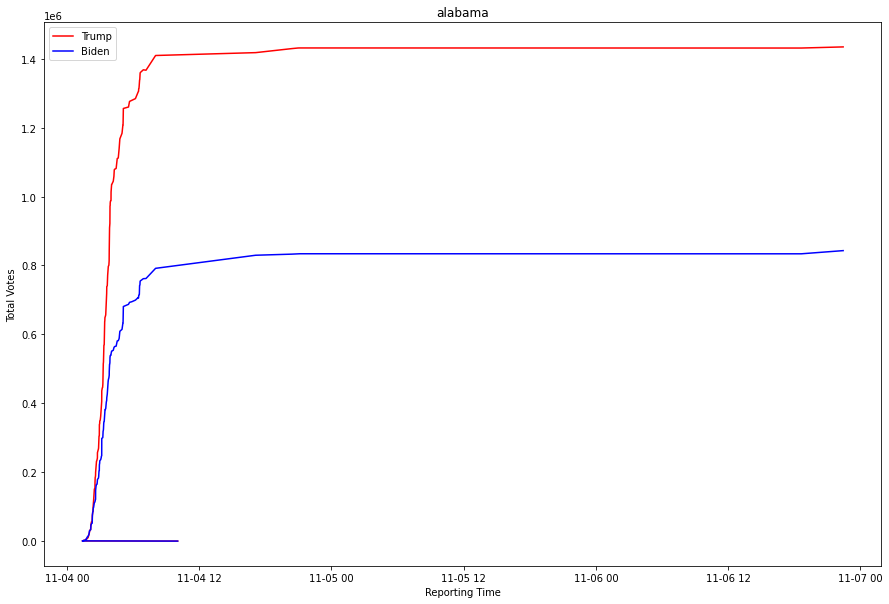

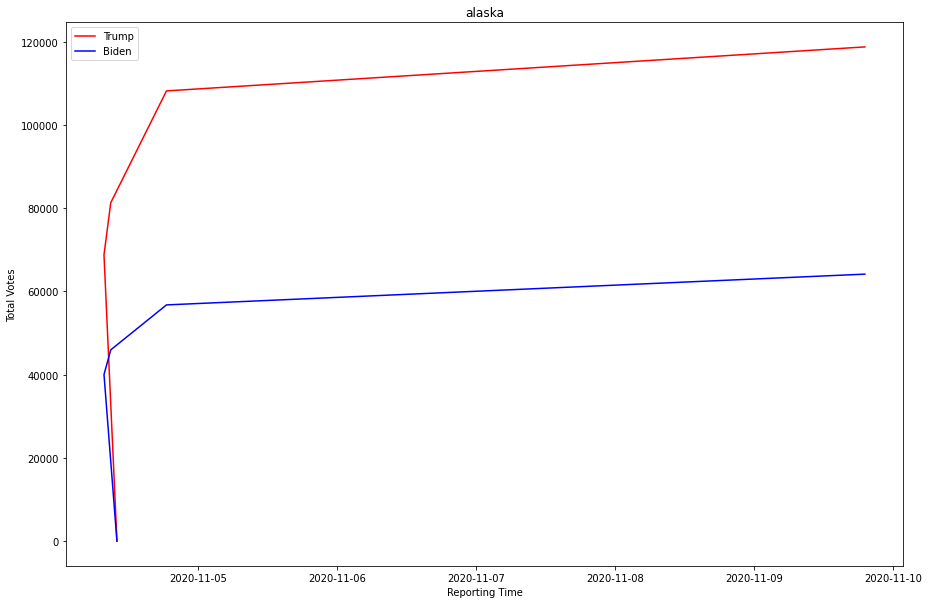

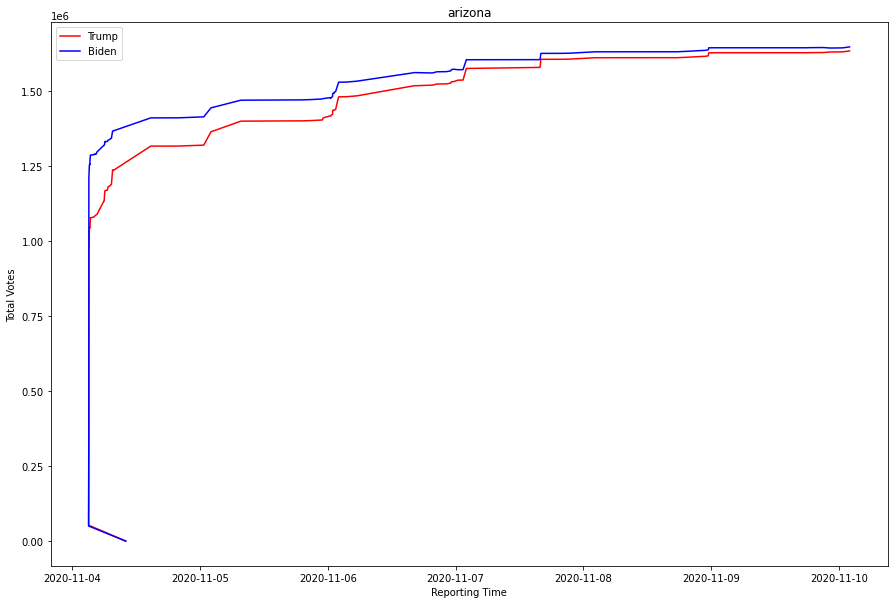

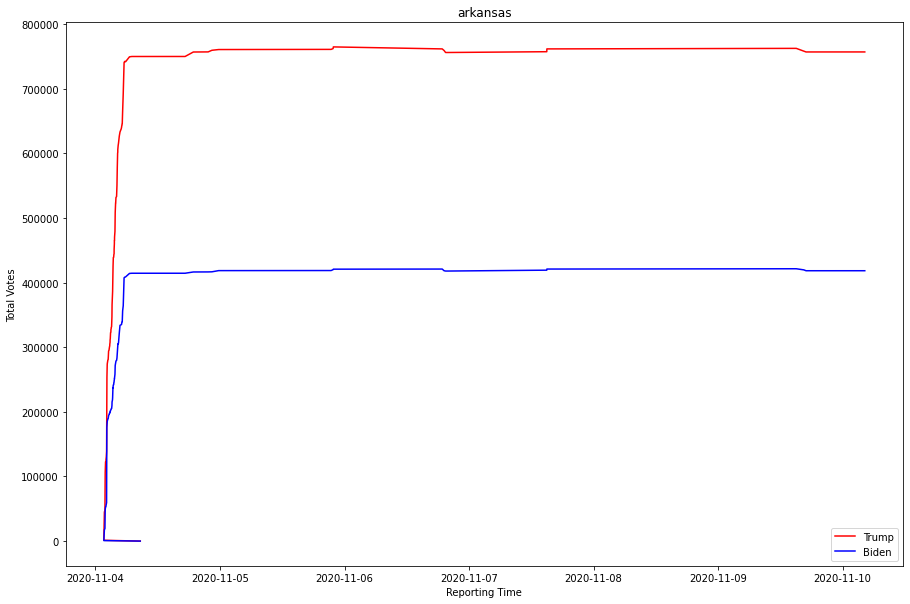

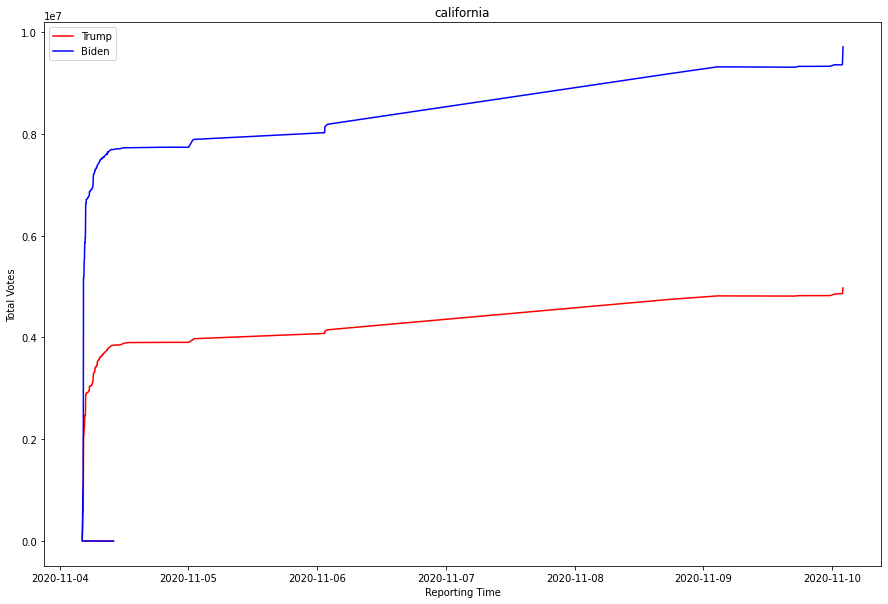

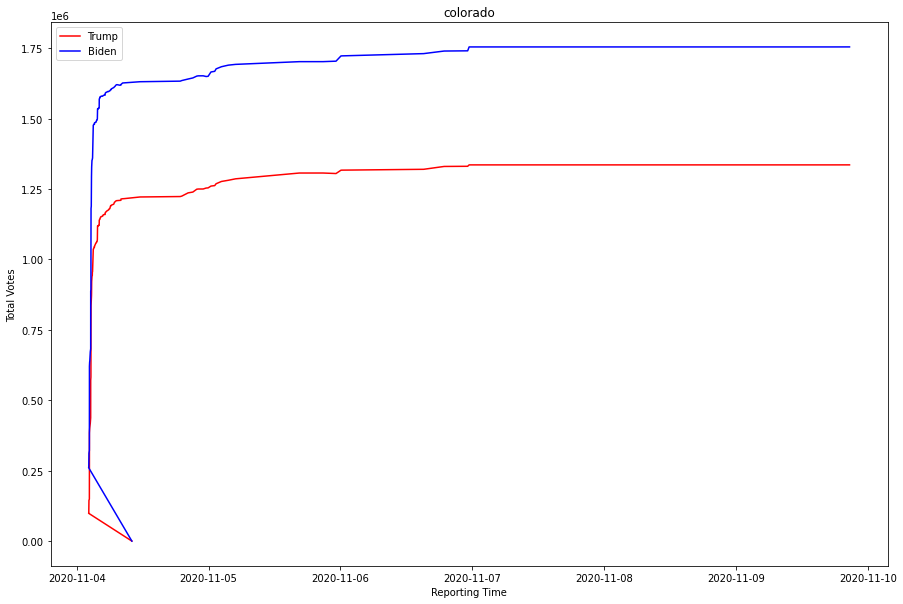

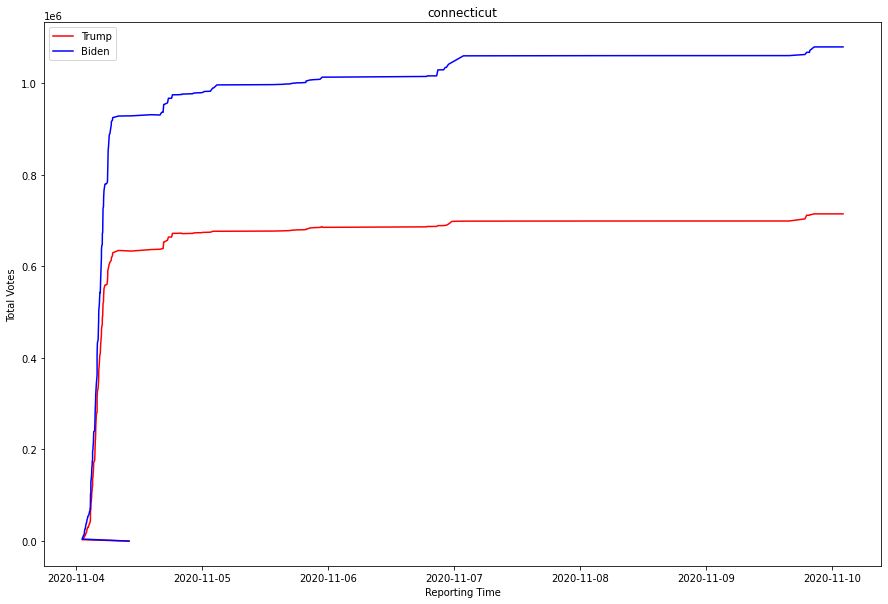

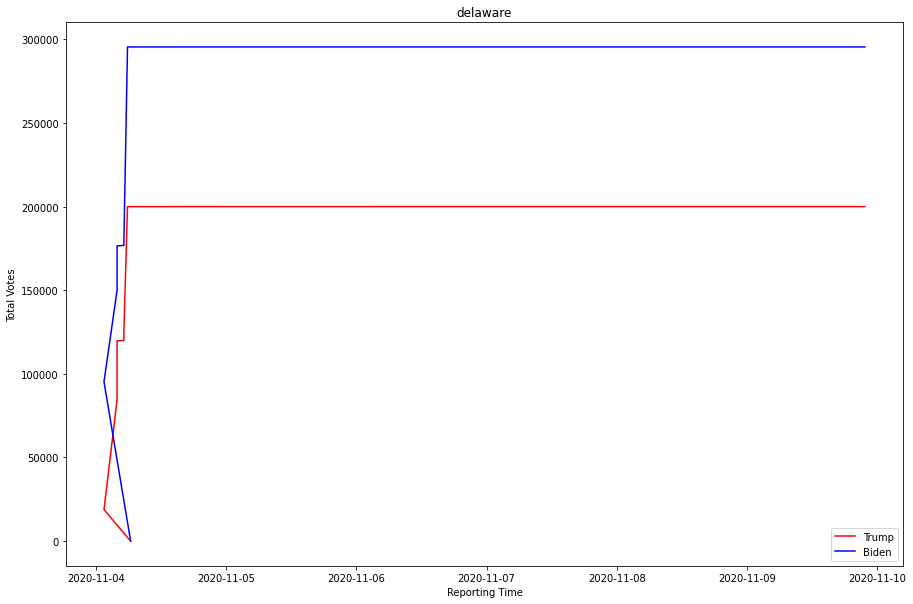

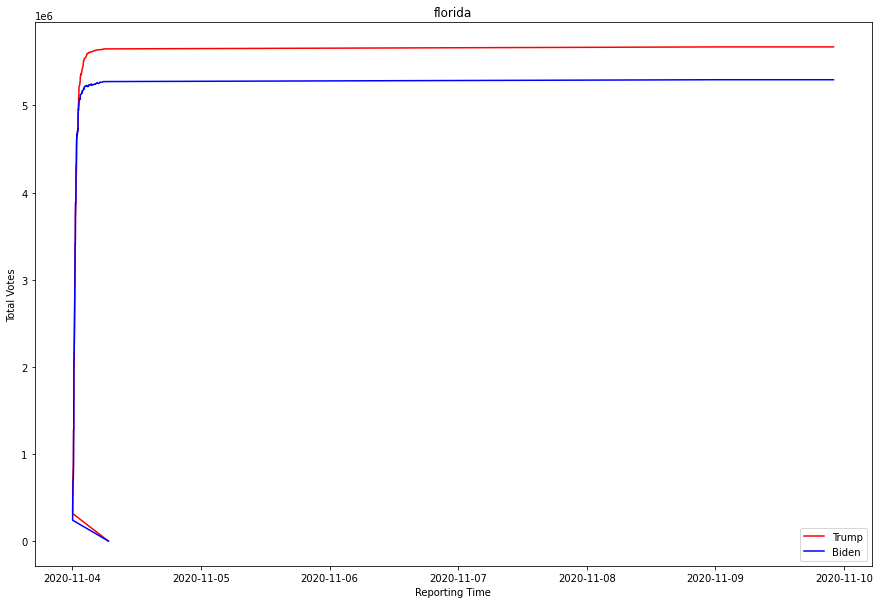

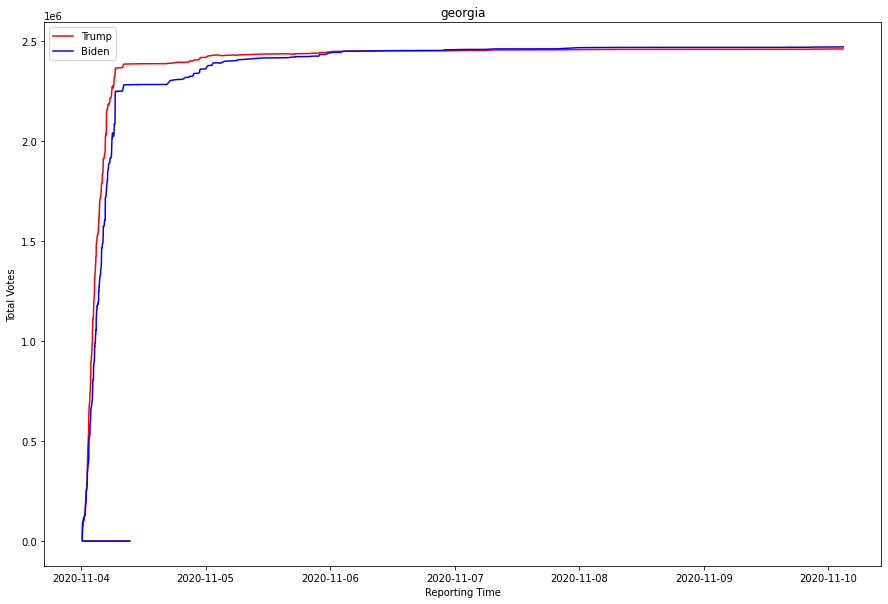

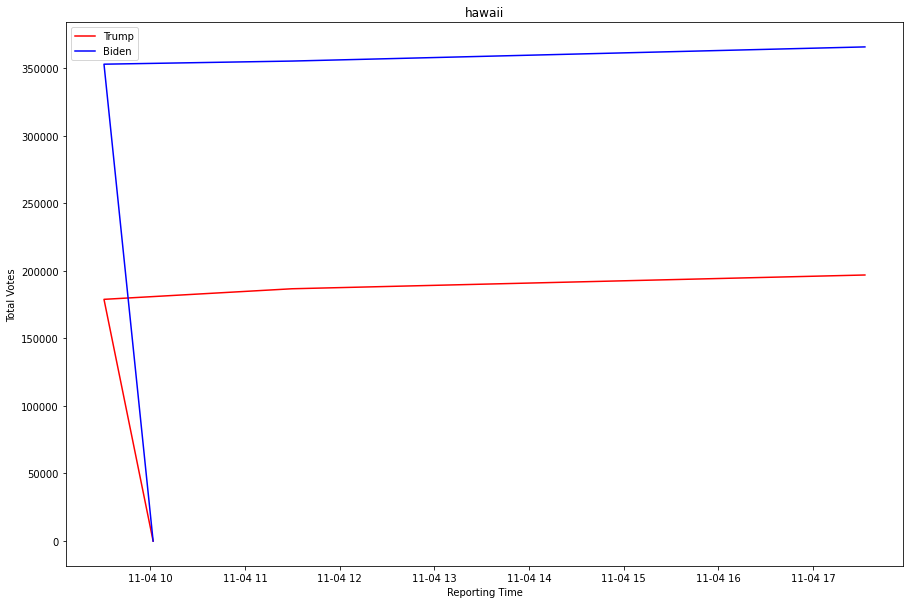

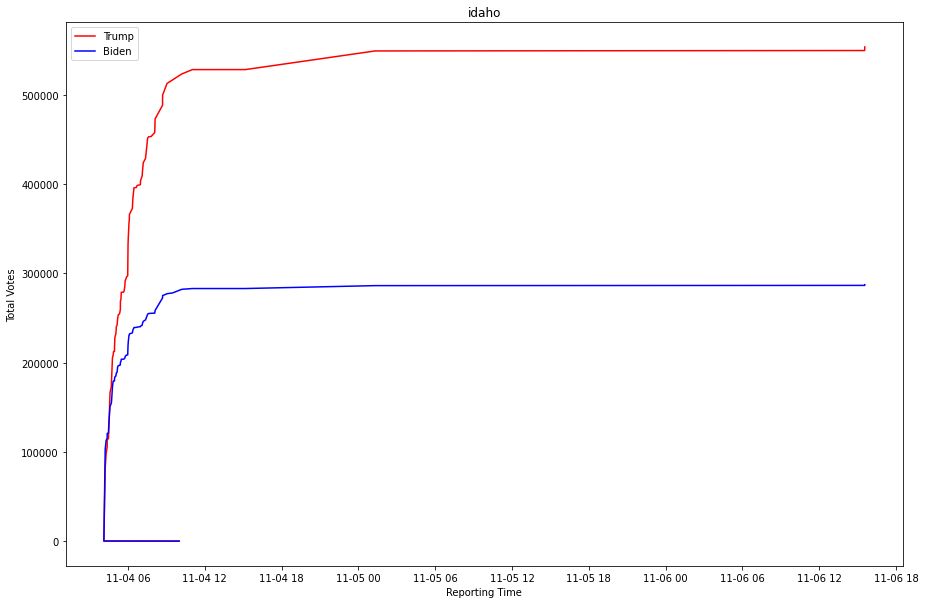

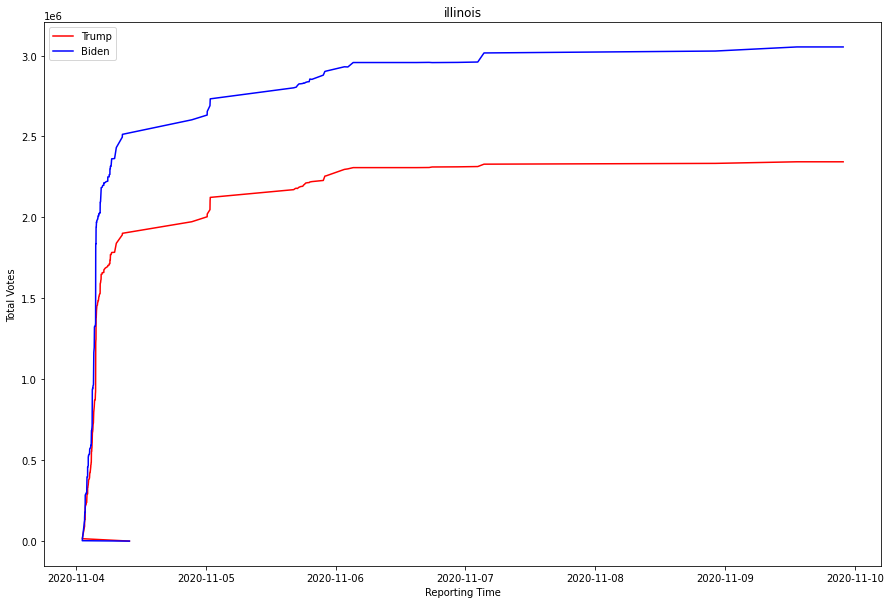

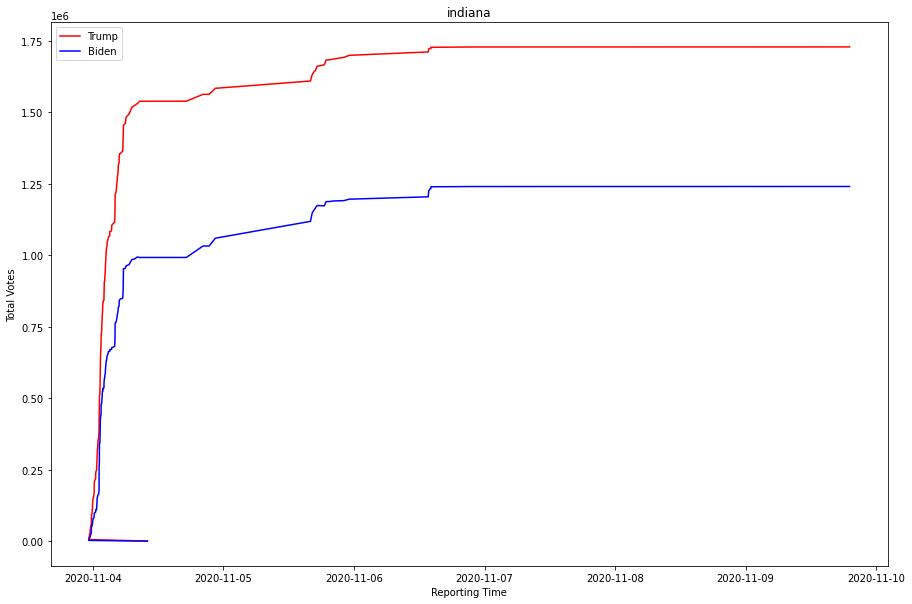

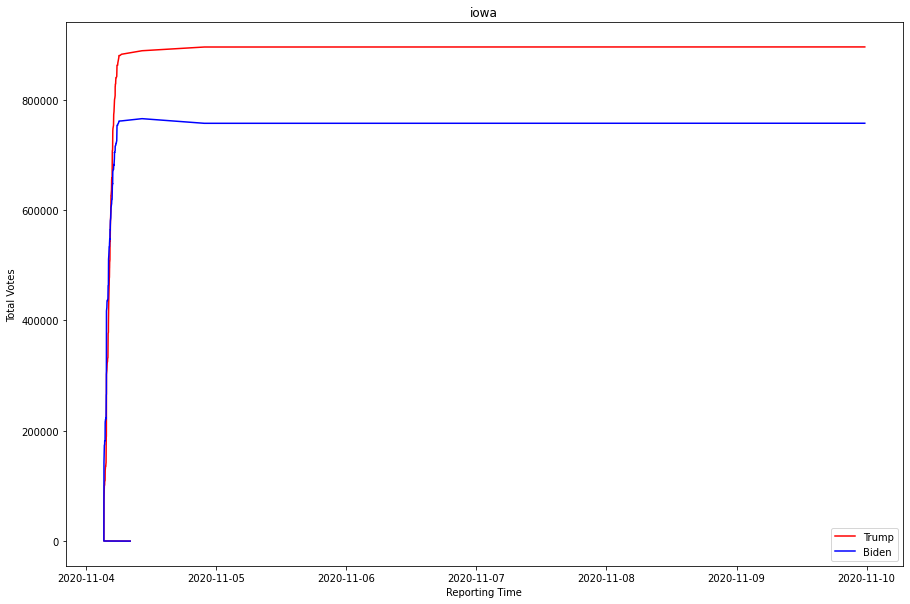

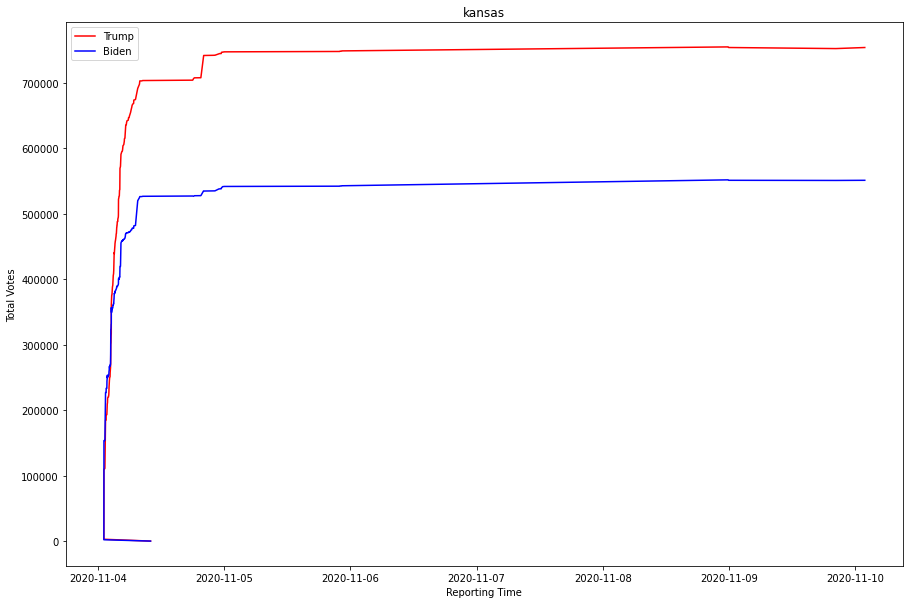

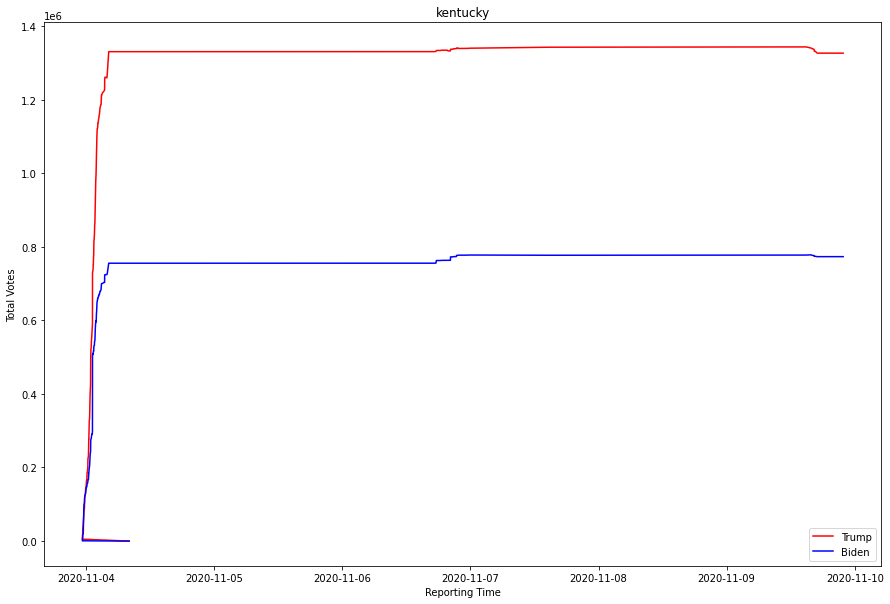

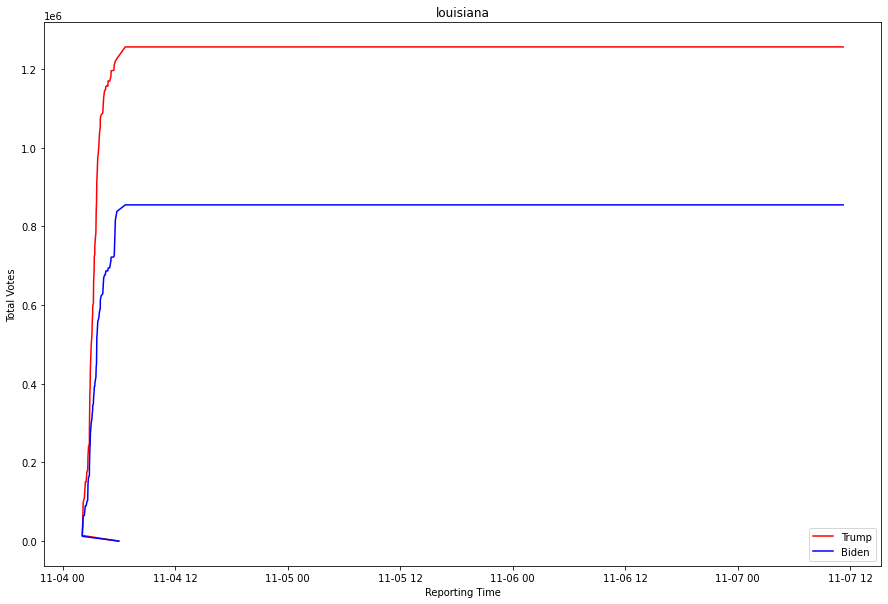

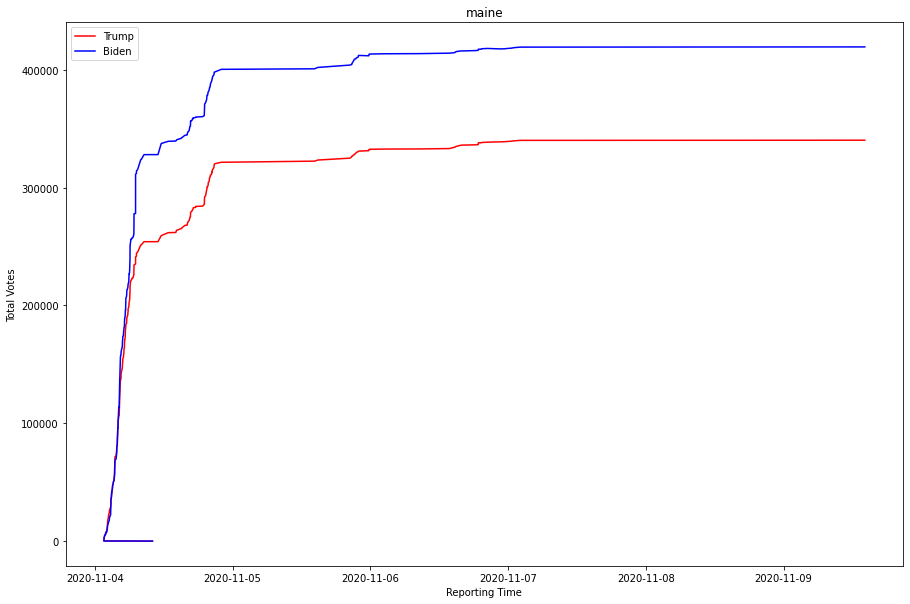

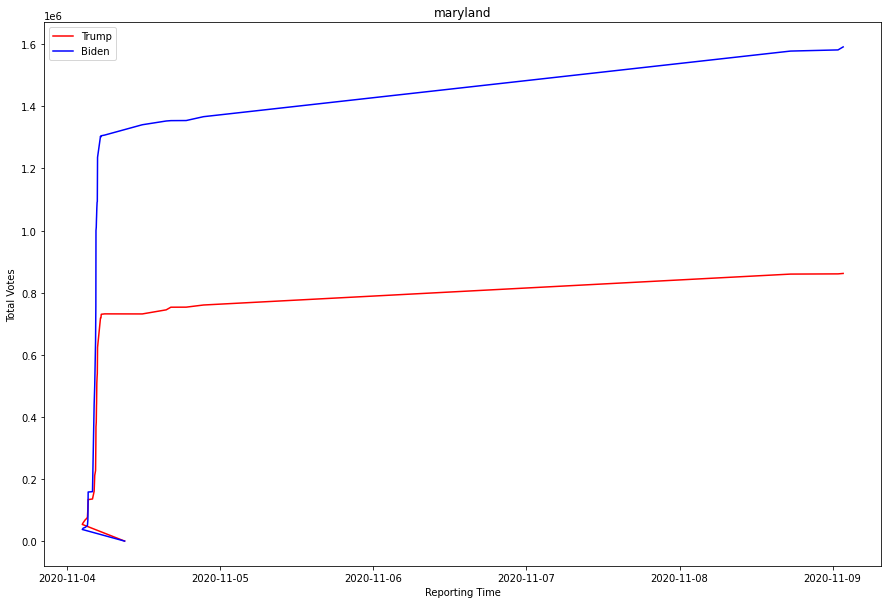

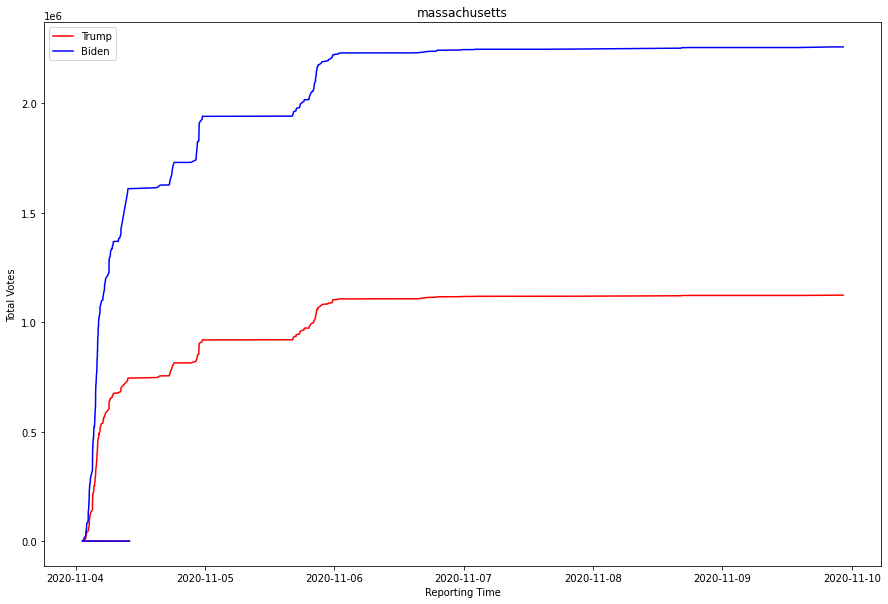

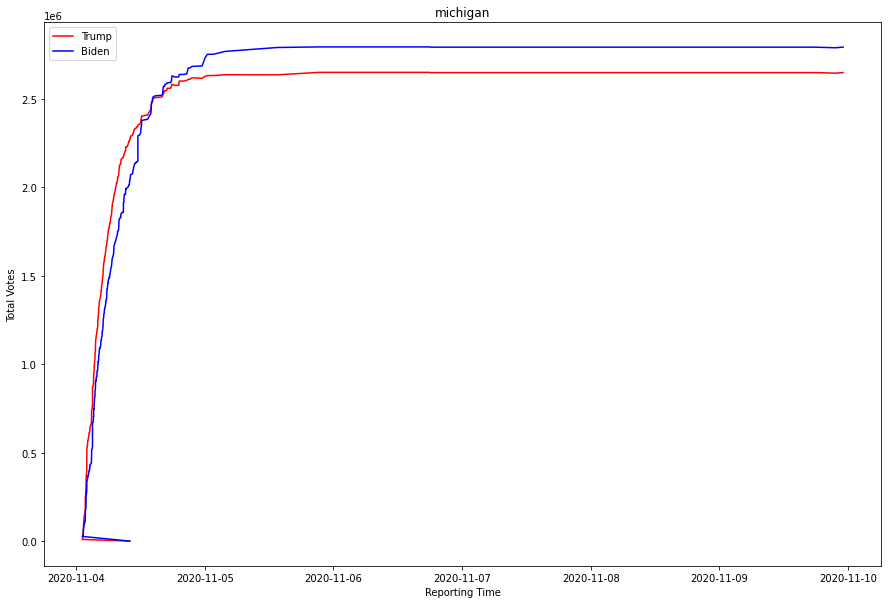

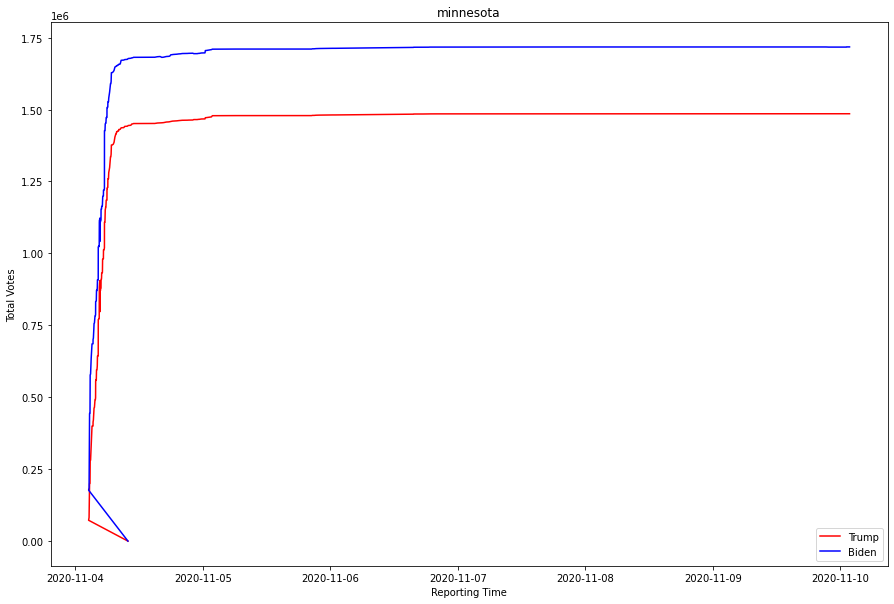

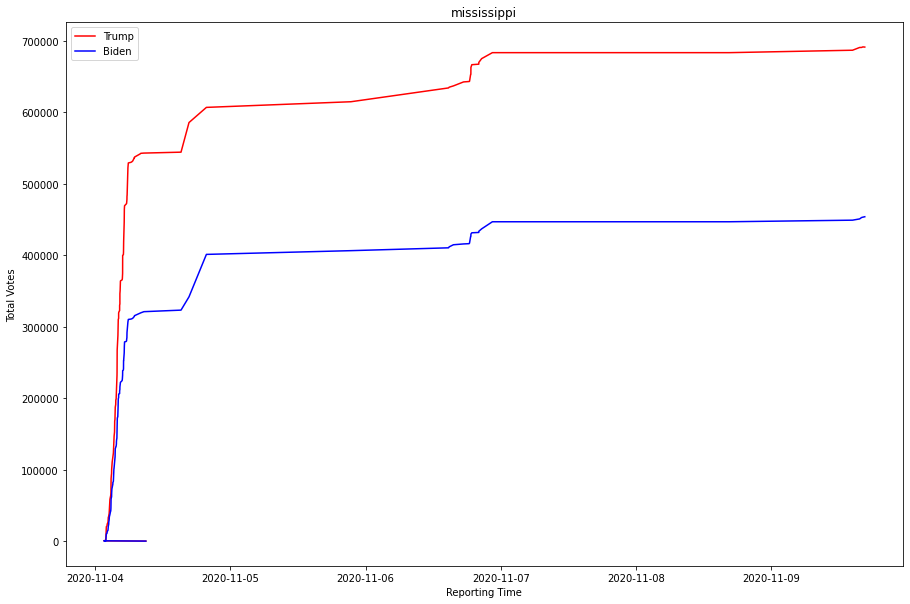

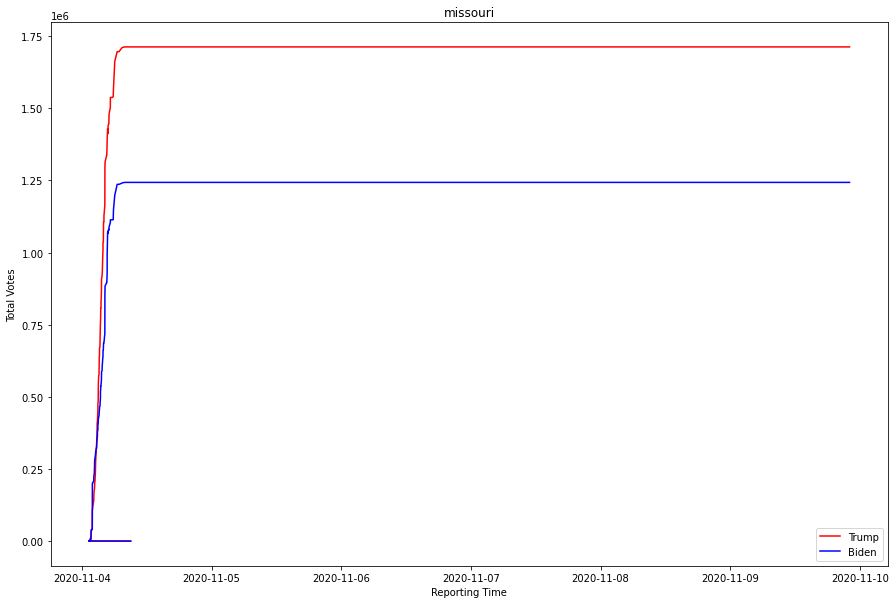

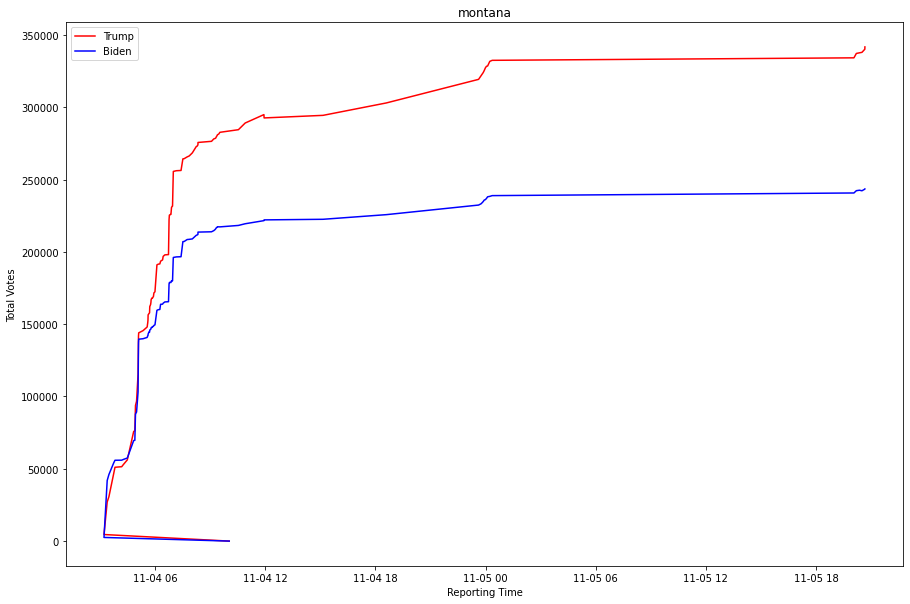

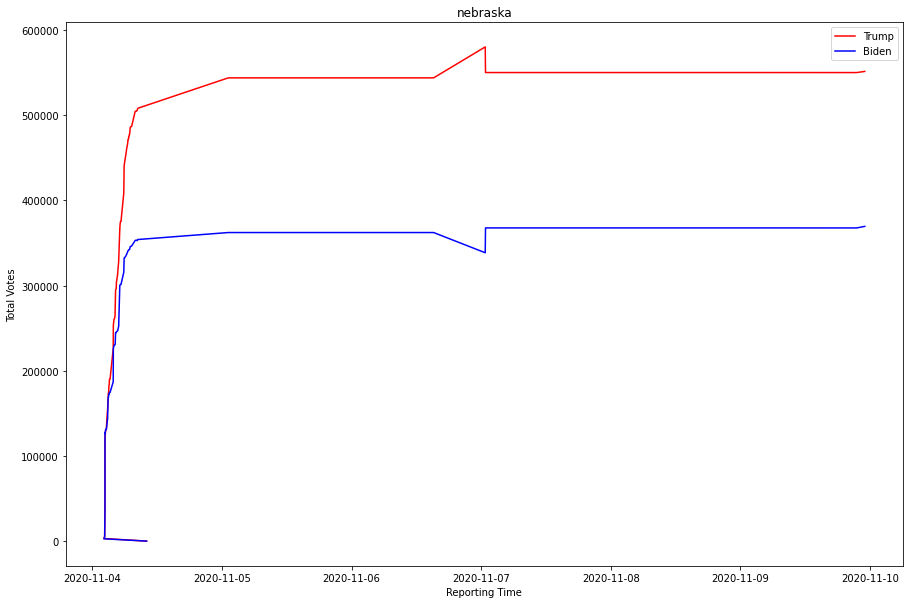

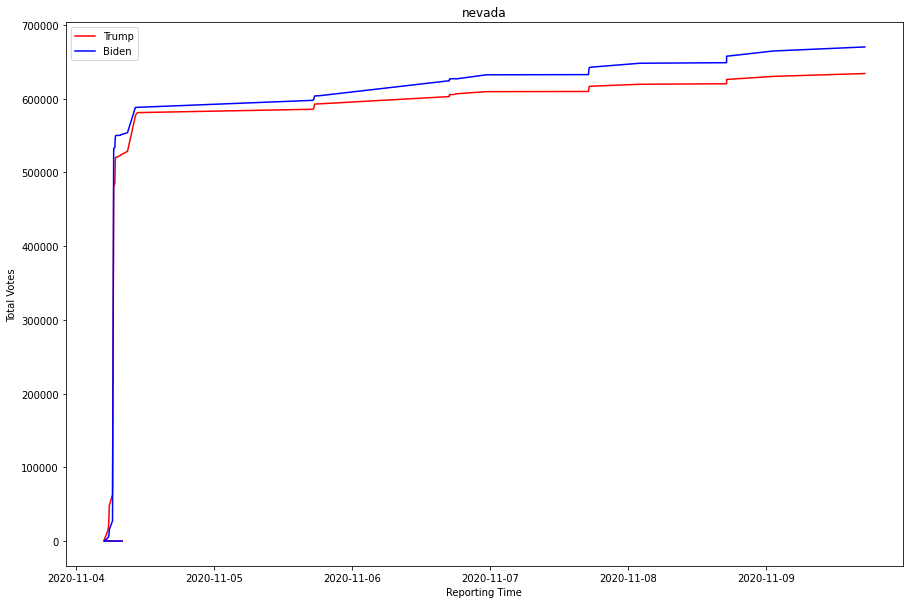

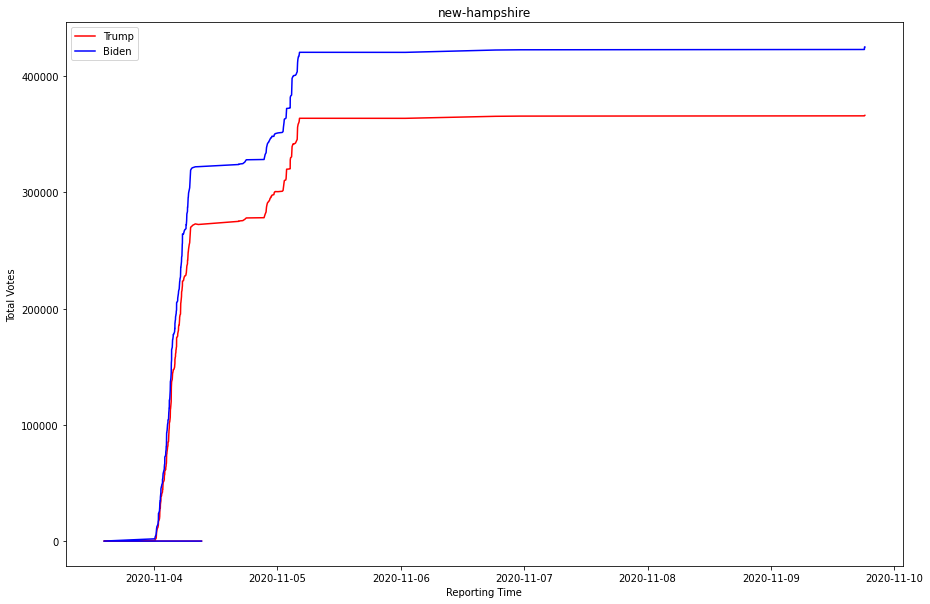

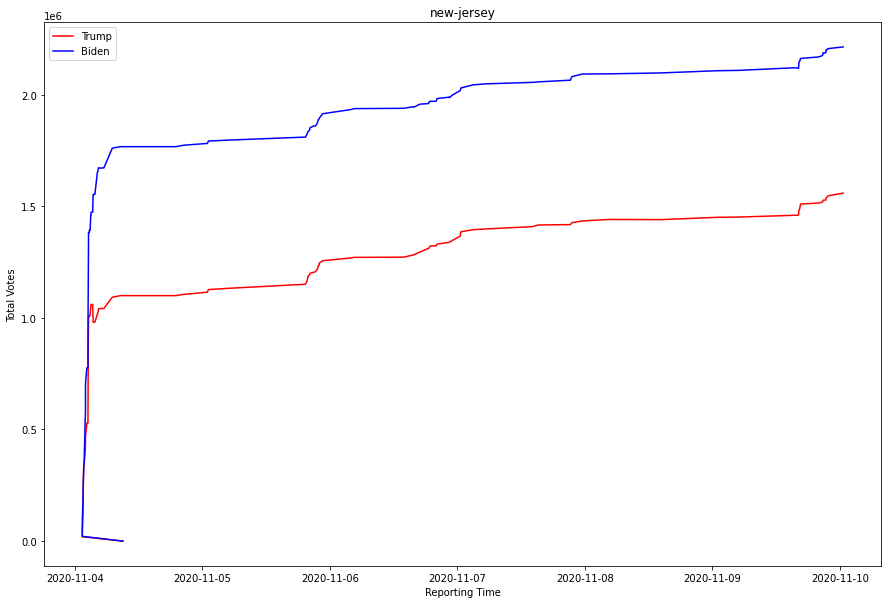

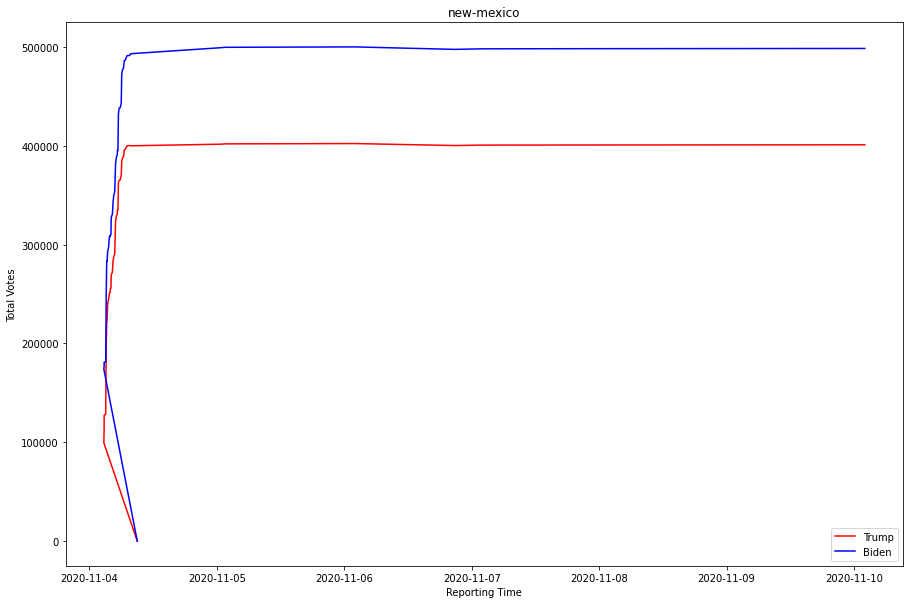

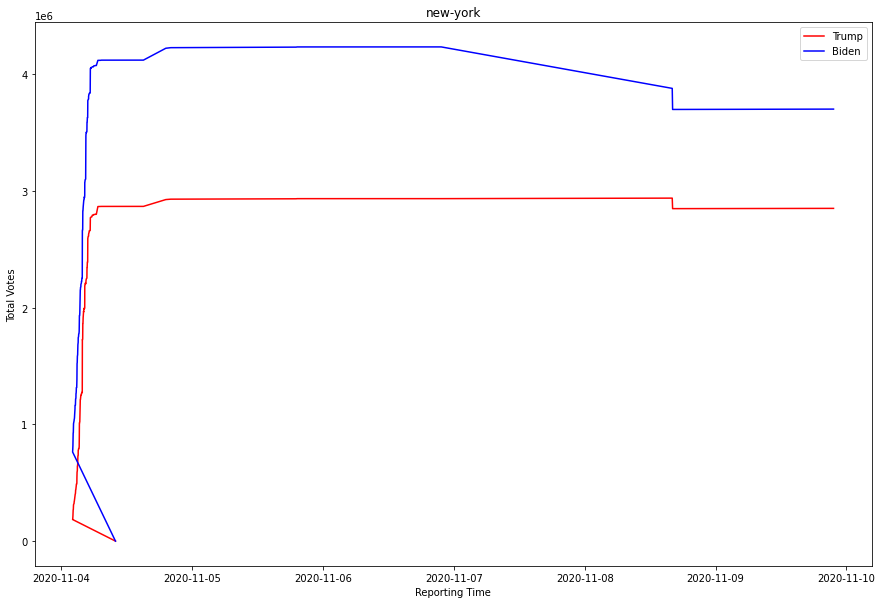

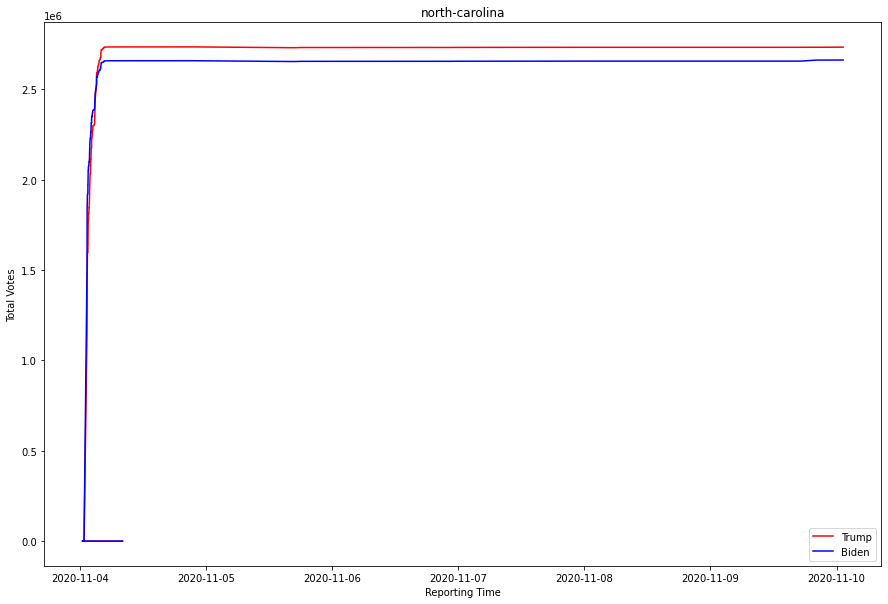

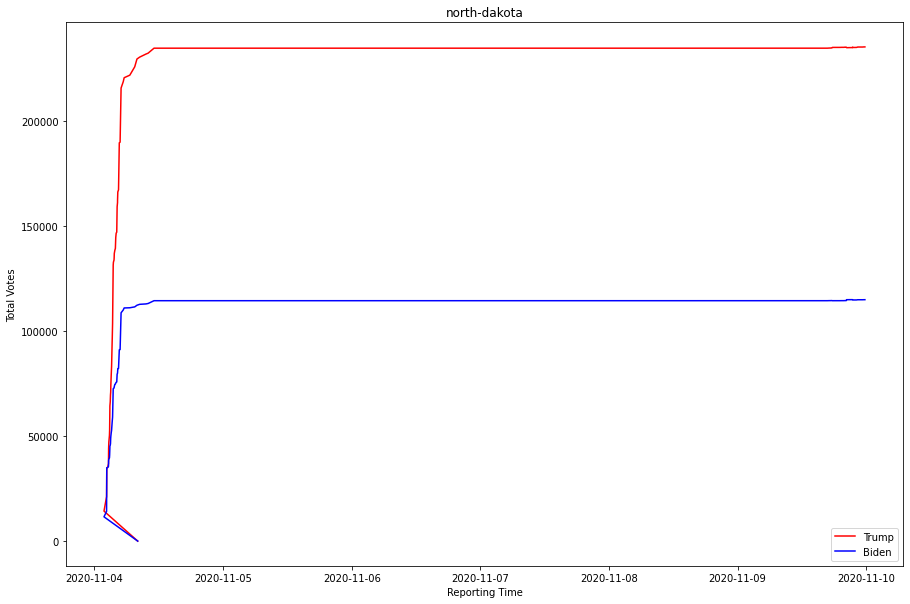

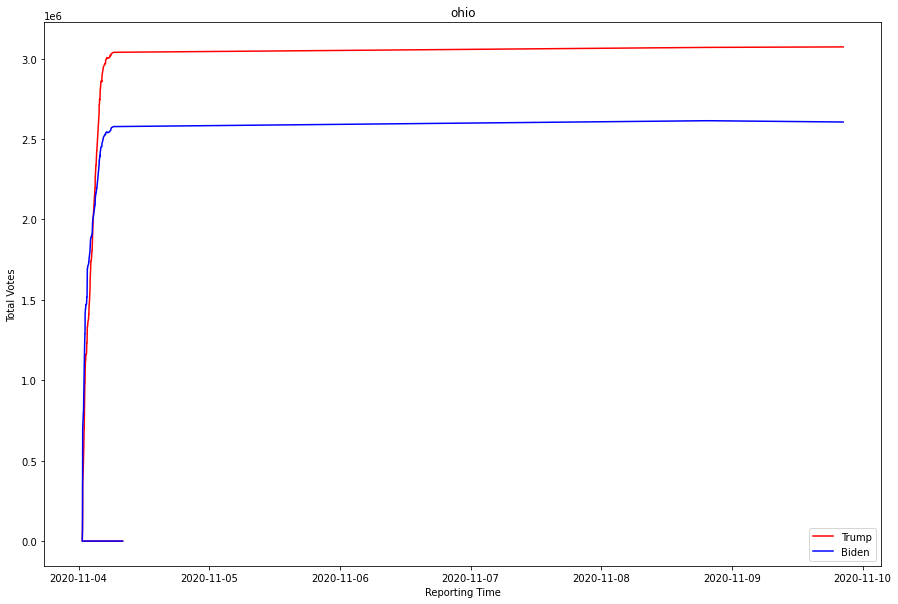

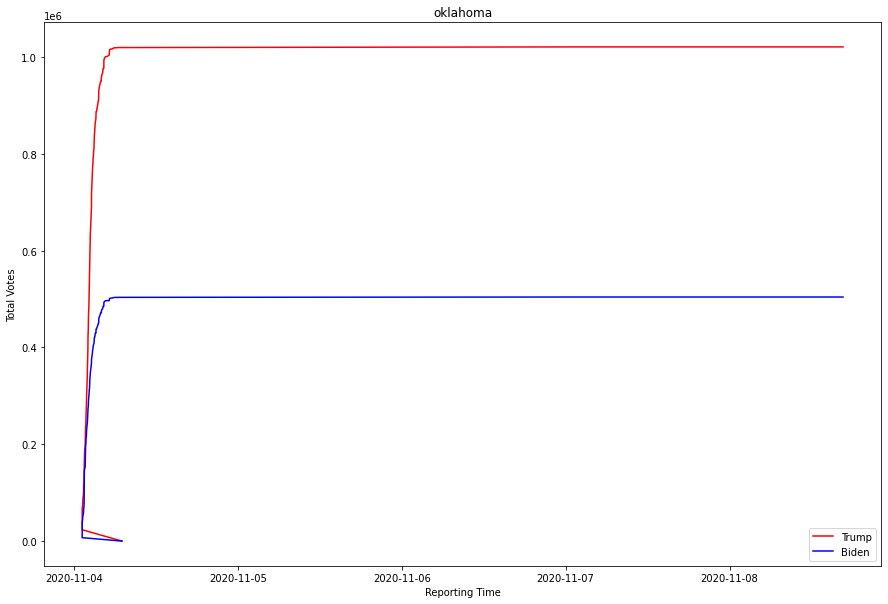

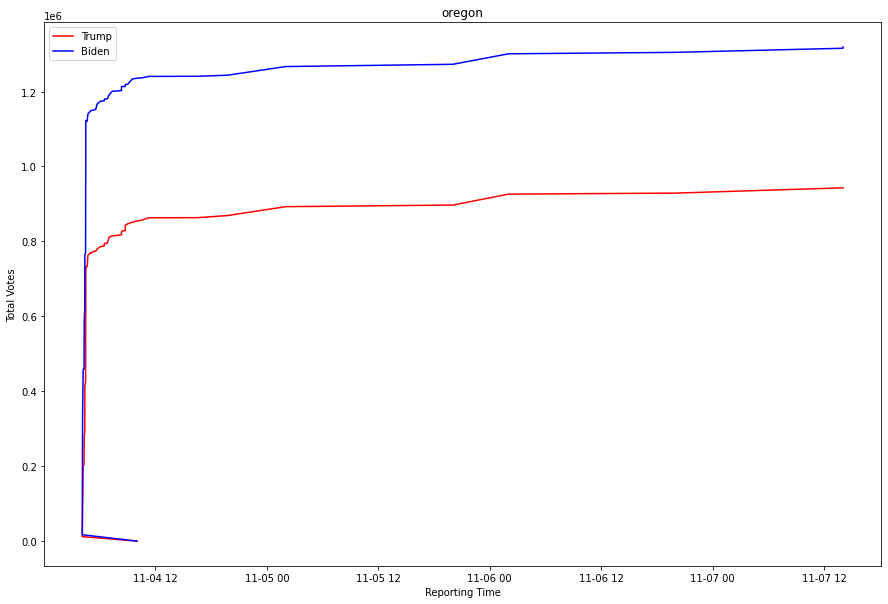

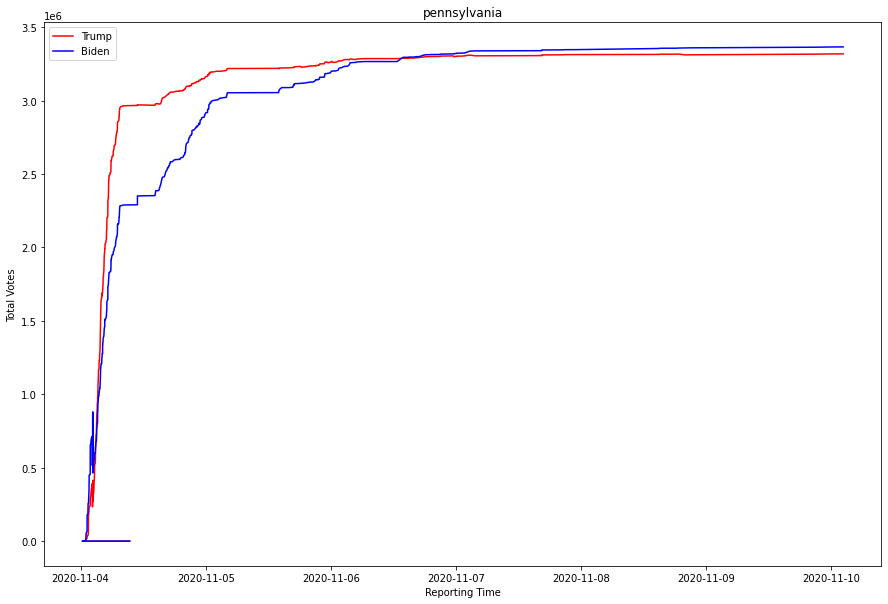

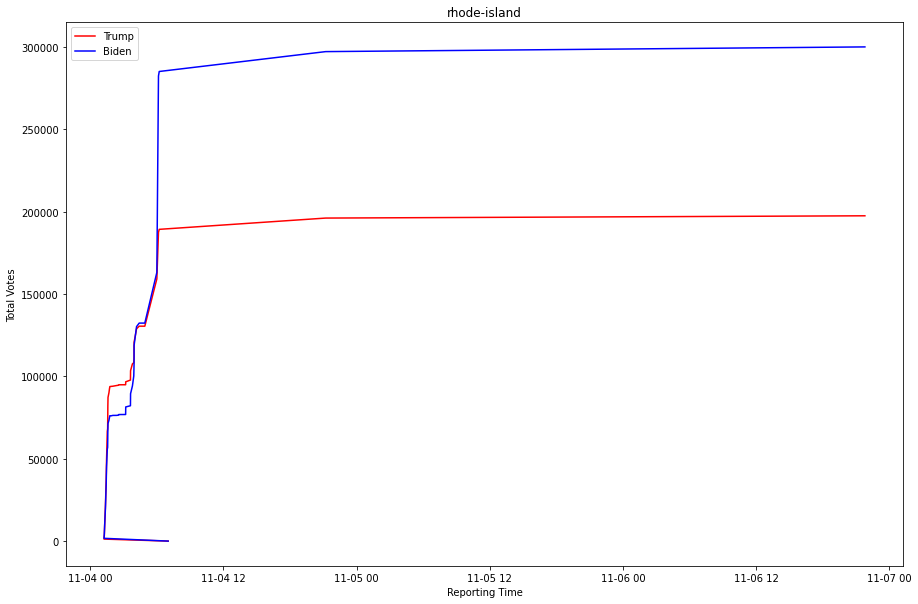

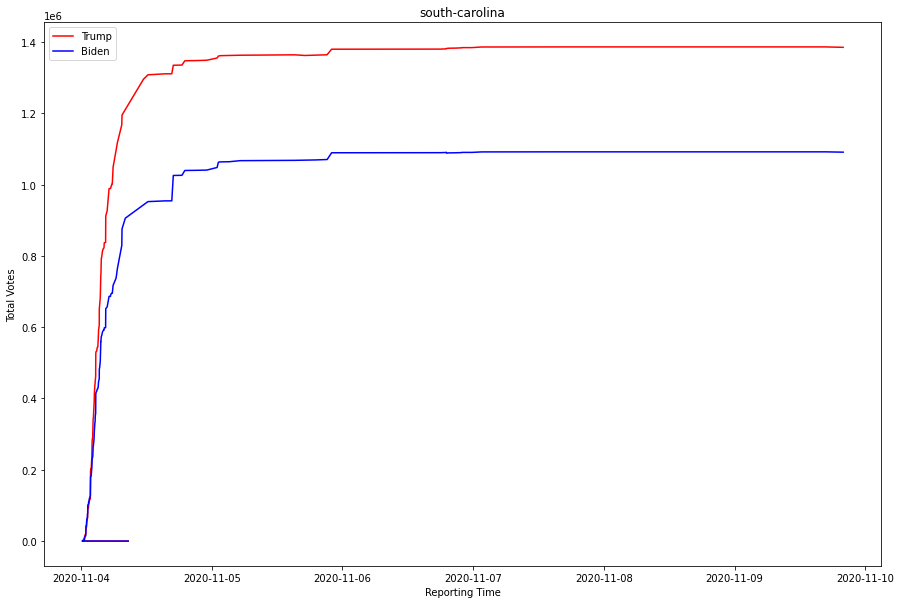

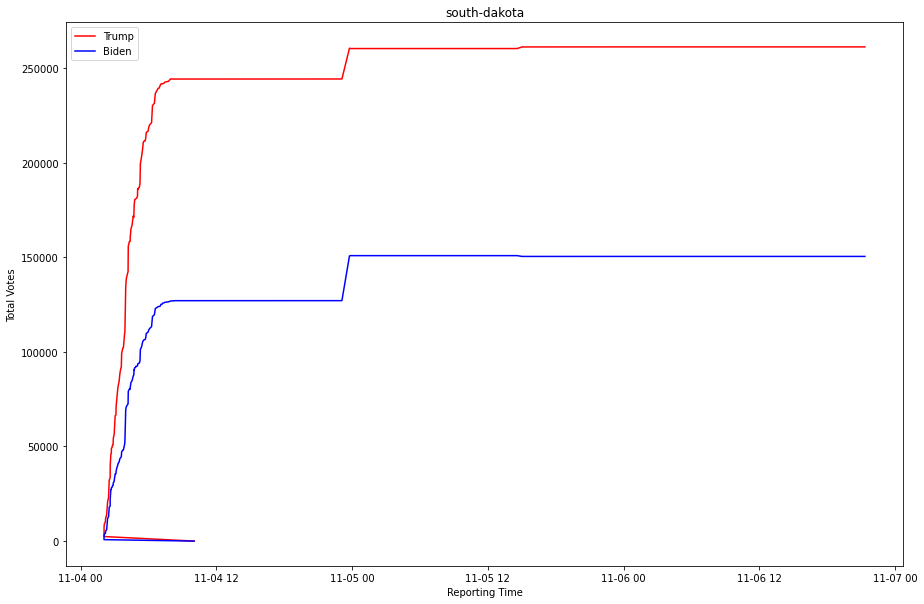

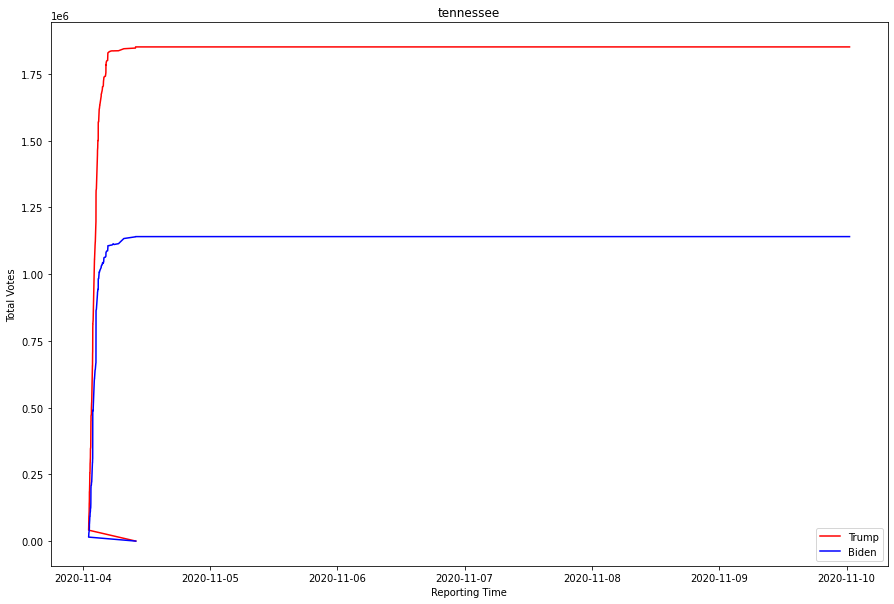

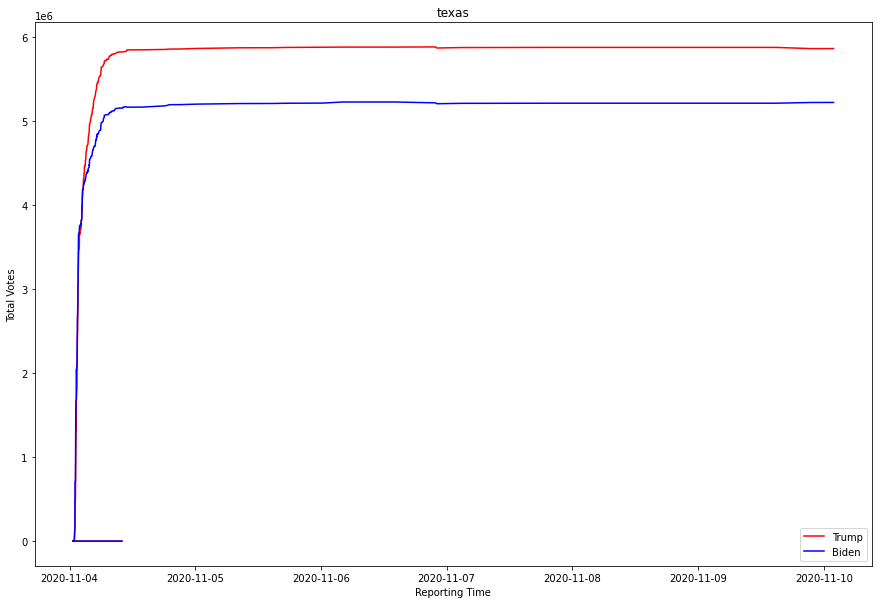

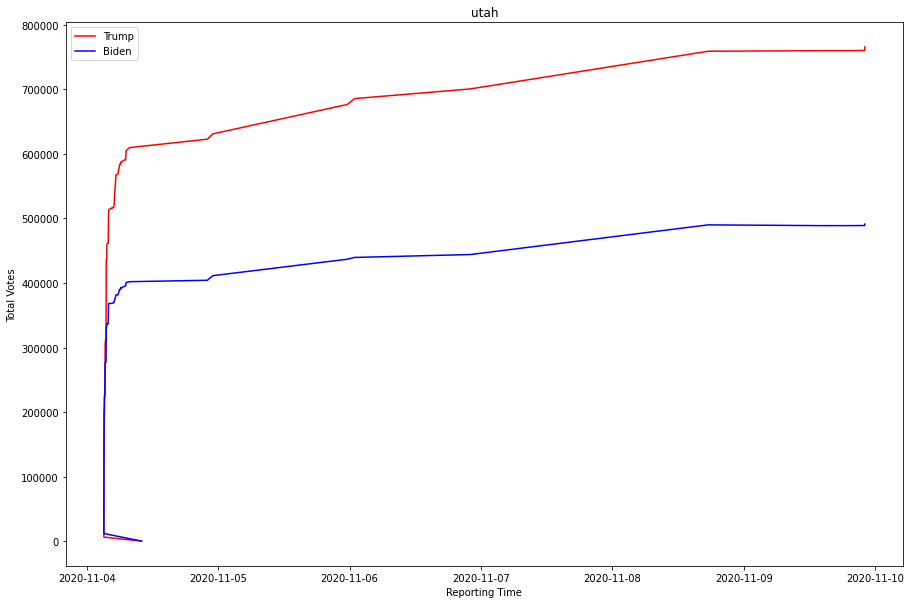

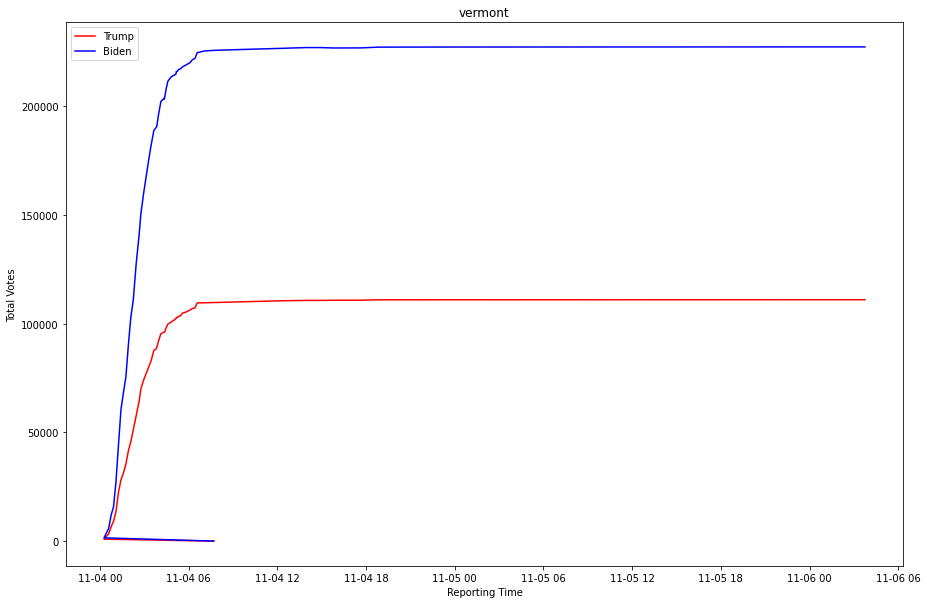

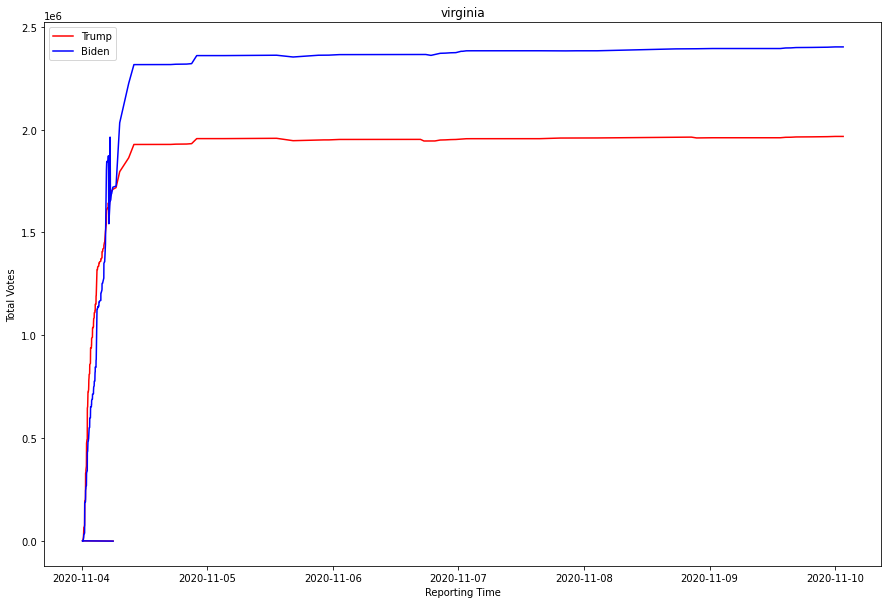

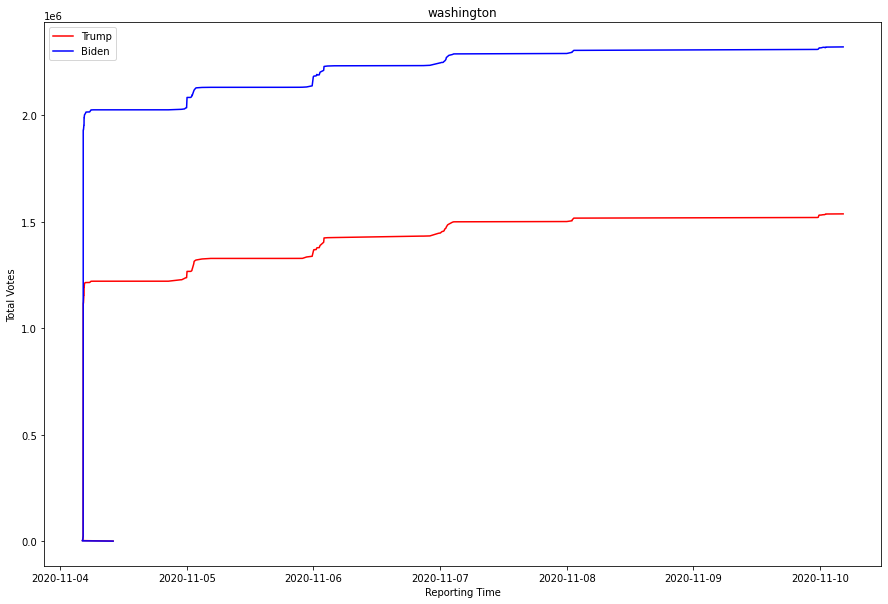

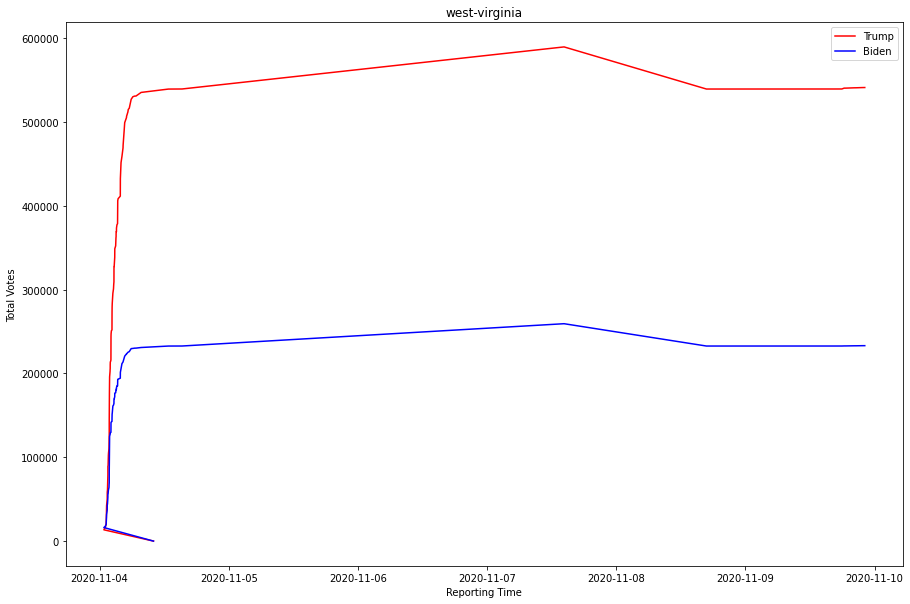

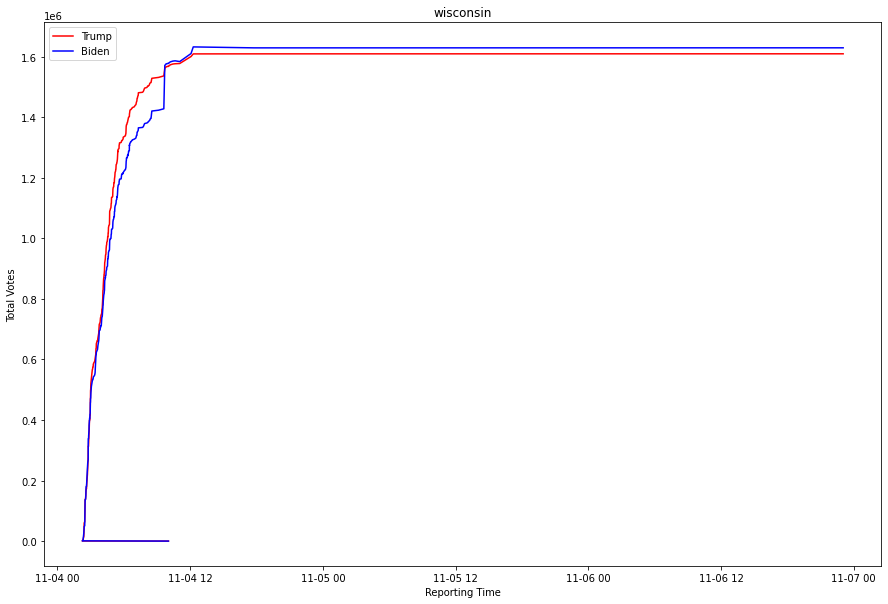

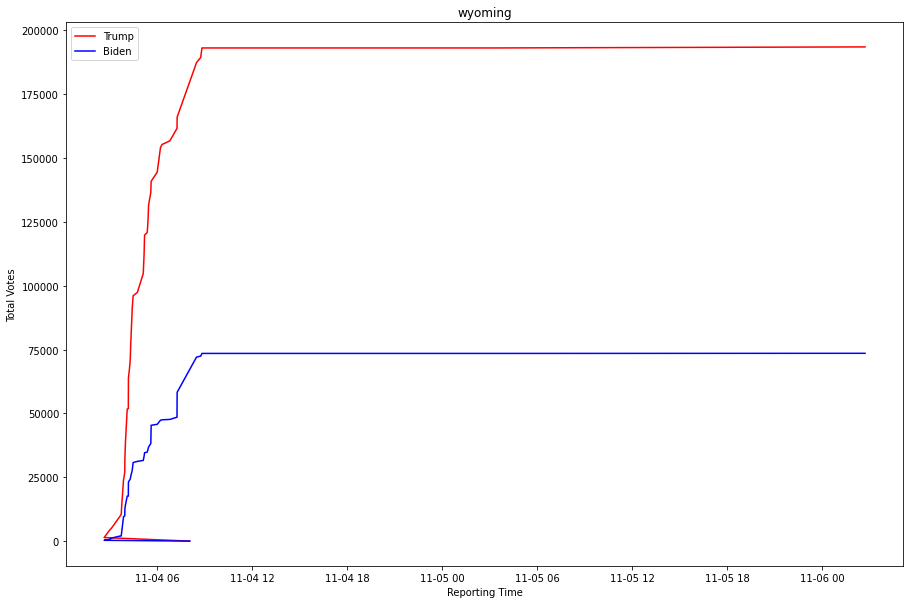

In [ ]:
rep = data.vote_share_rep.values * data.votes.values
dem = data.vote_share_dem.values * data.votes.values
timestamp = pd.to_datetime(data.timestamp).values
for state in np.unique(data.state.values):
  mask = data.state.values == state
  plt.figure(figsize=(15, 10))
  plt.plot(timestamp[mask], rep[mask], label='Trump', color='red')
  plt.plot(timestamp[mask], dem[mask], label='Biden', color='blue')
  plt.title(state)
  plt.legend()
  plt.xlabel('Reporting Time')
  plt.ylabel('Total Votes')

# Homogeneity Analysis

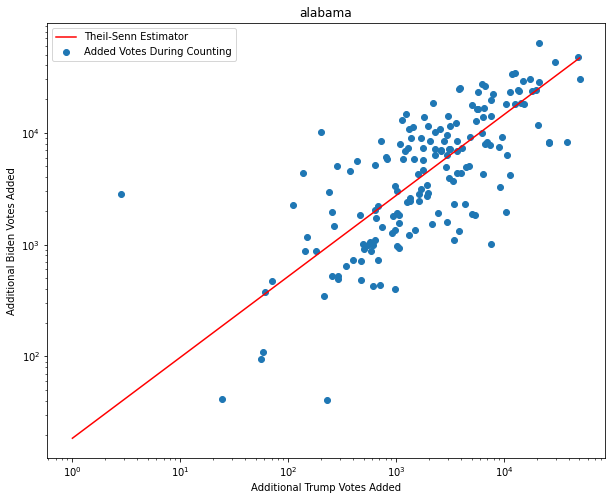

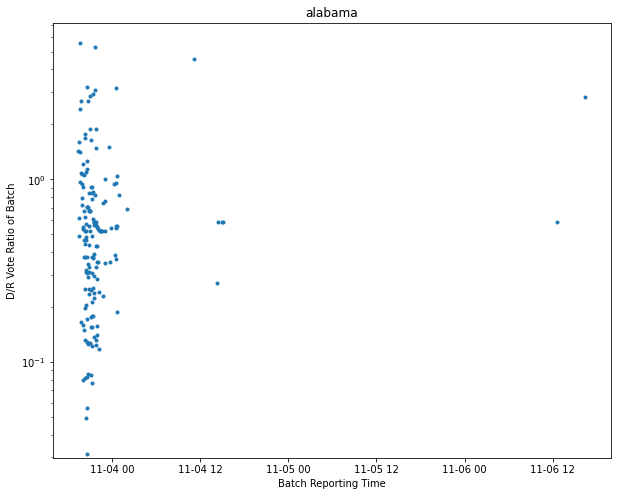

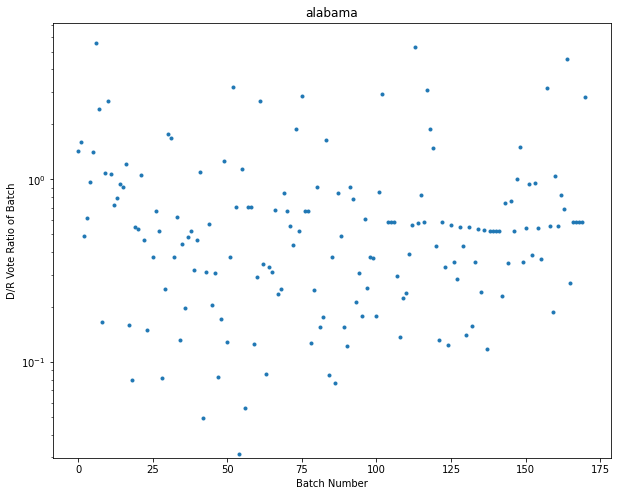

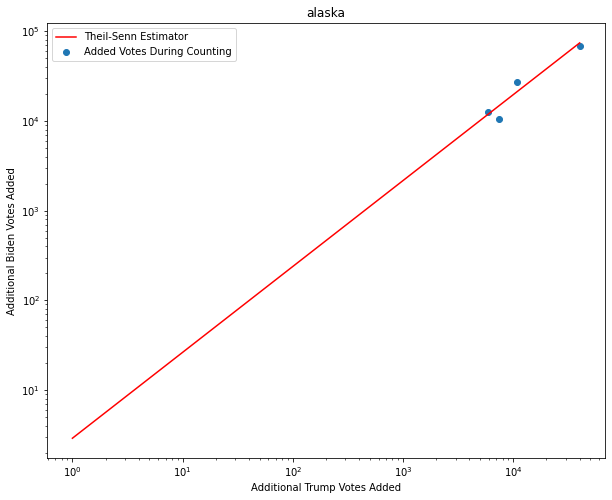

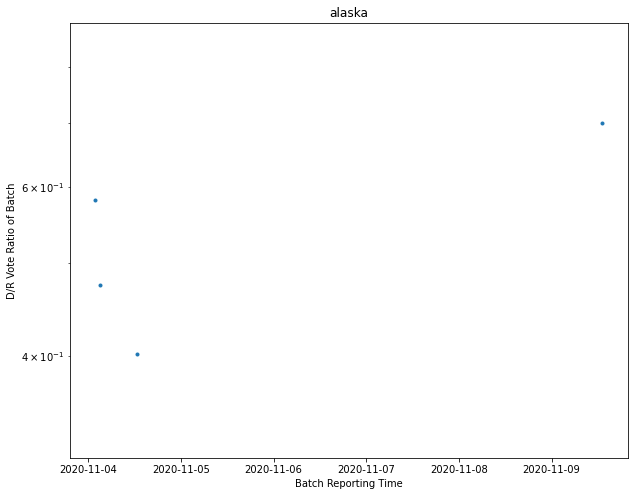

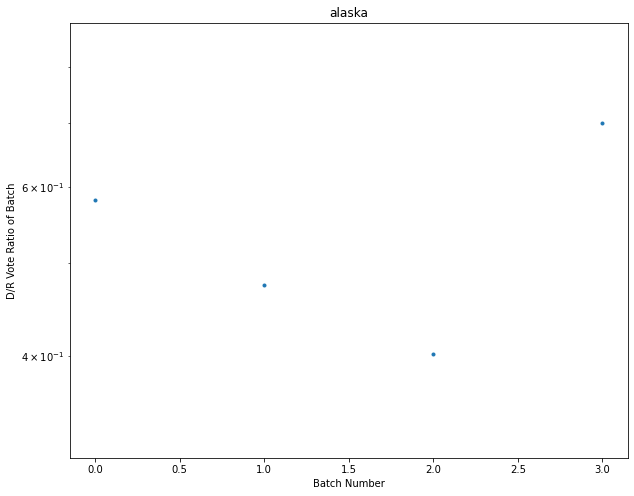

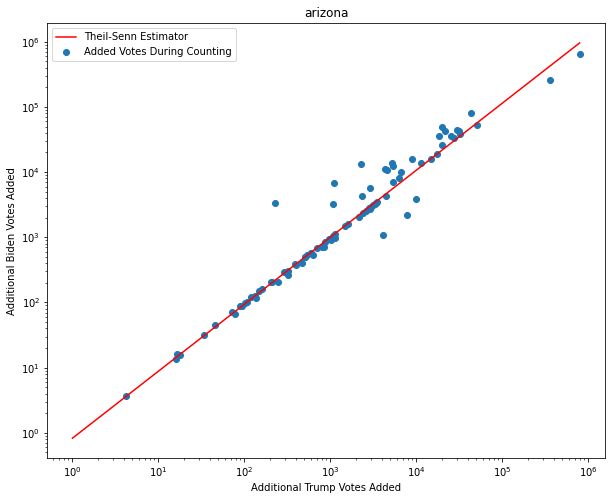

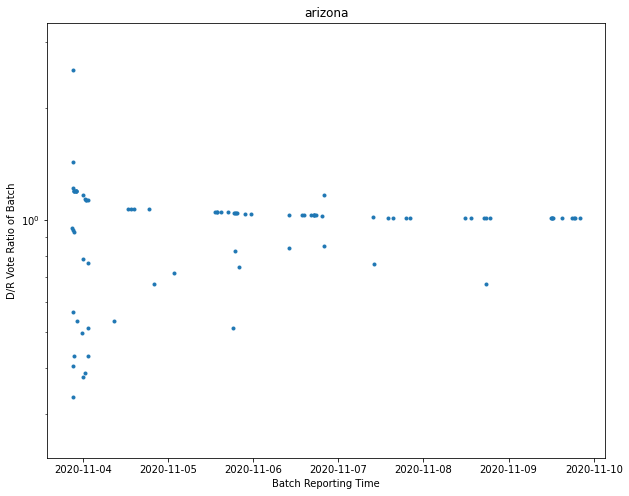

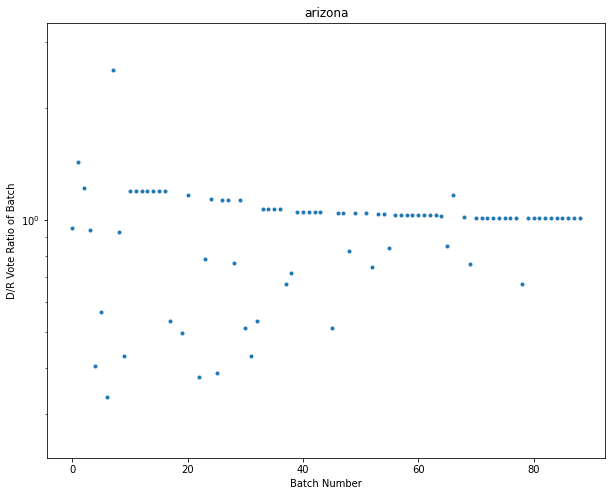

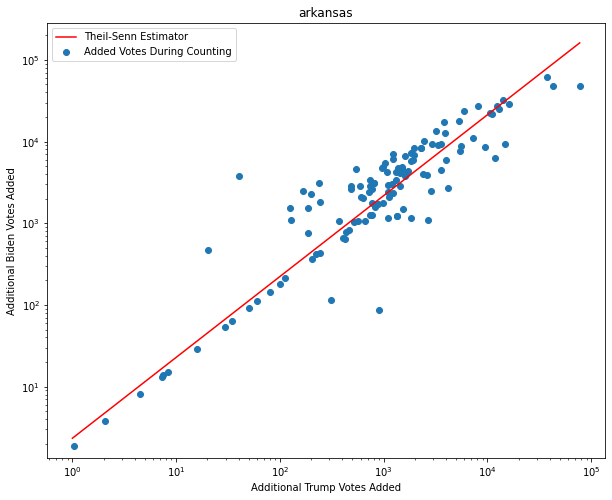

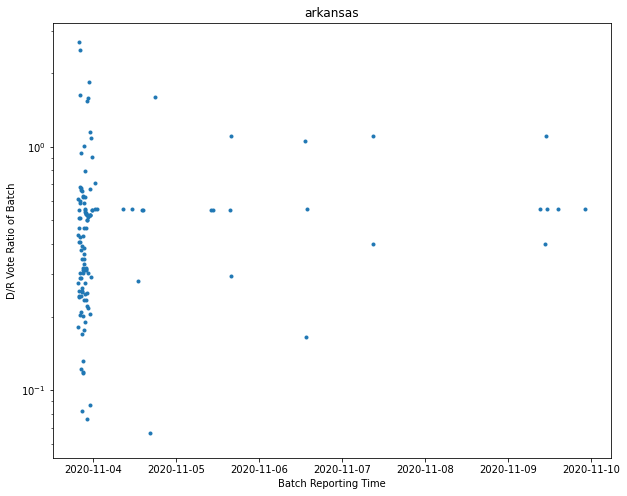

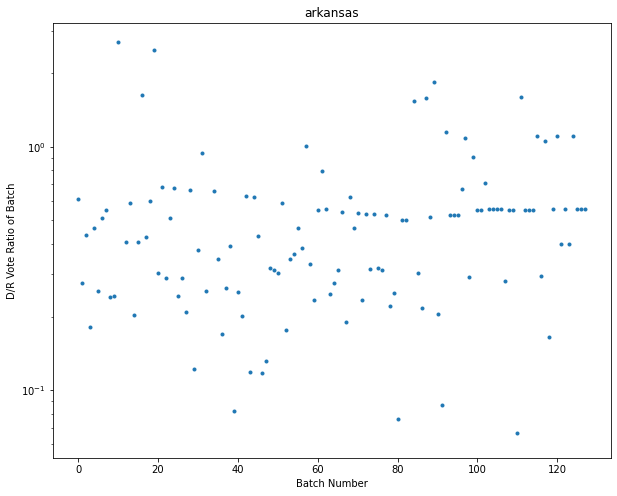

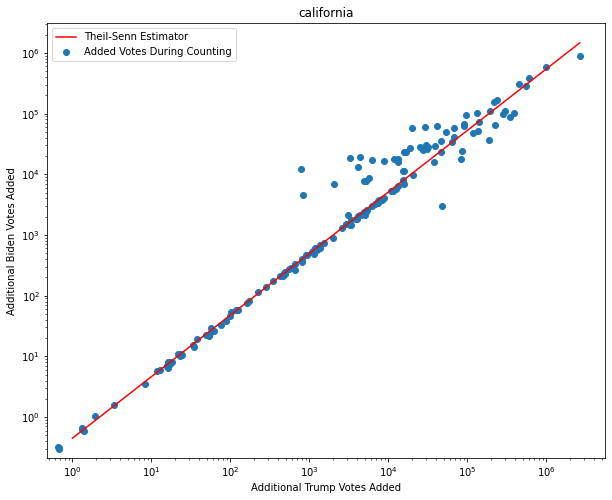

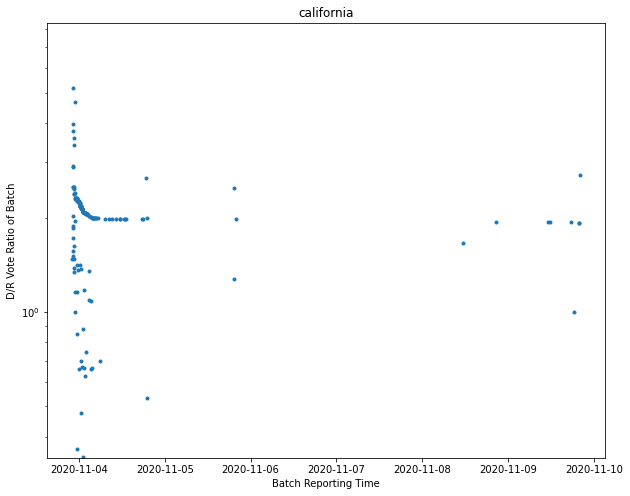

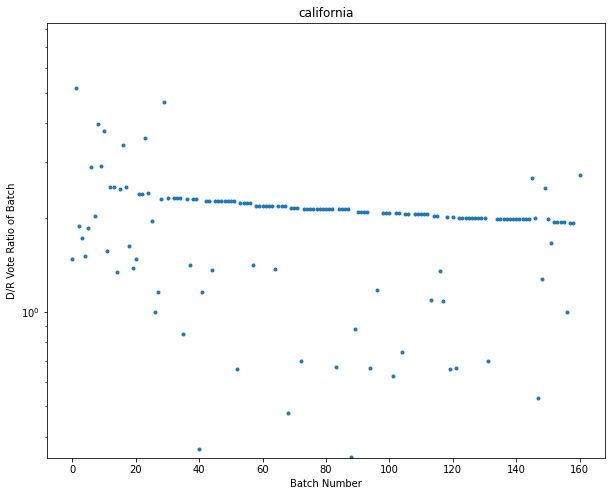

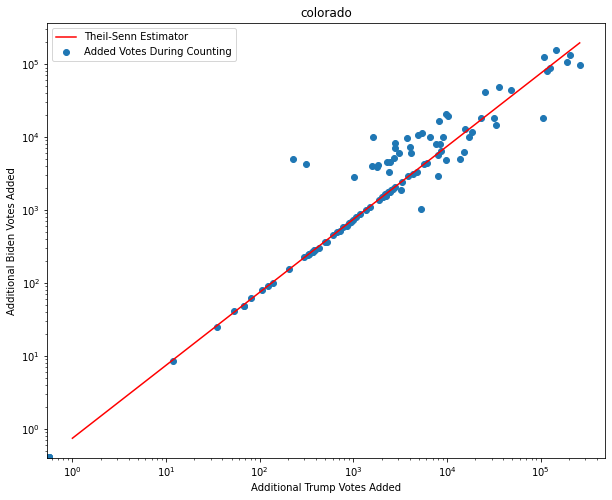

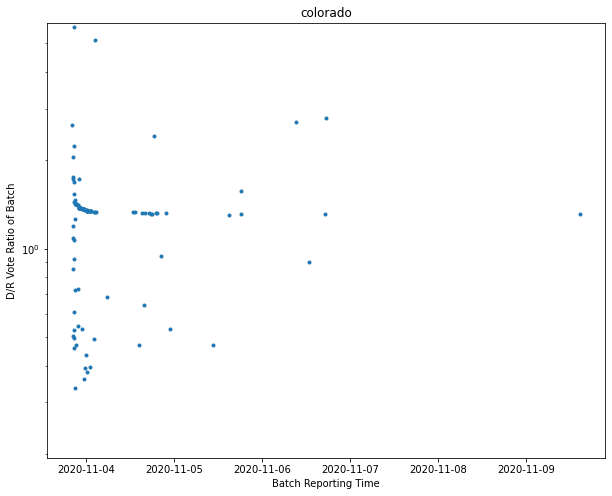

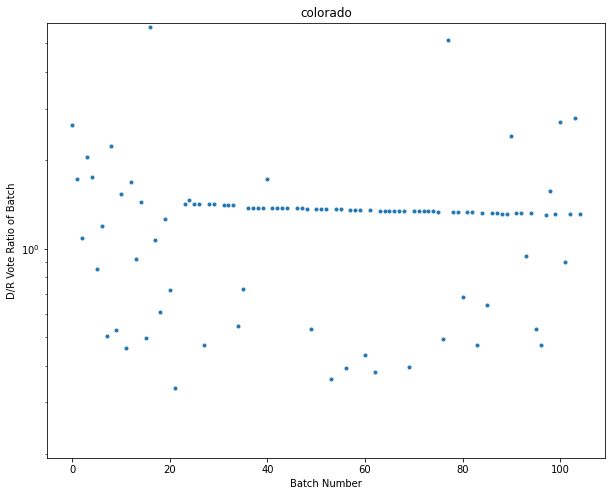

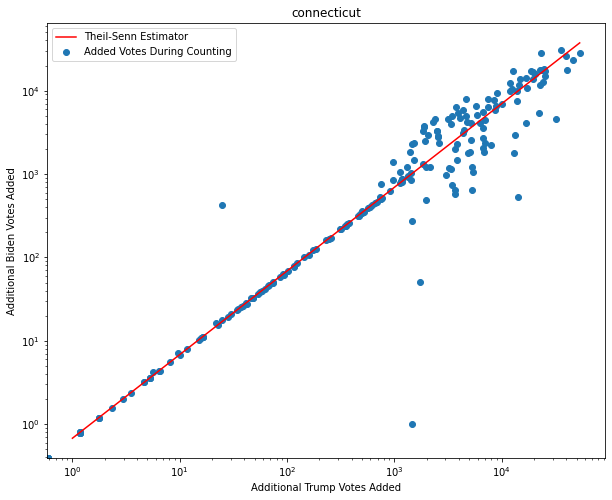

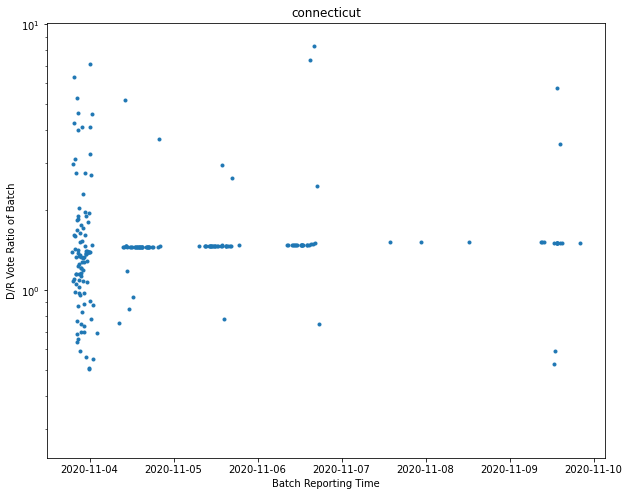

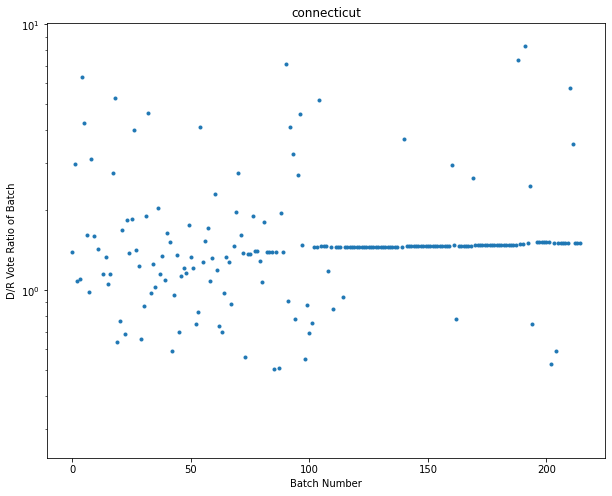

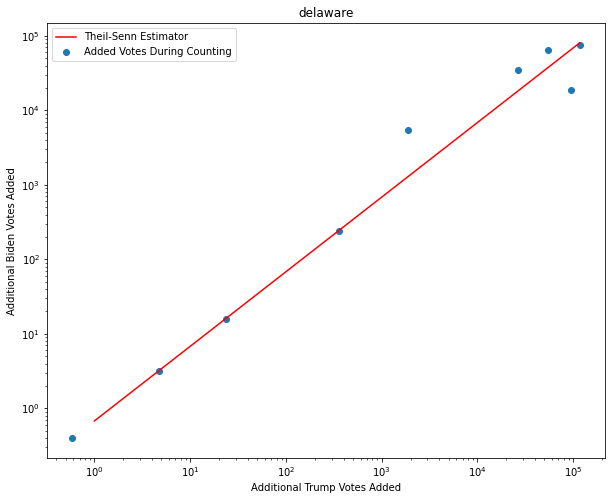

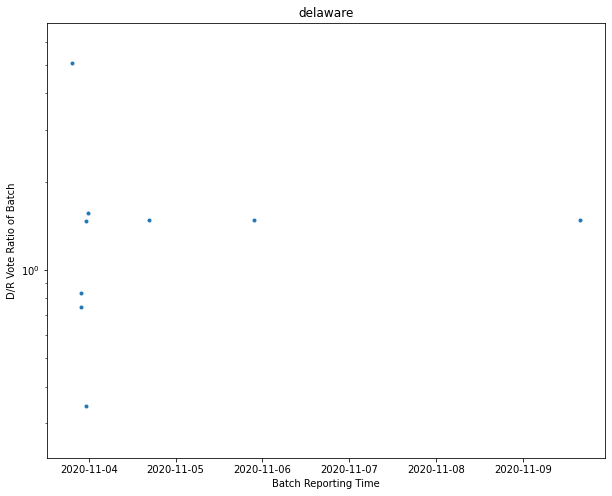

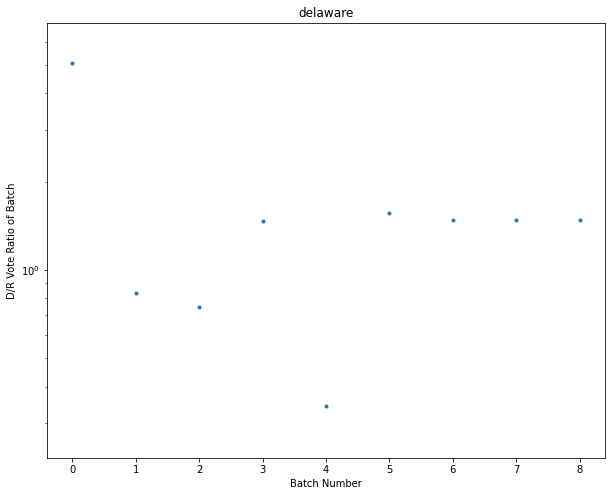

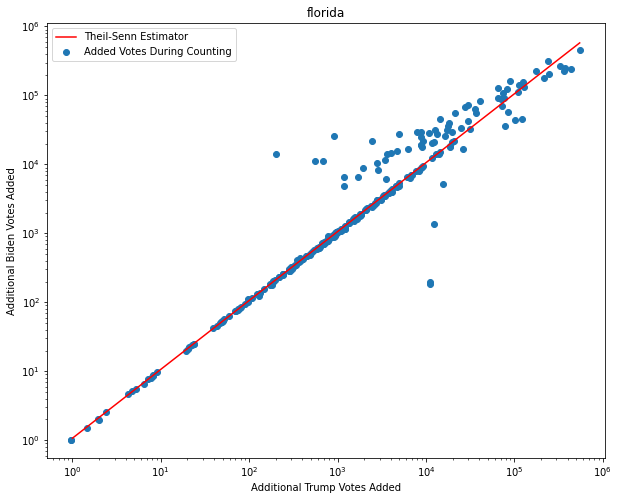

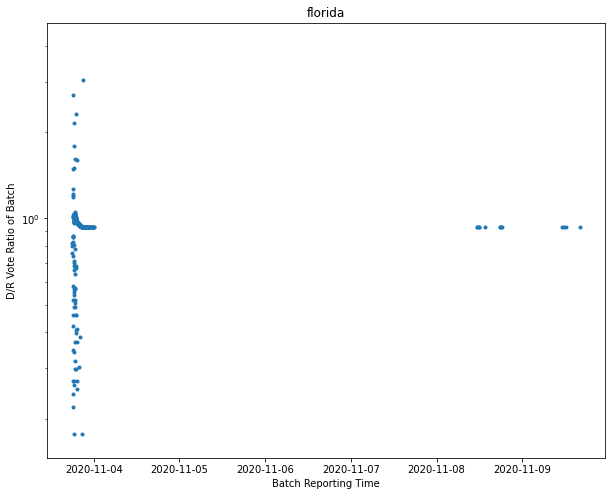

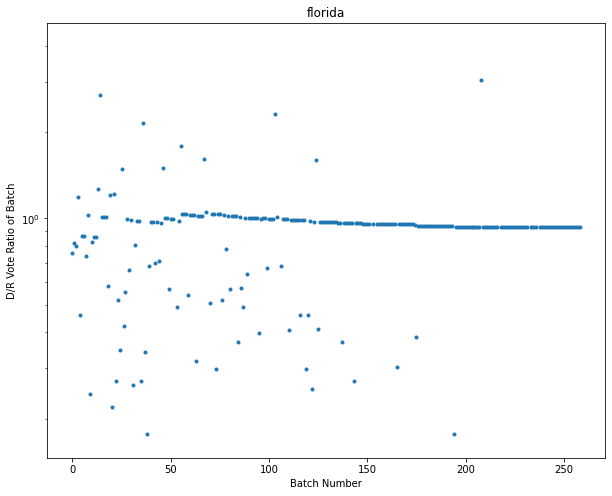

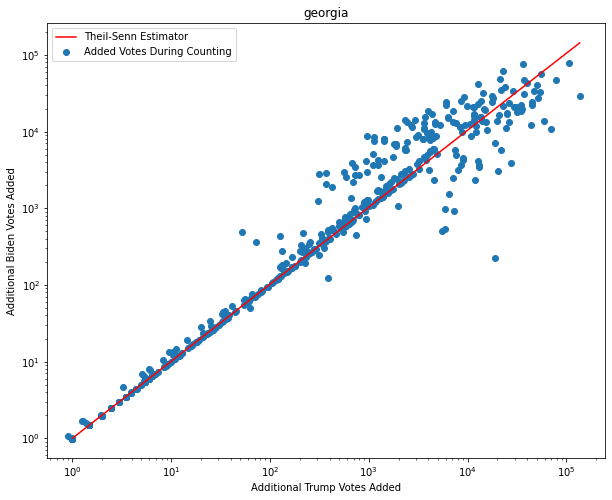

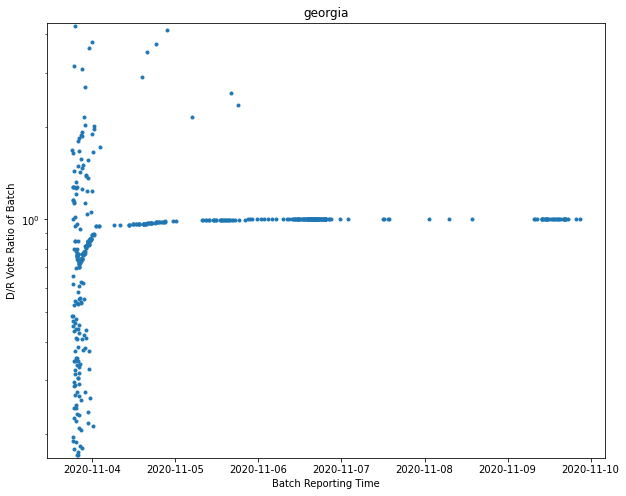

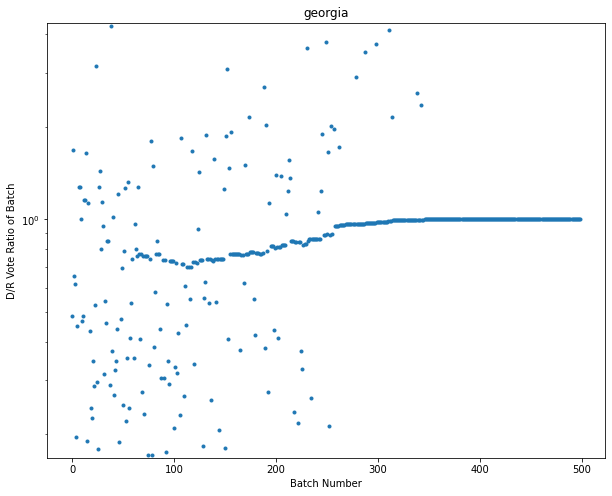

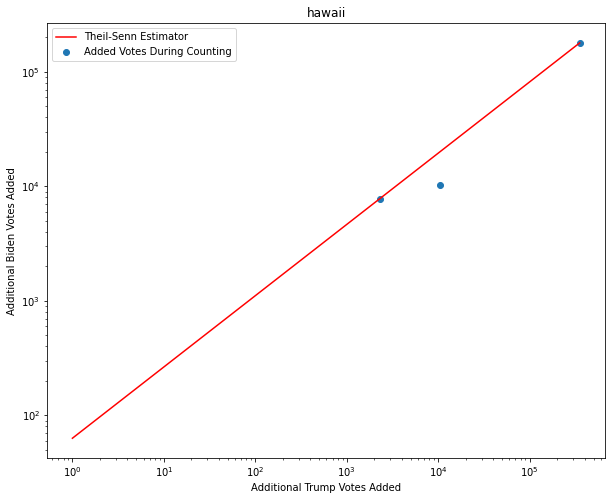

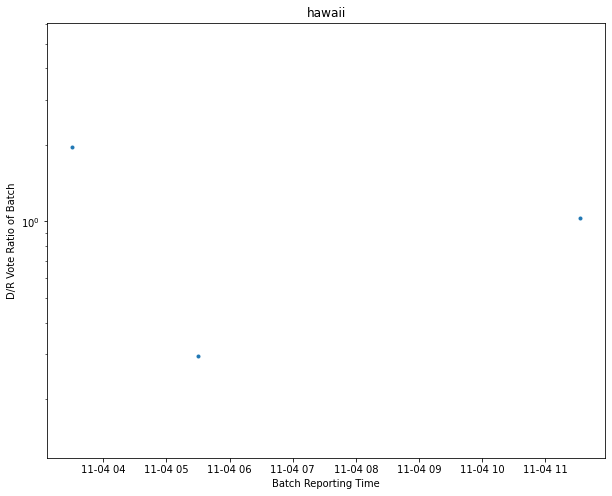

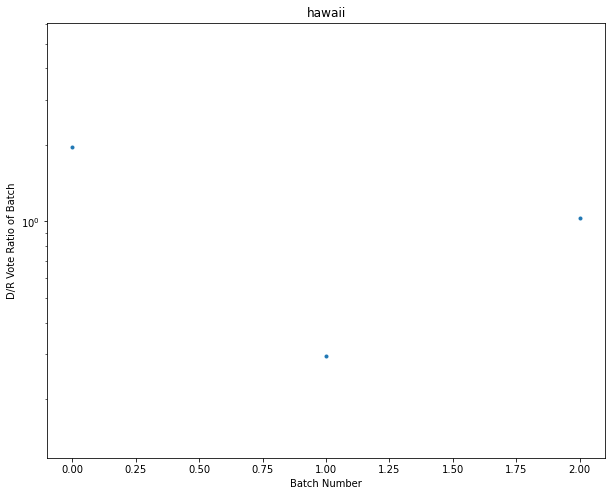

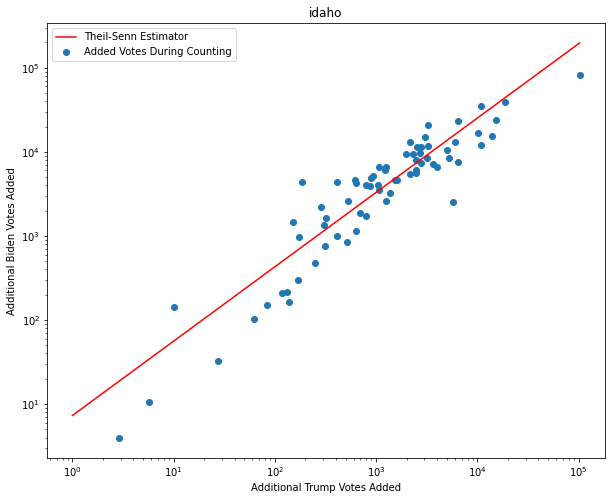

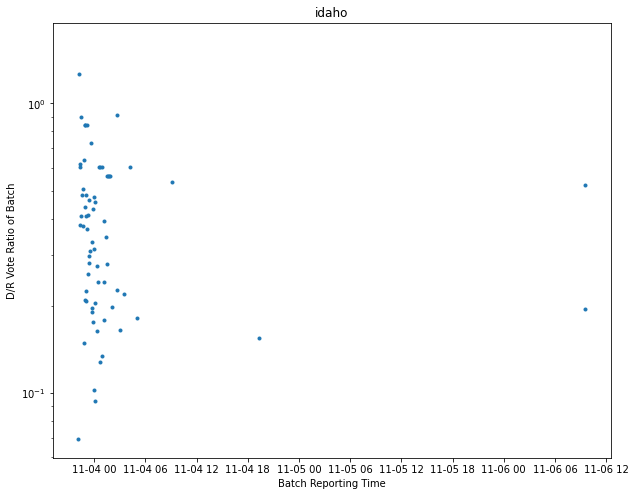

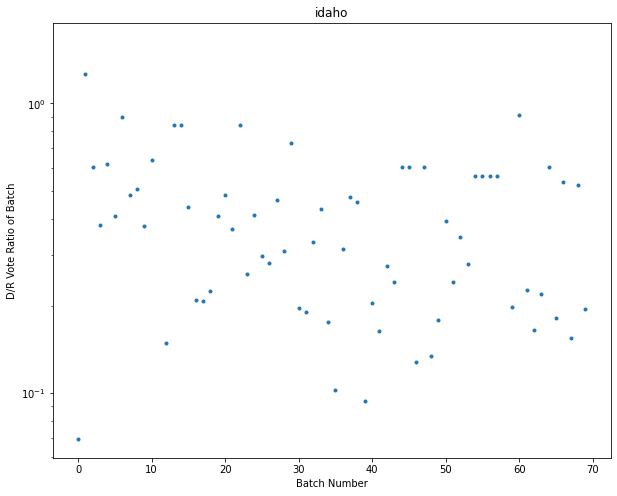

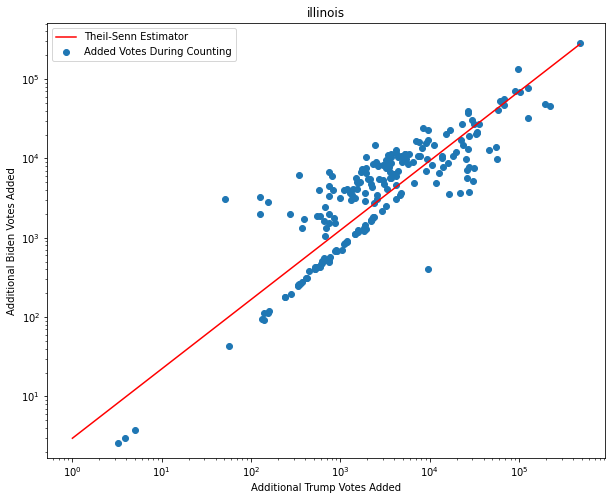

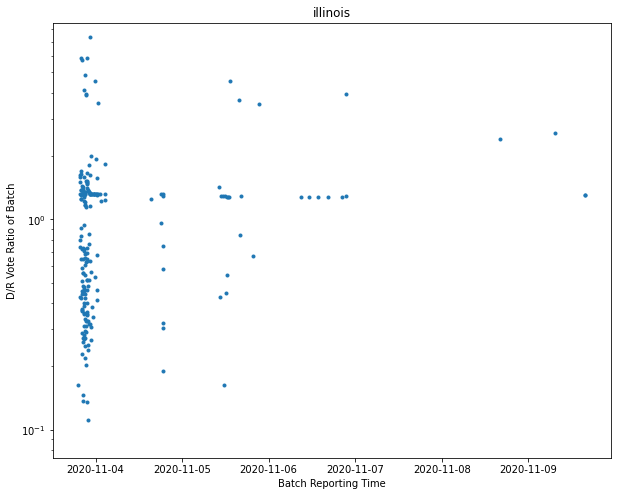

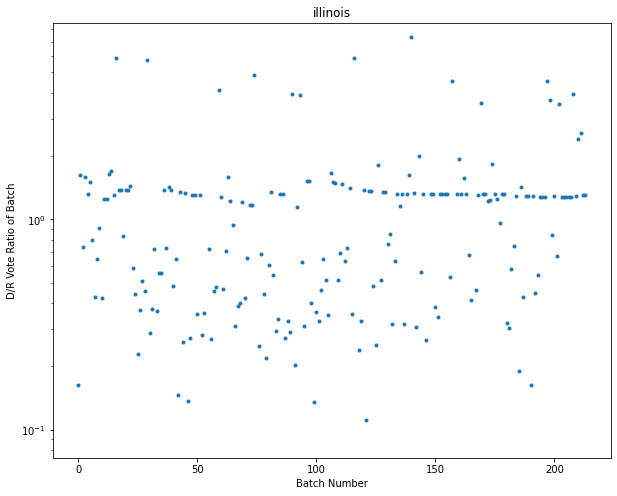

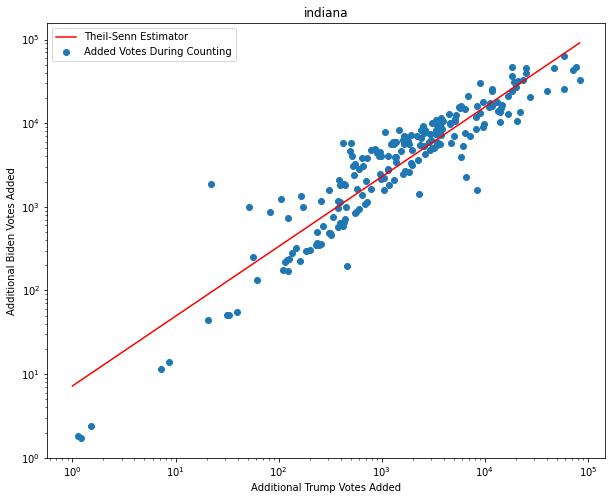

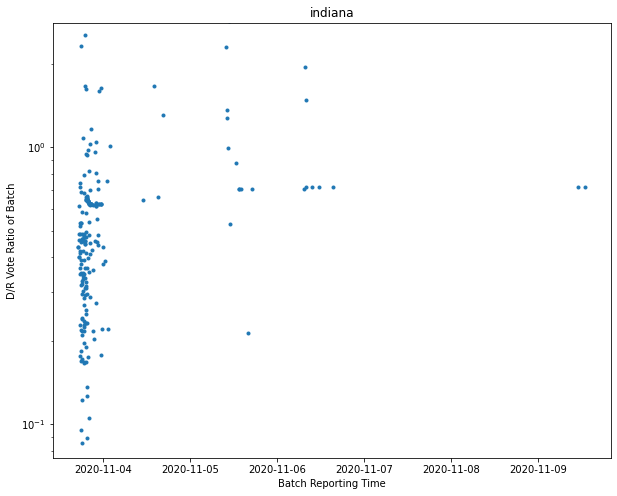

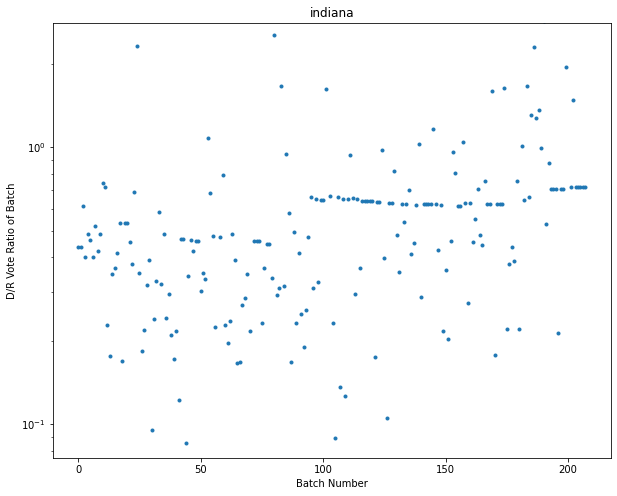

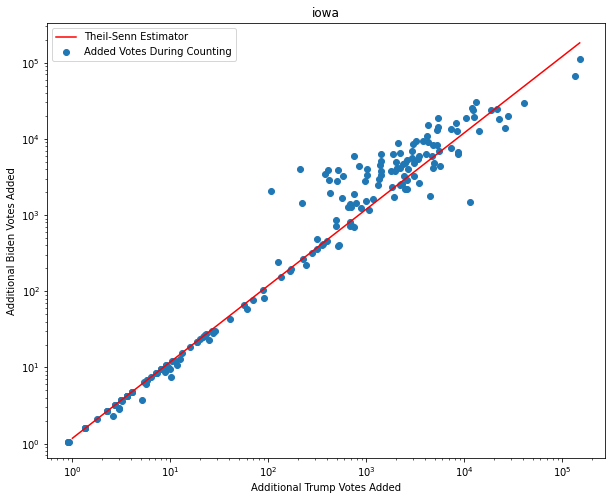

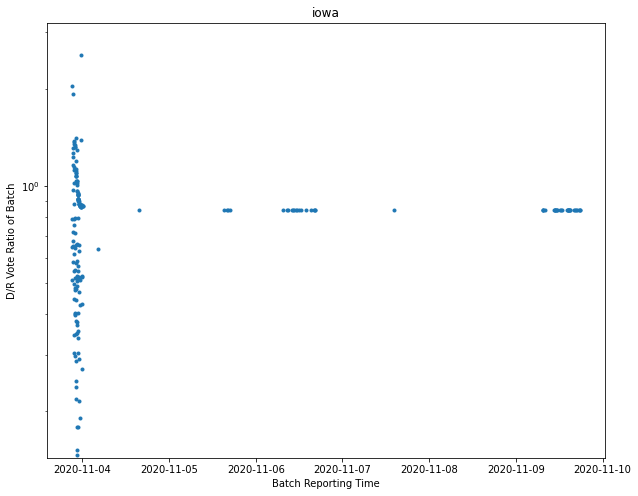

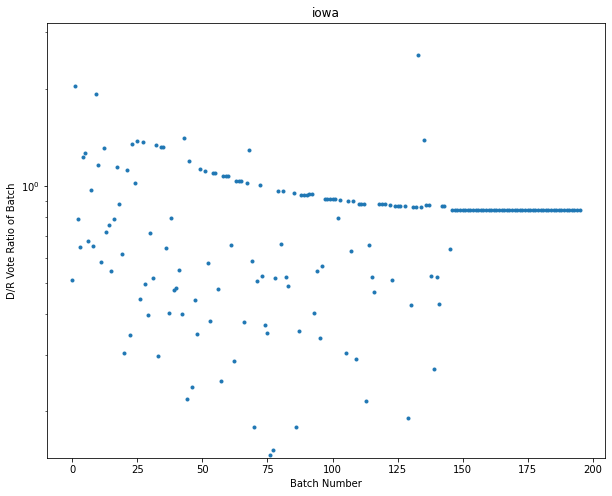

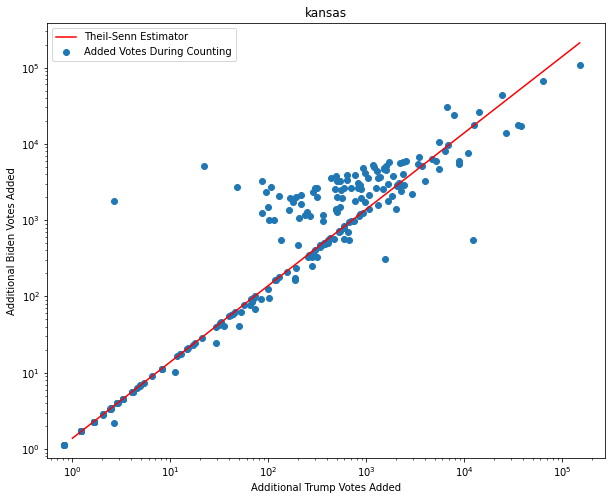

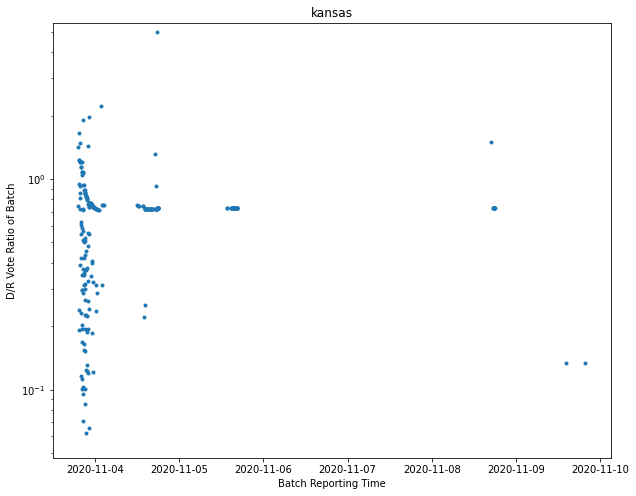

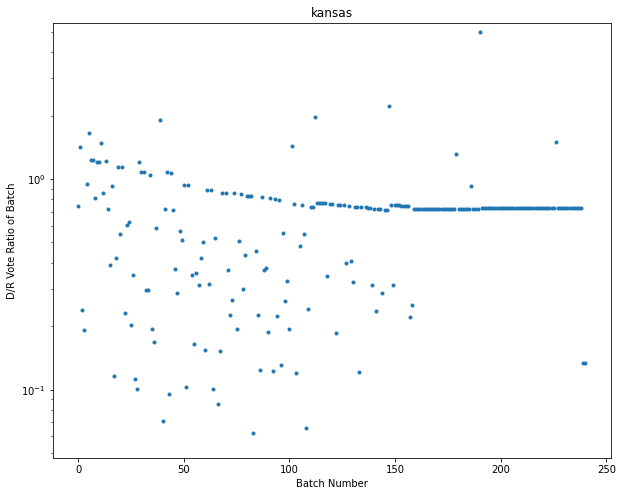

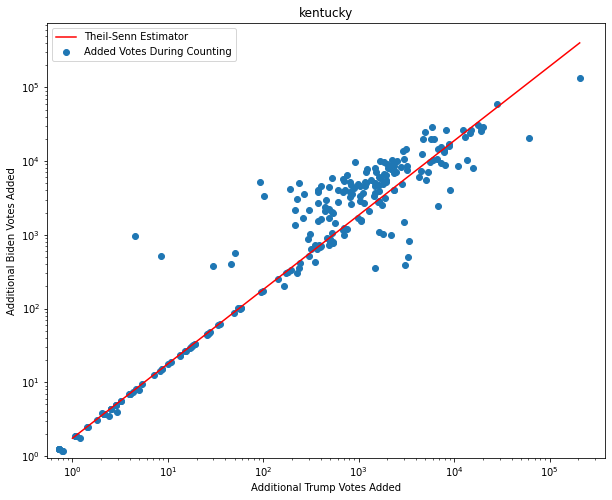

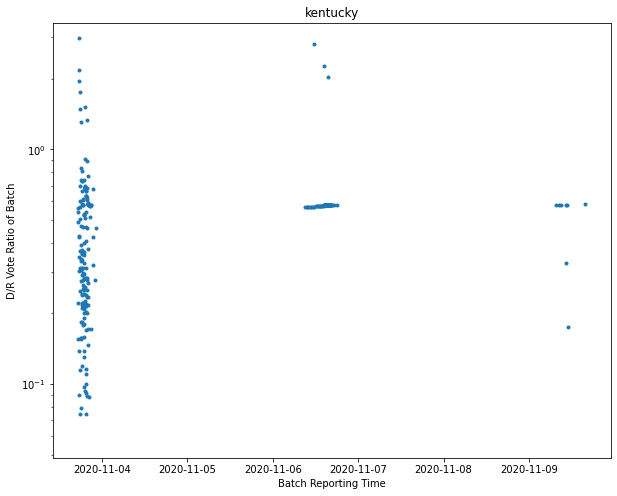

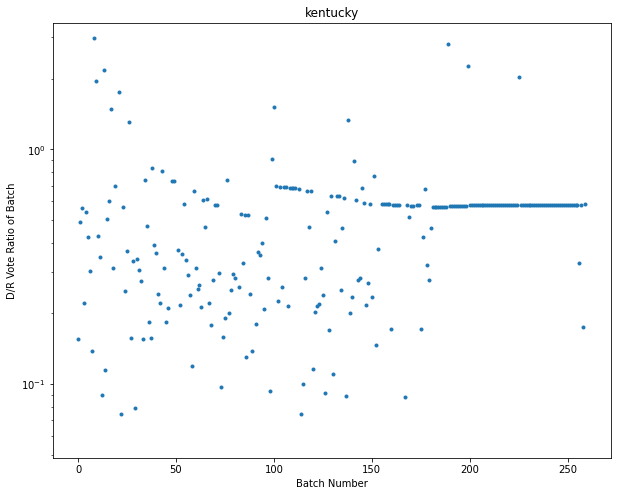

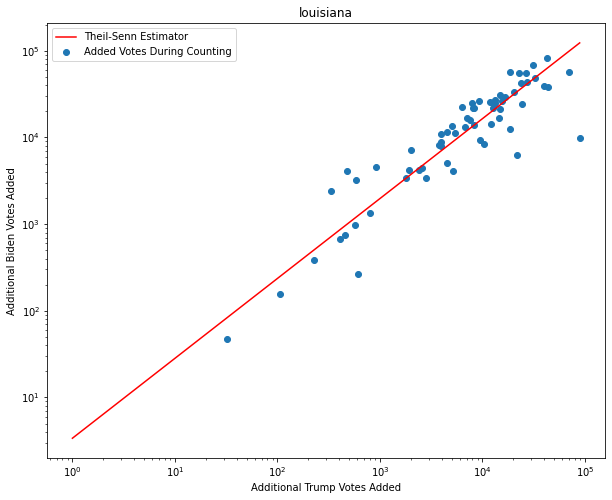

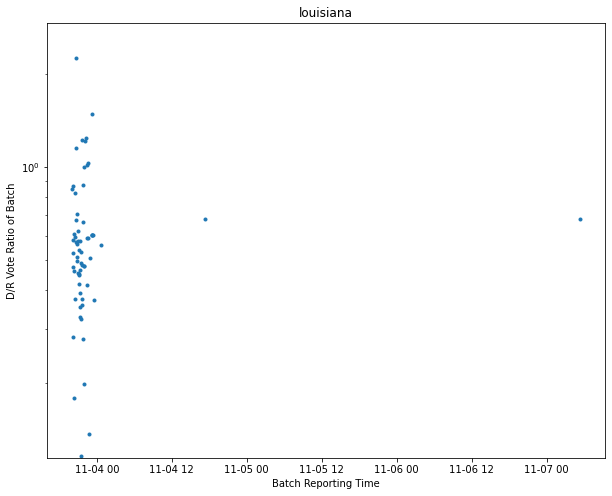

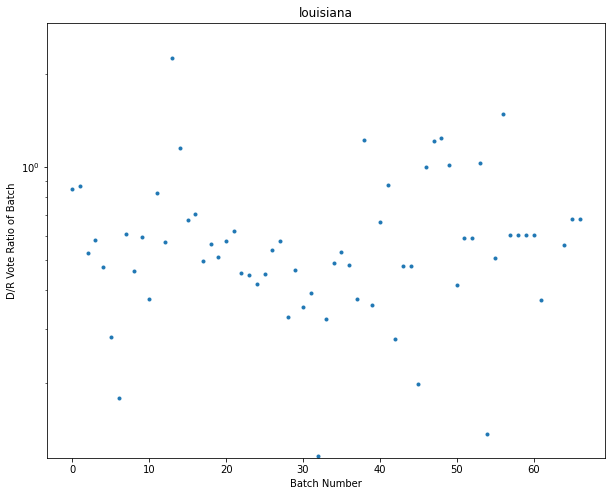

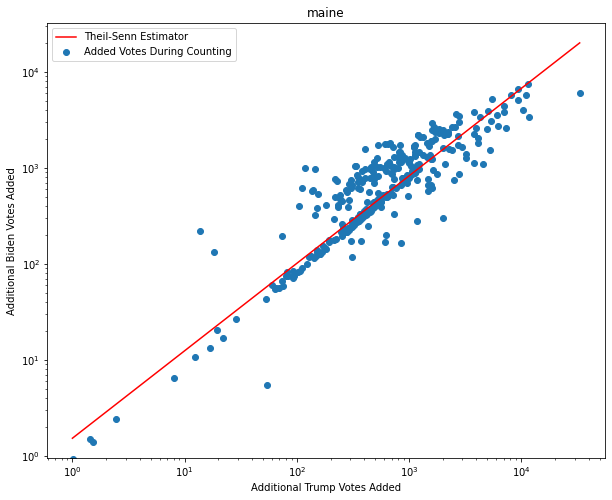

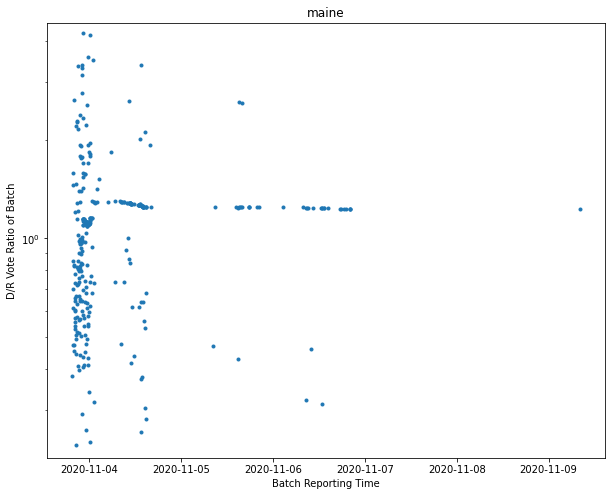

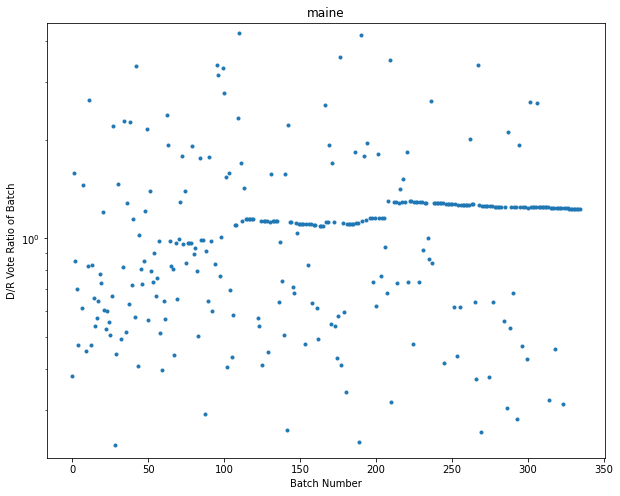

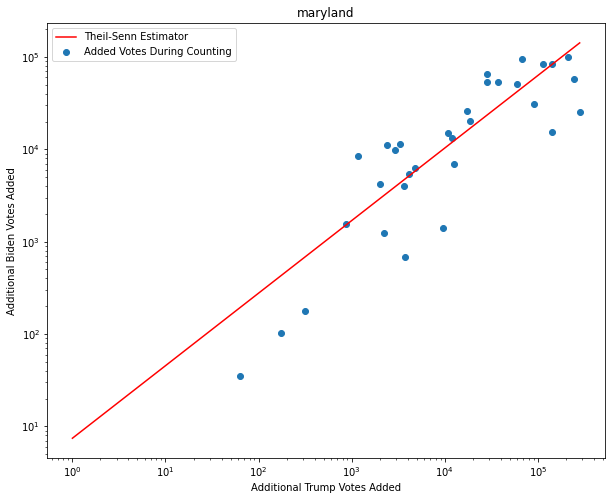

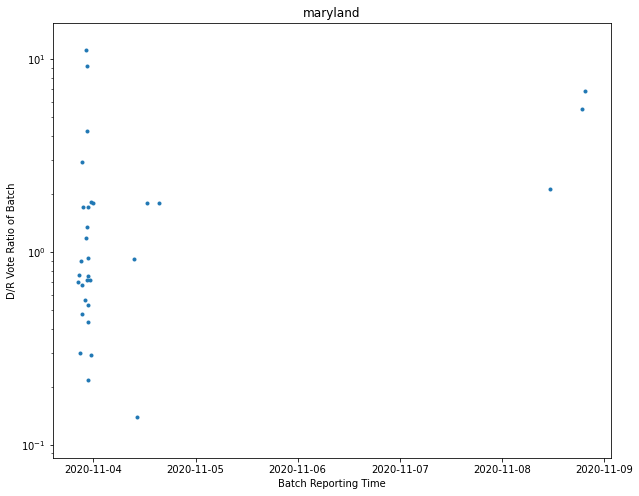

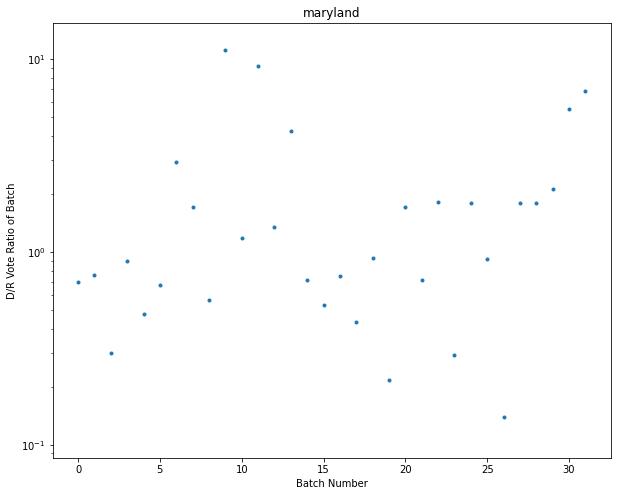

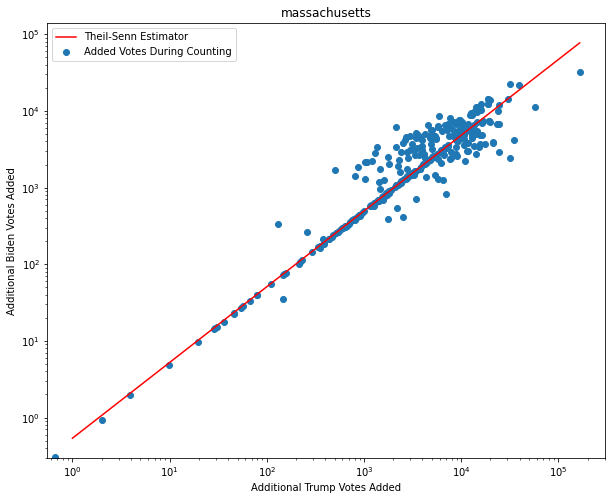

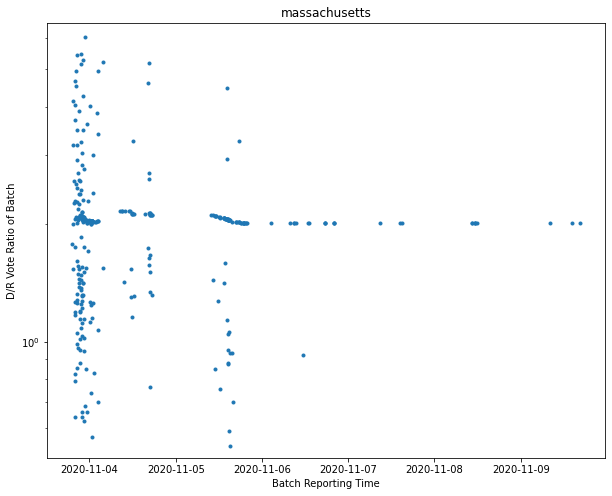

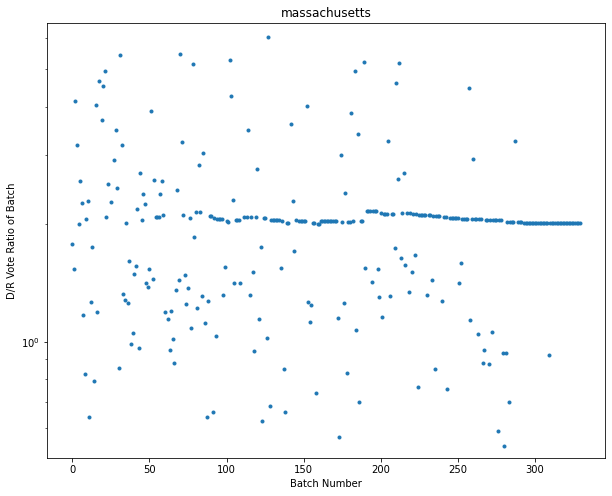

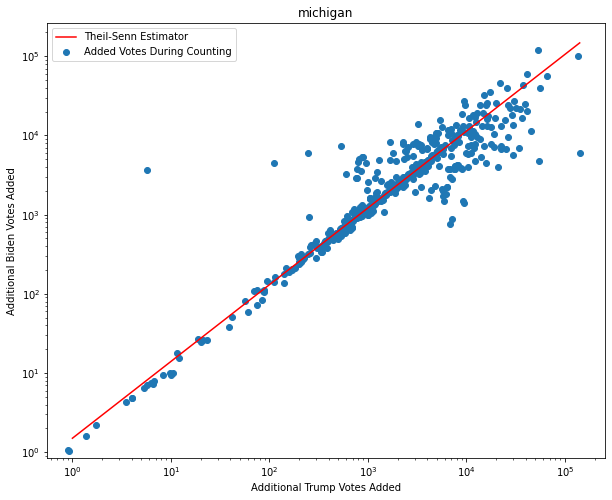

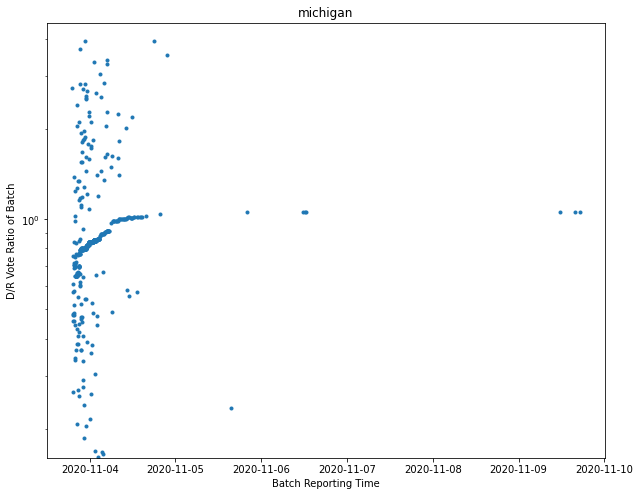

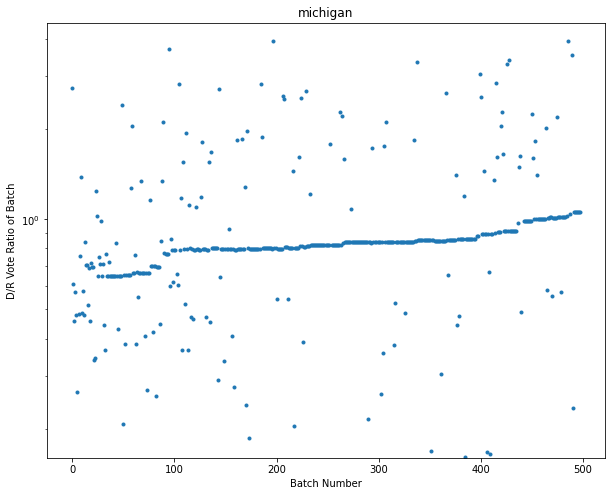

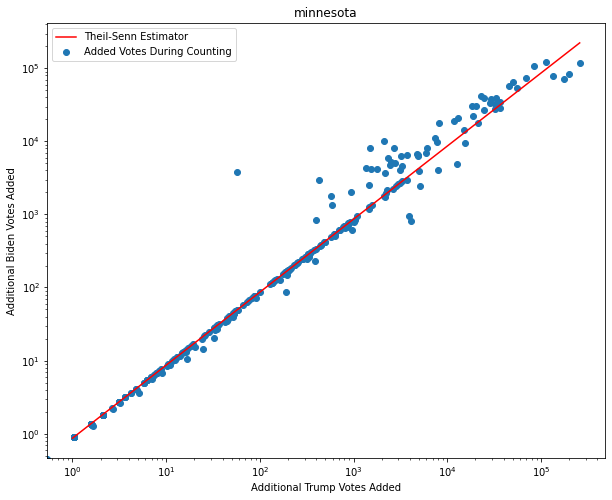

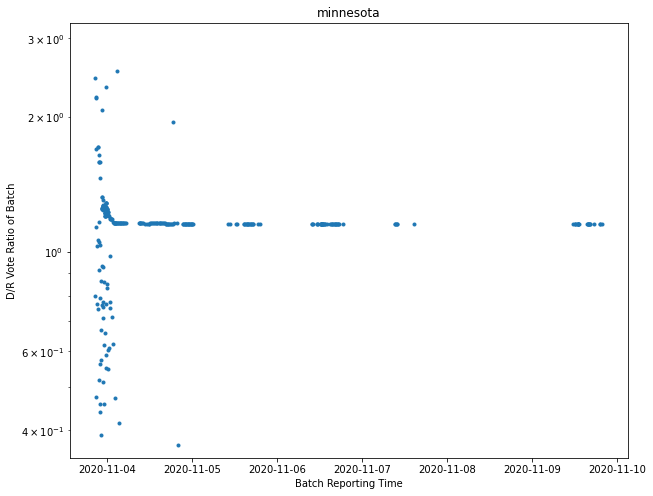

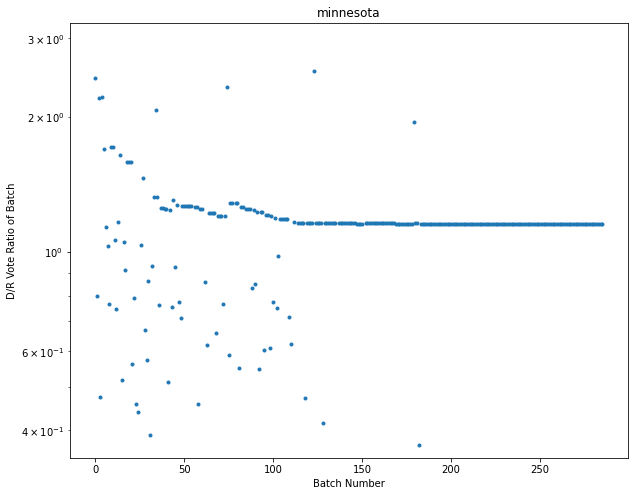

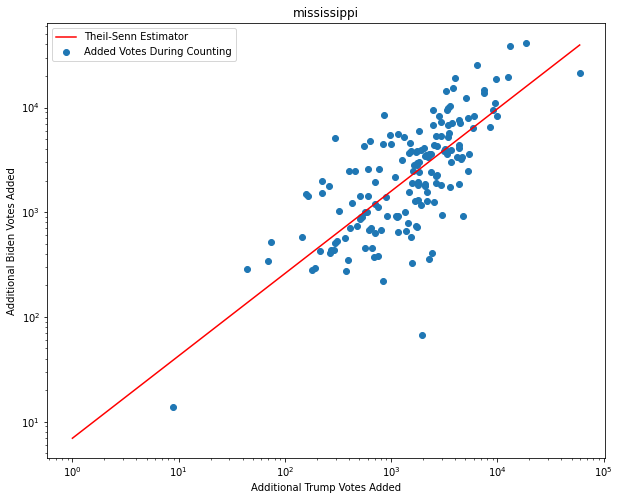

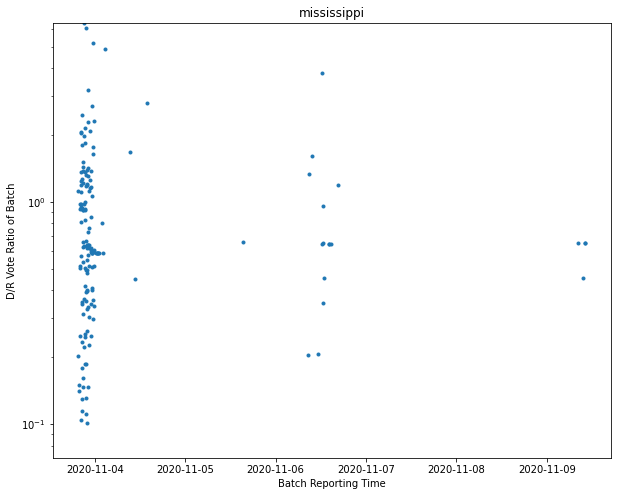

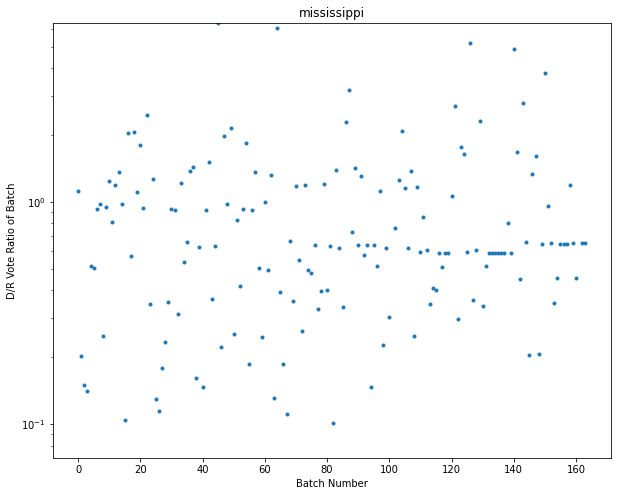

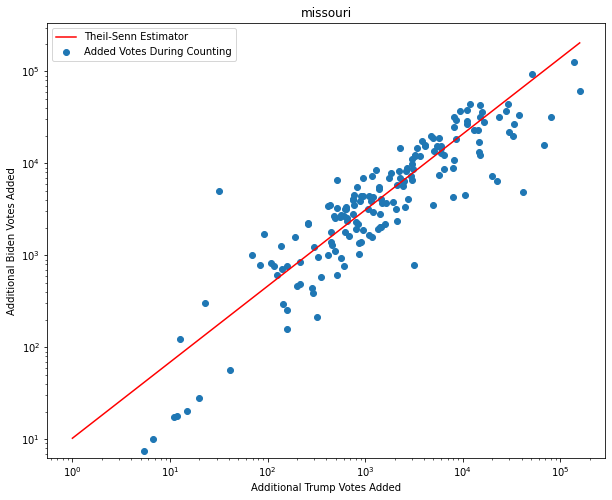

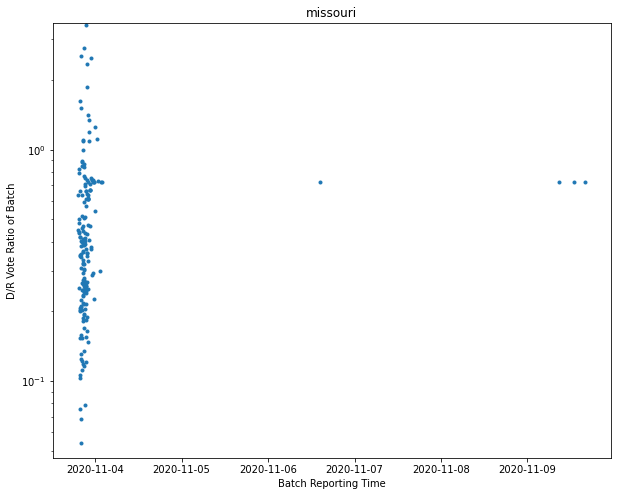

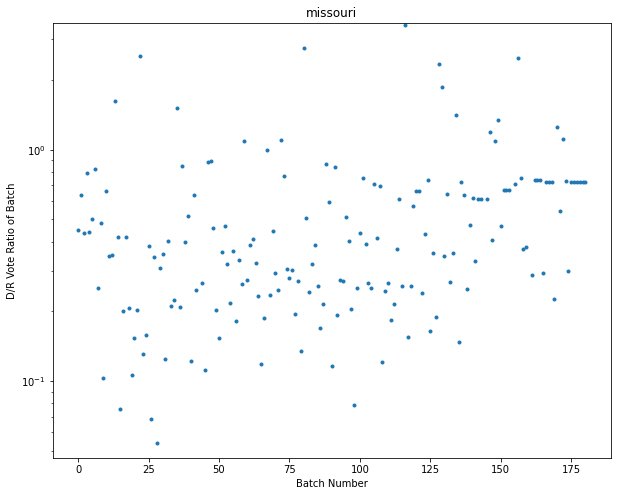

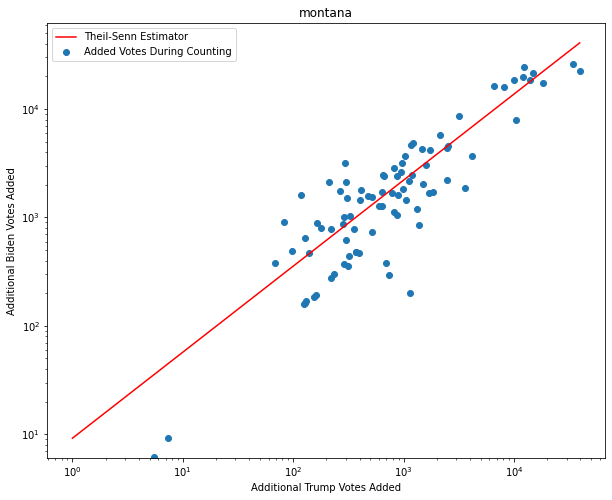

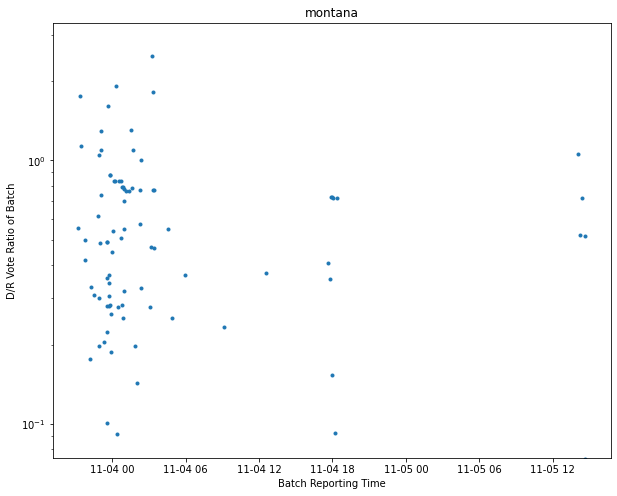

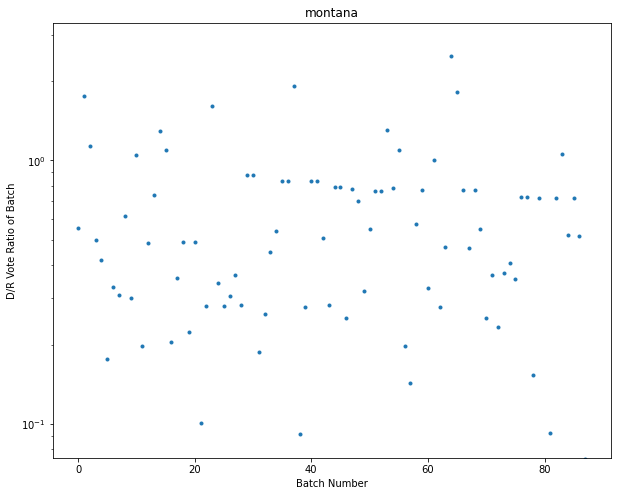

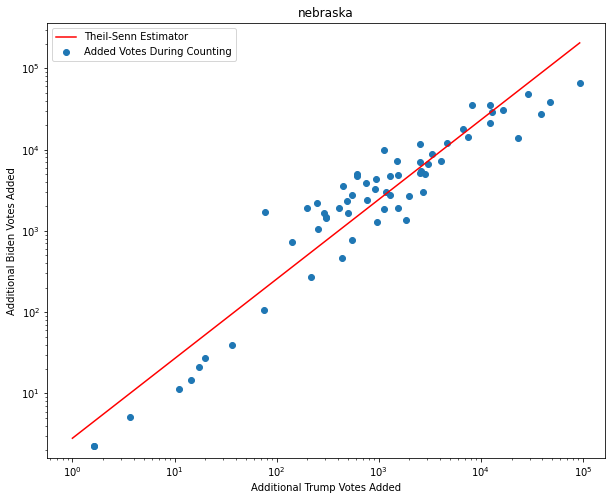

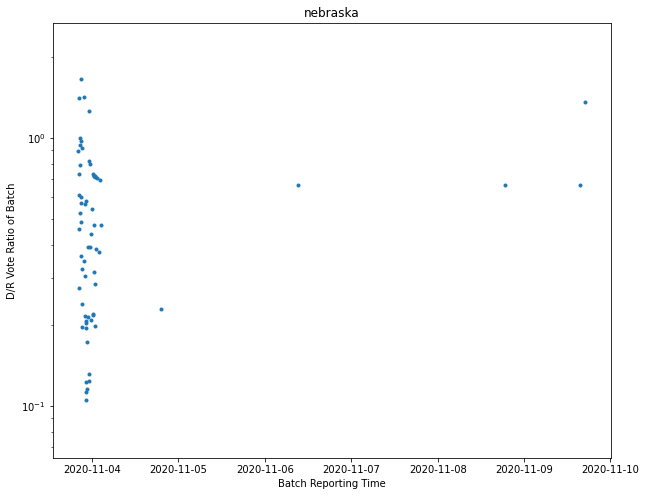

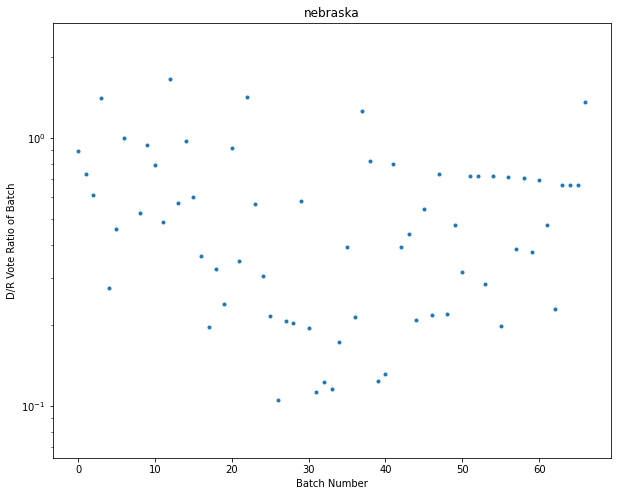

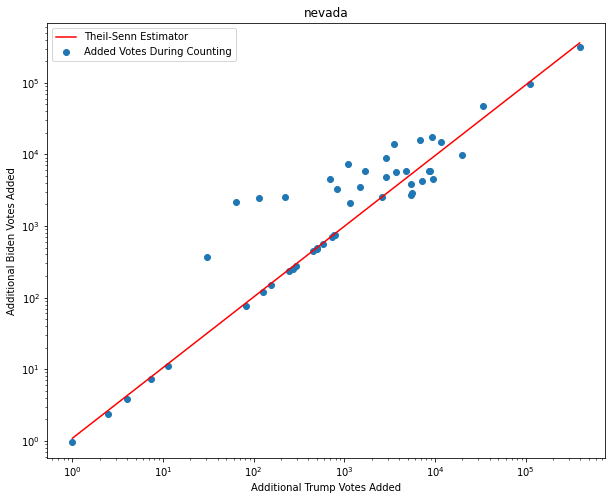

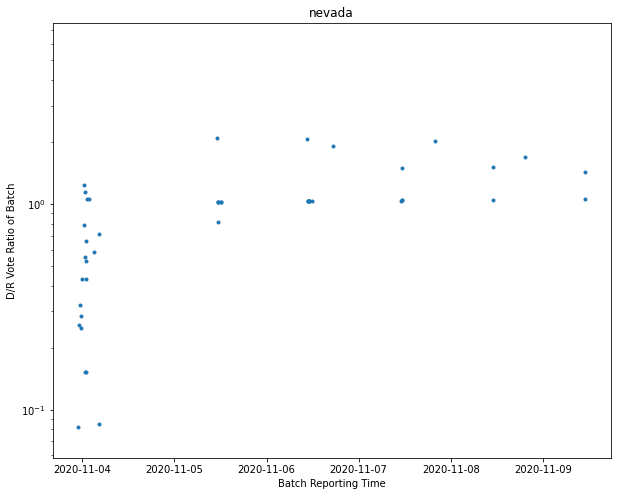

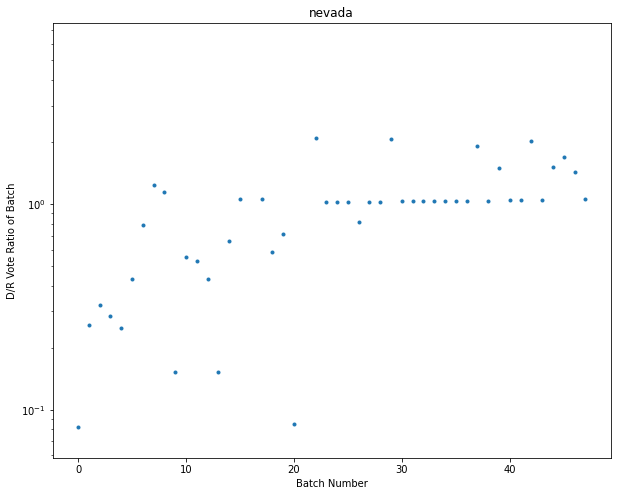

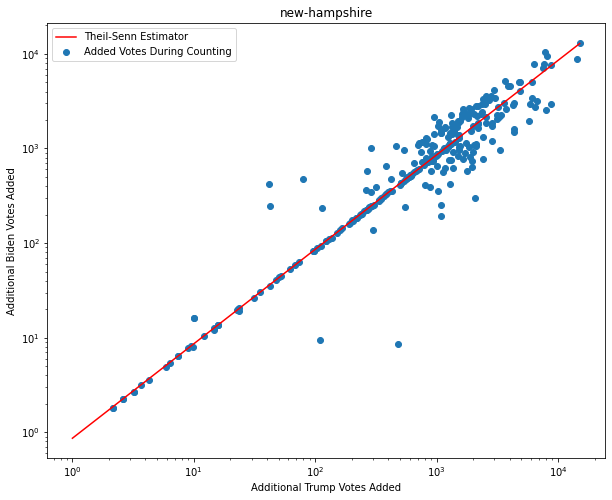

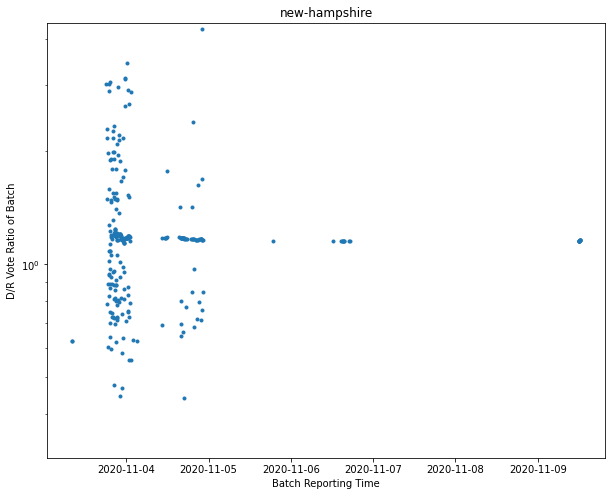

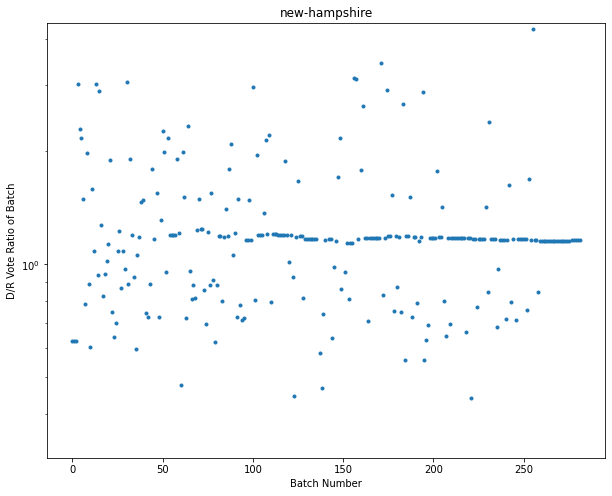

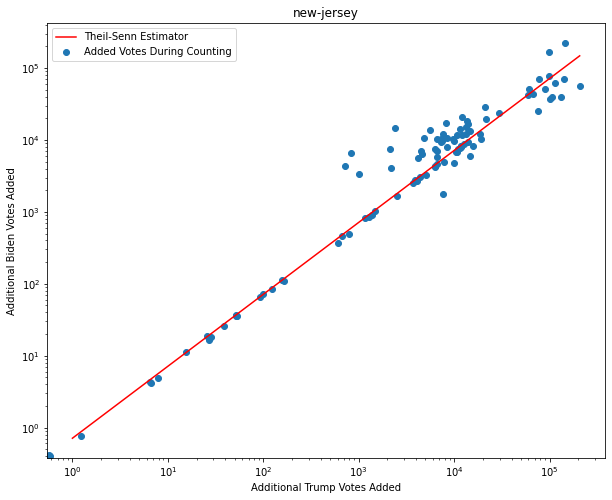

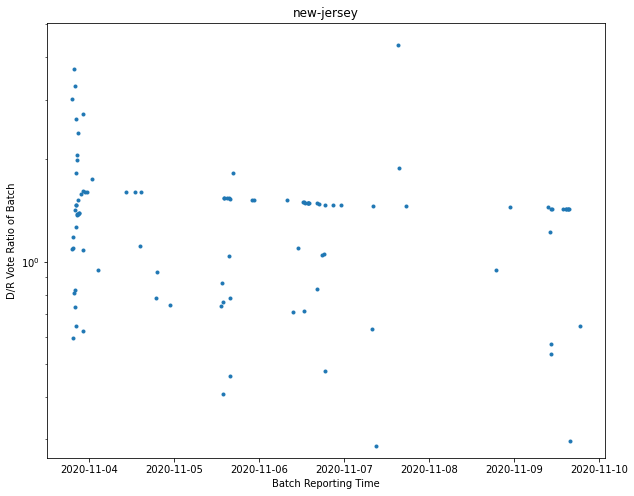

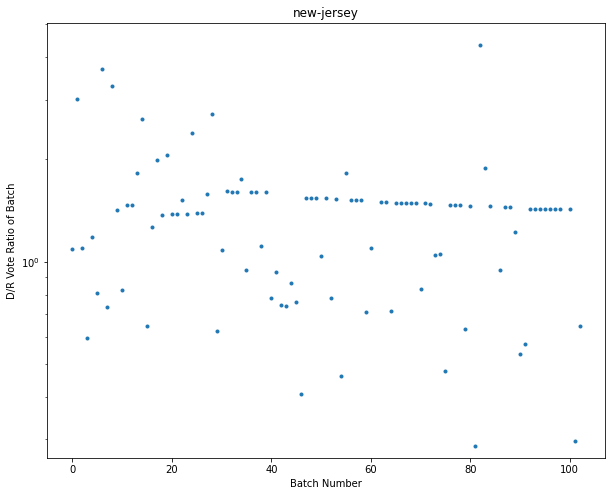

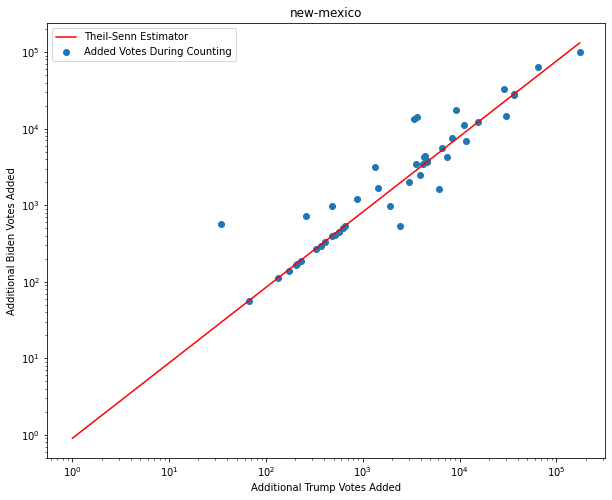

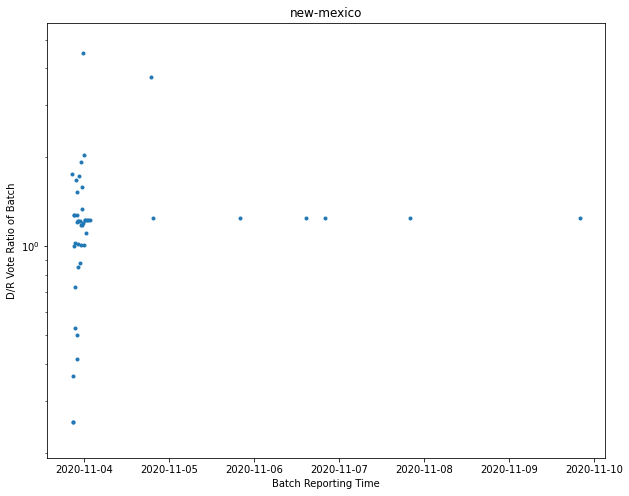

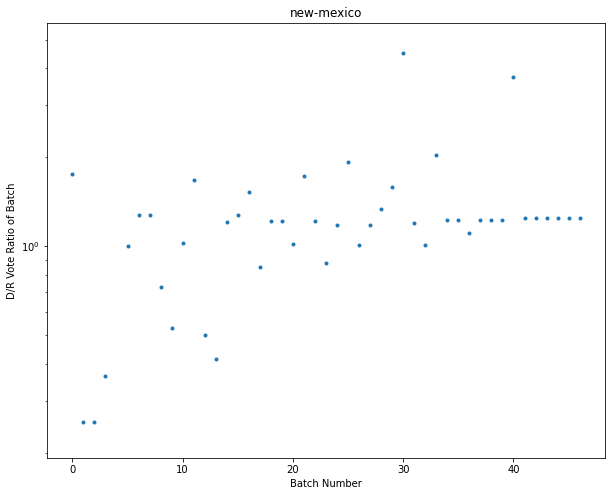

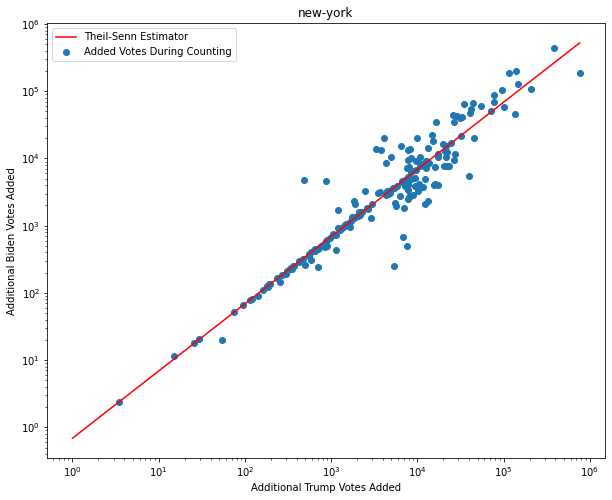

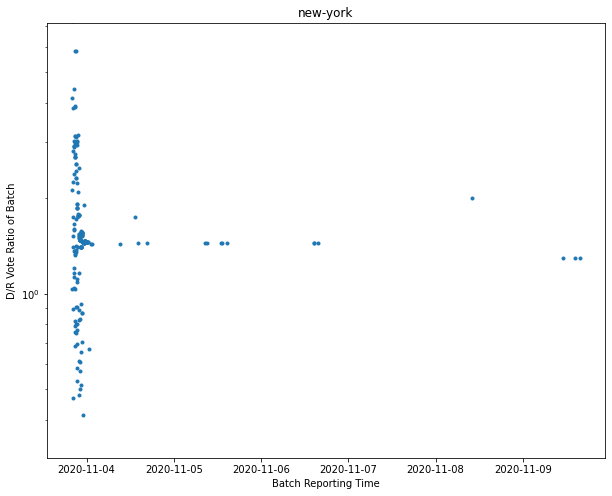

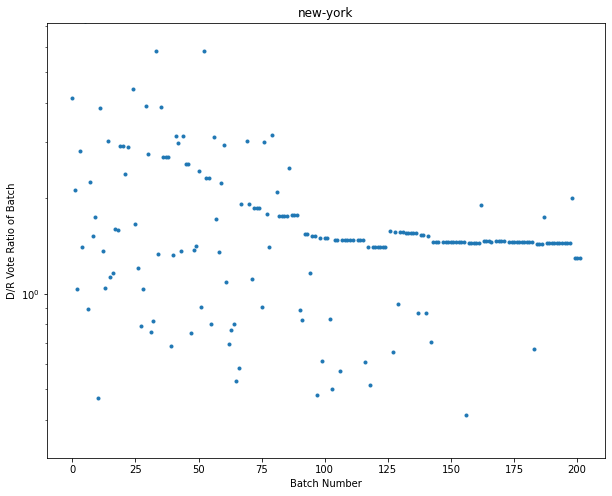

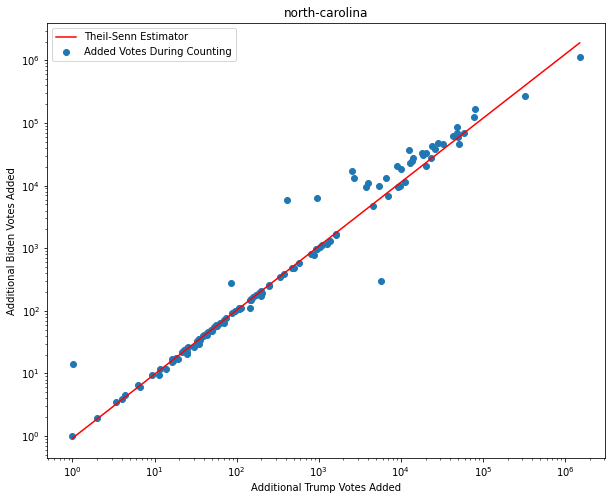

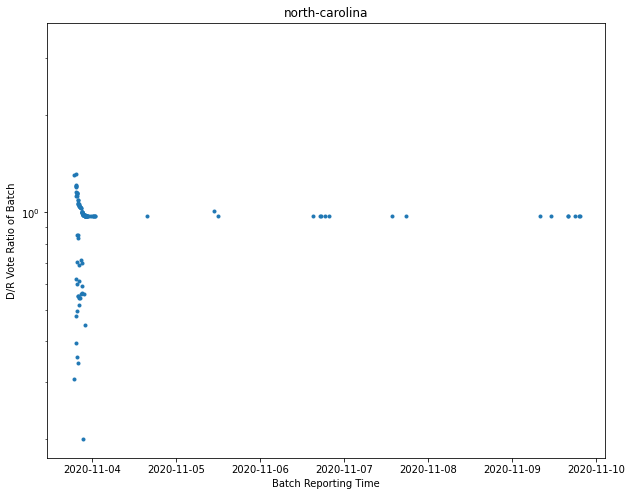

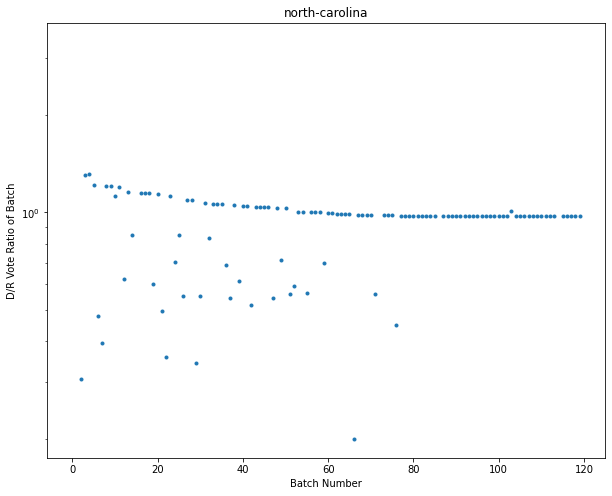

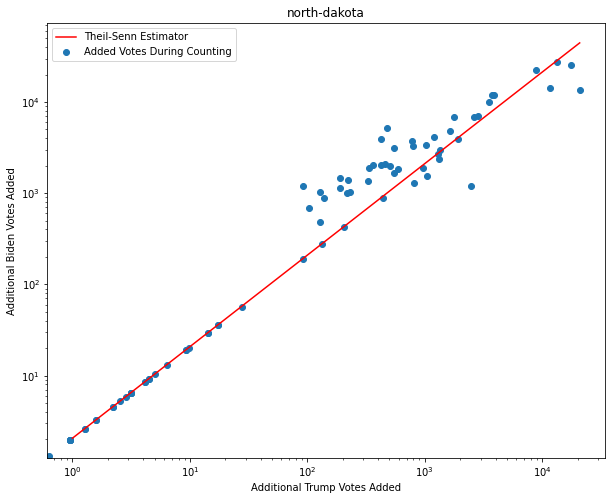

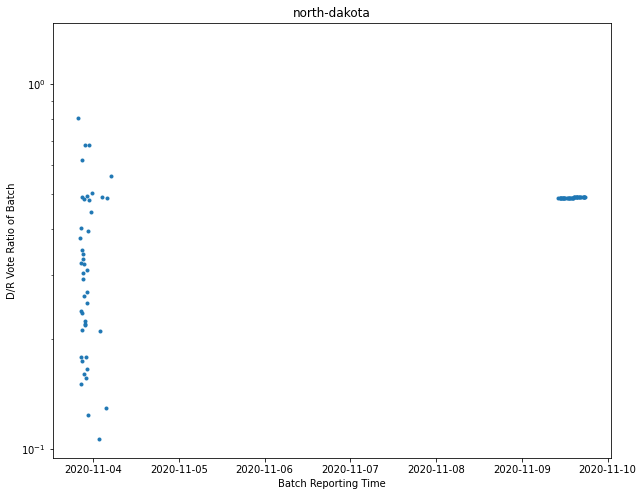

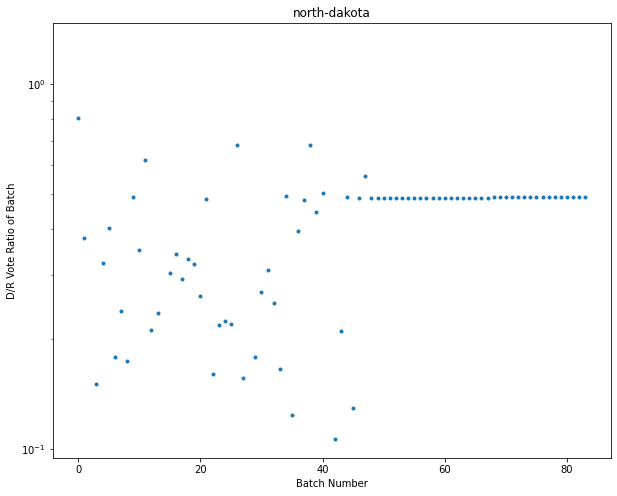

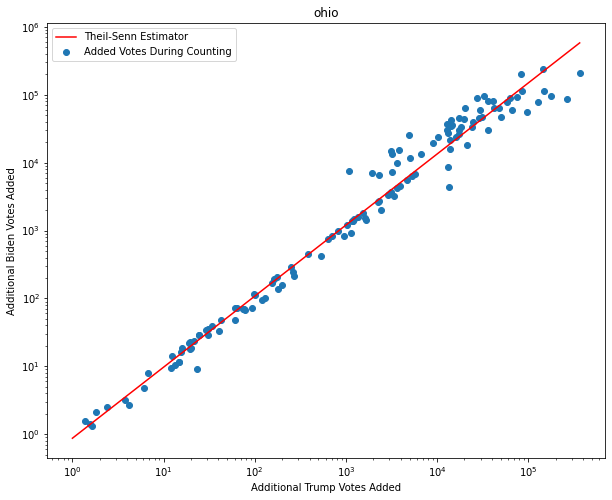

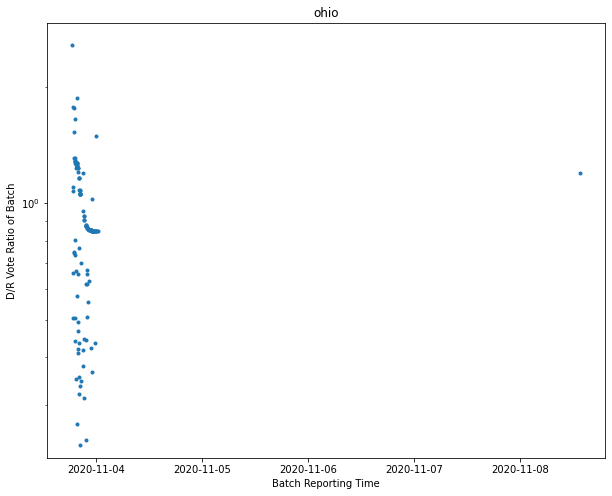

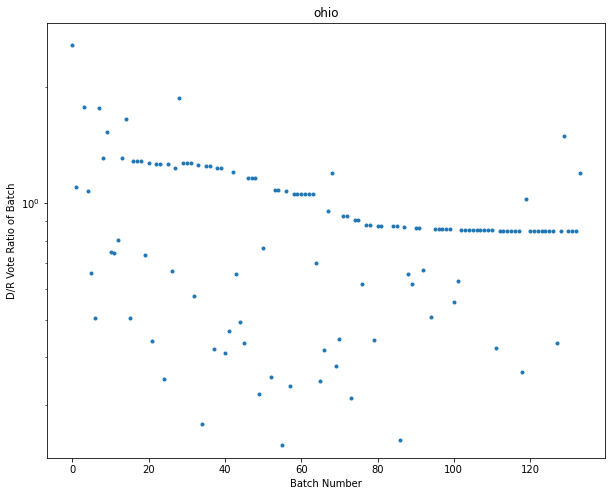

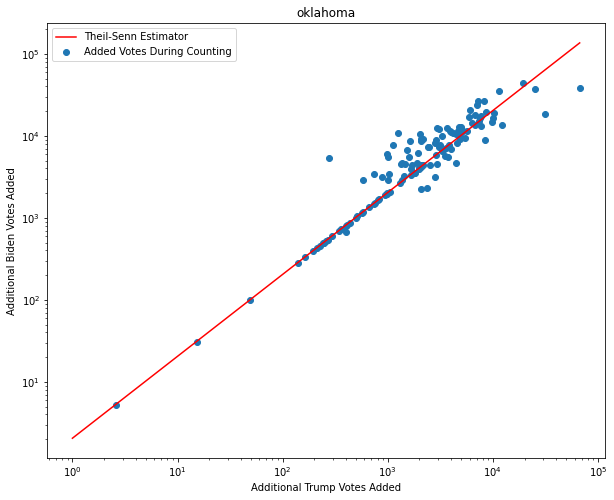

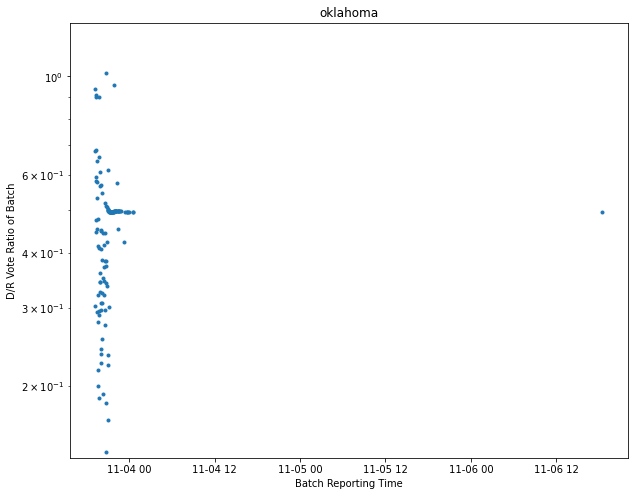

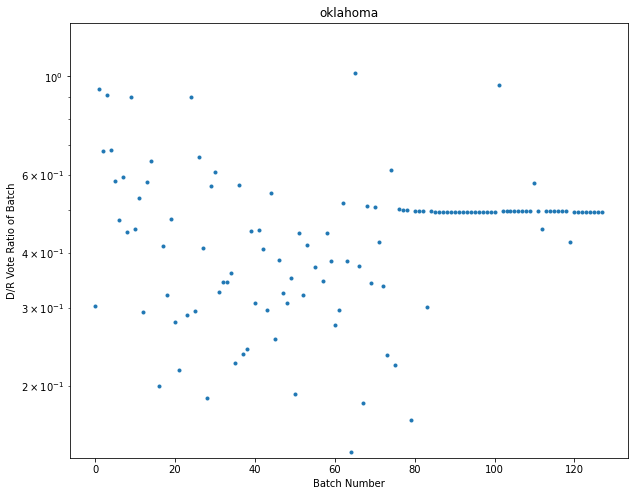

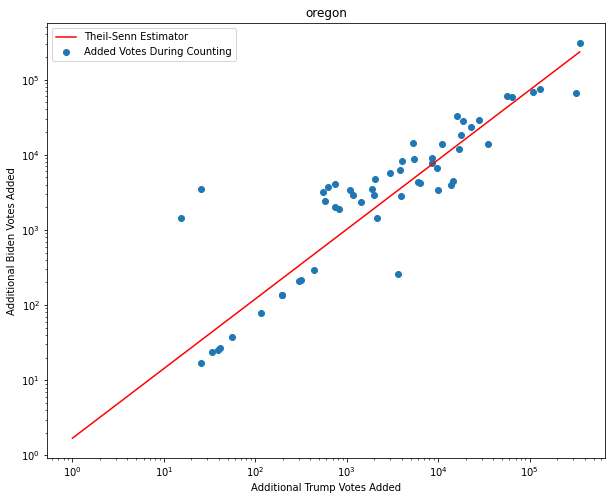

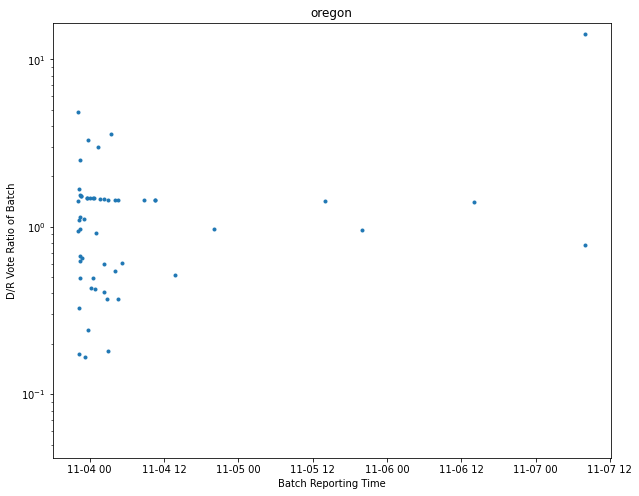

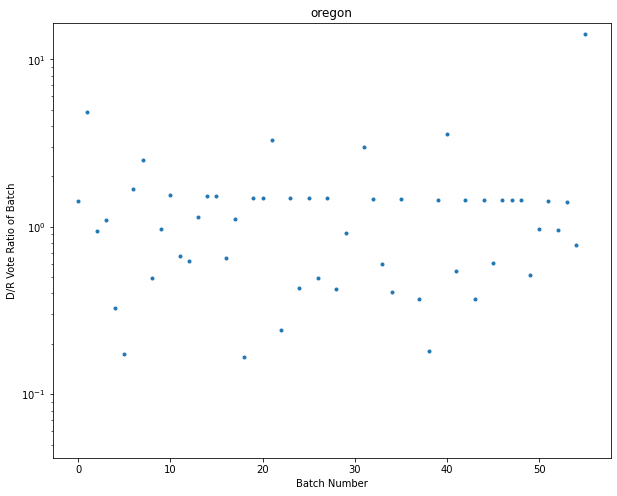

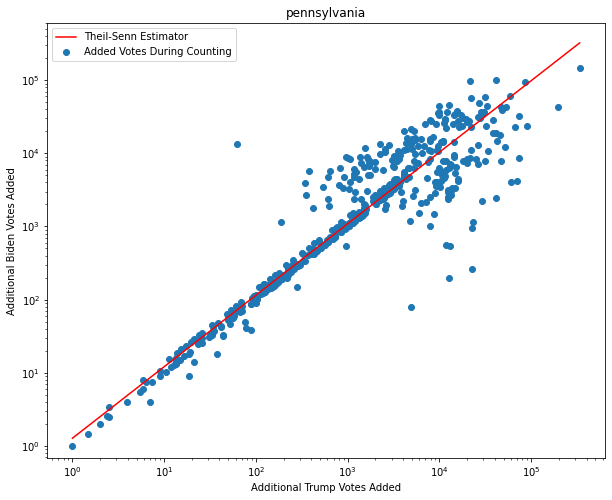

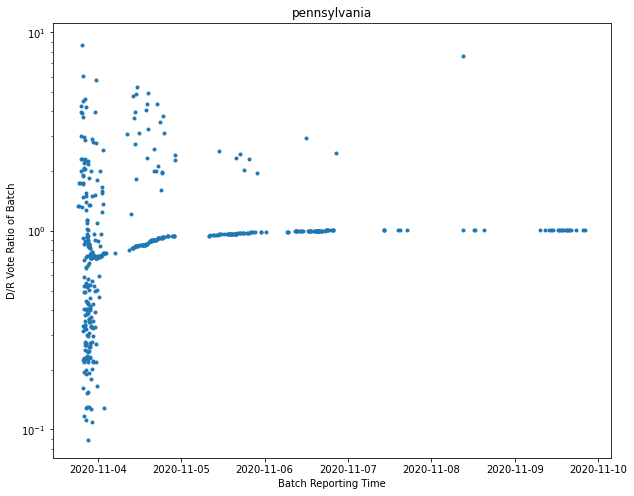

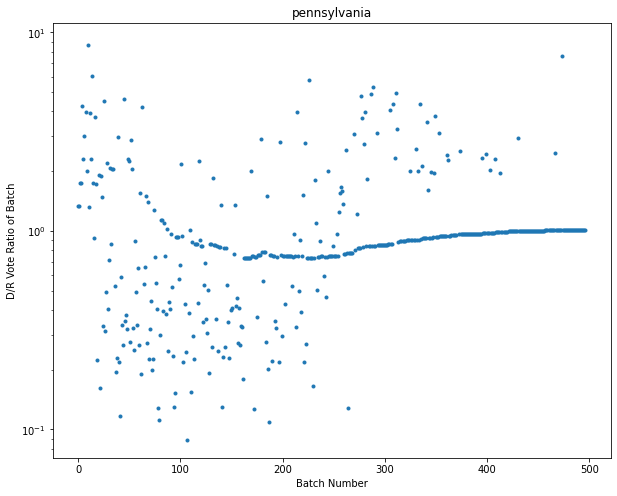

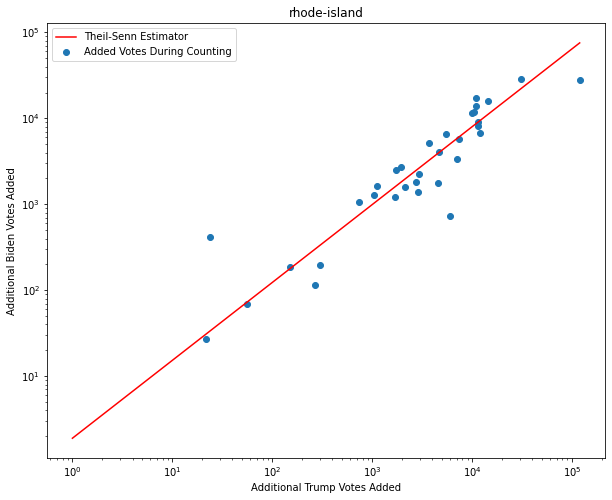

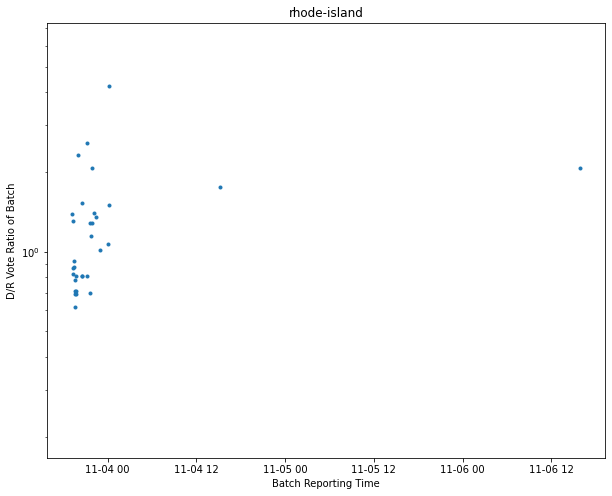

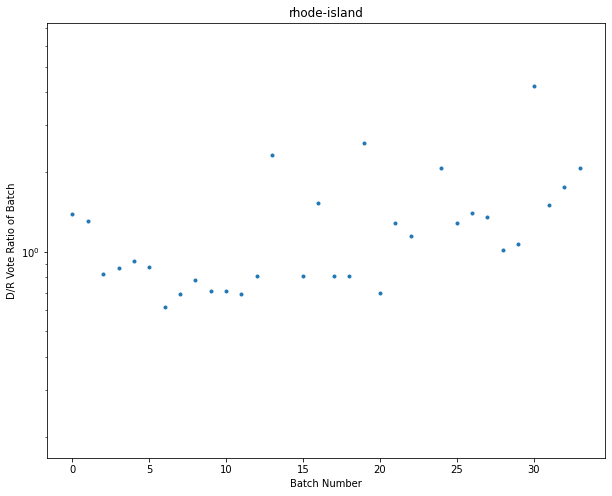

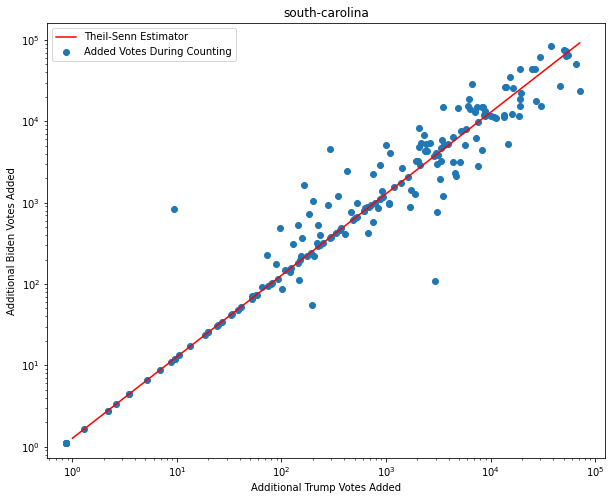

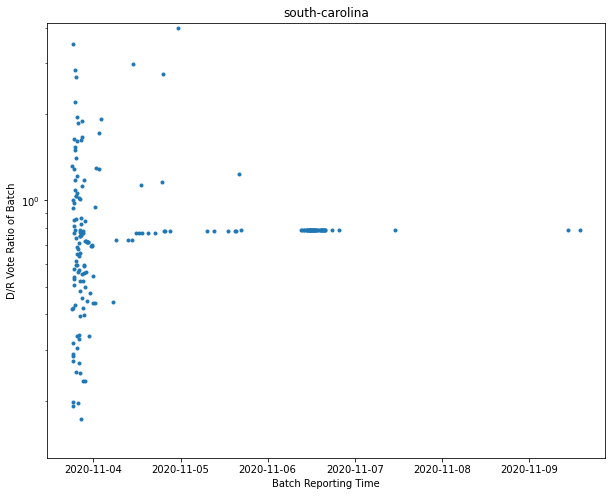

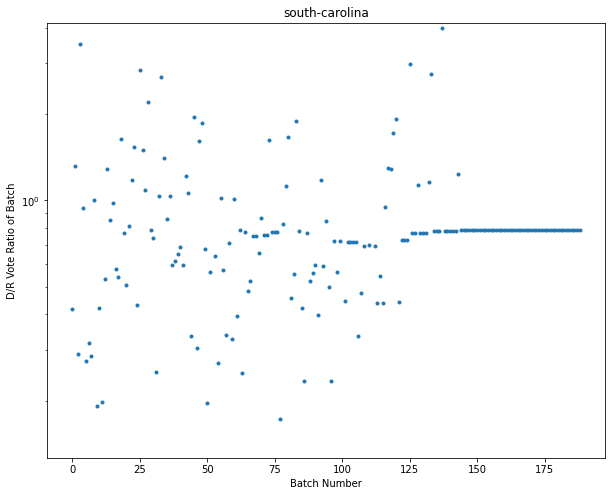

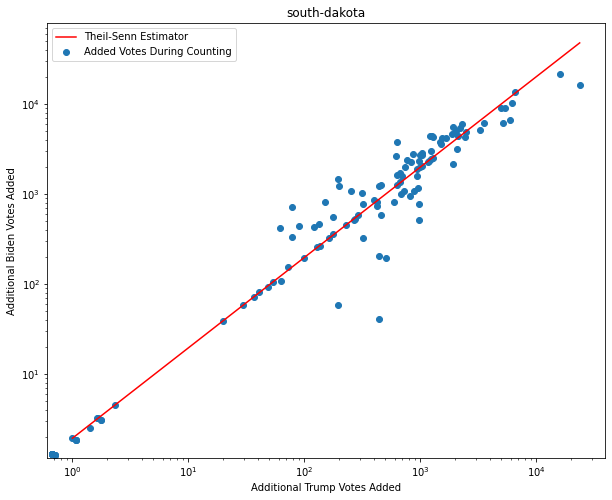

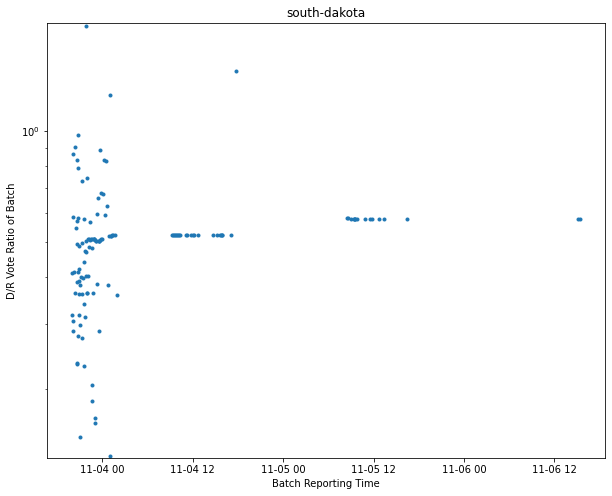

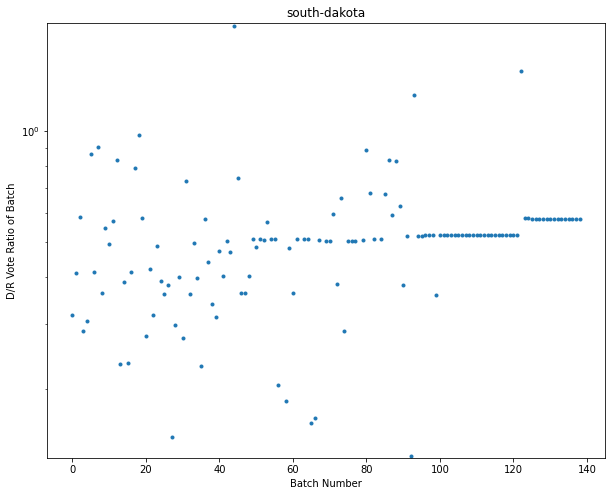

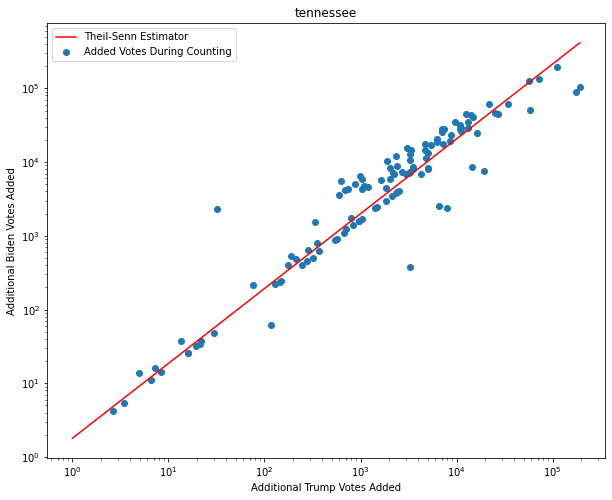

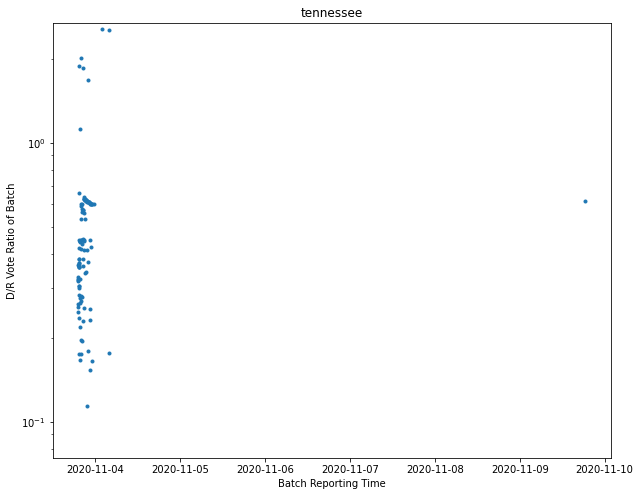

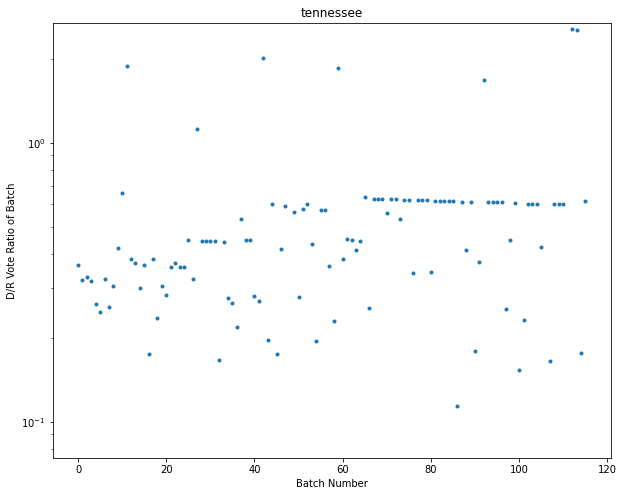

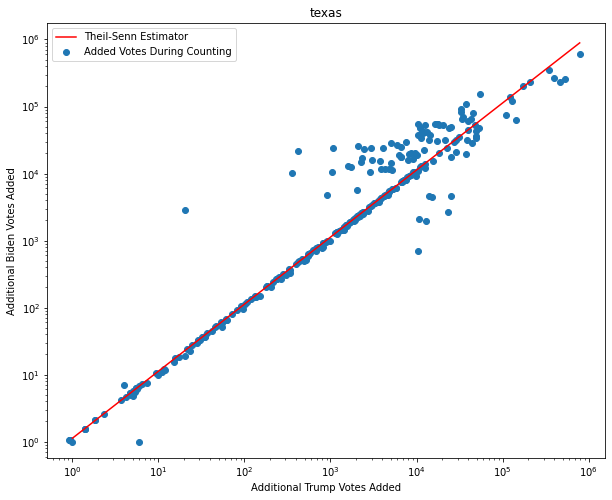

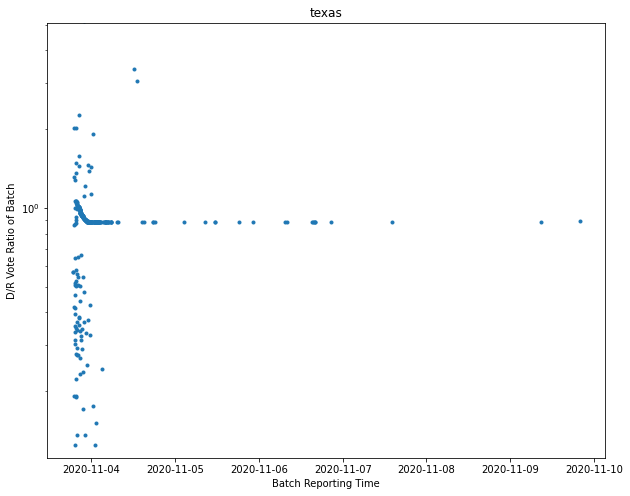

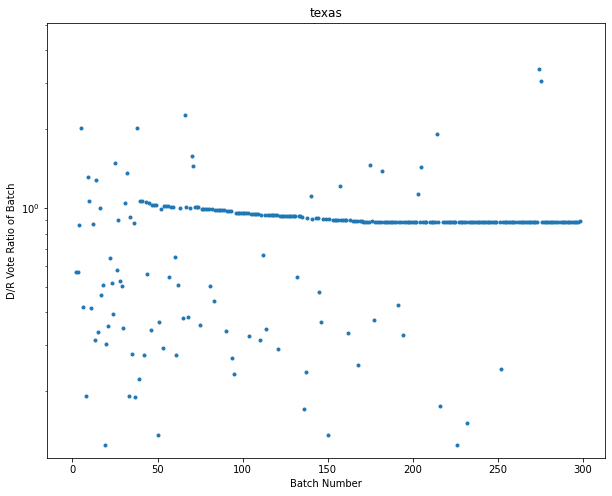

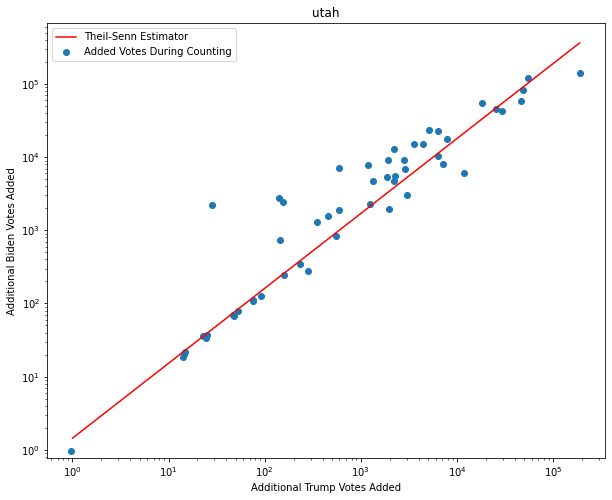

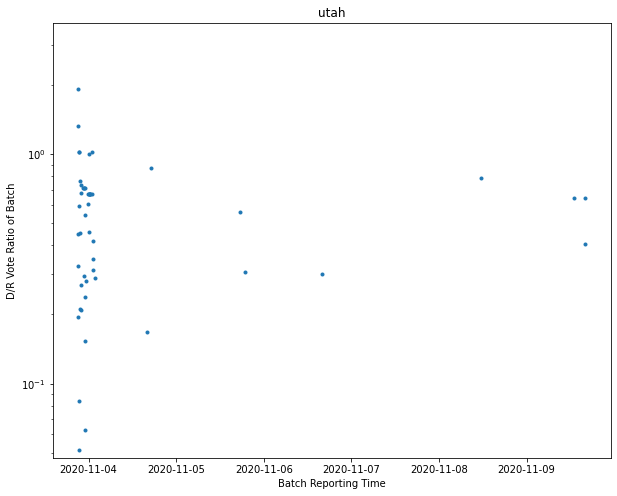

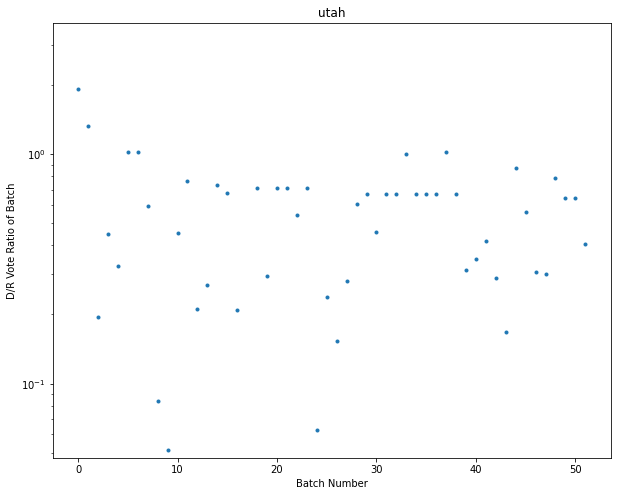

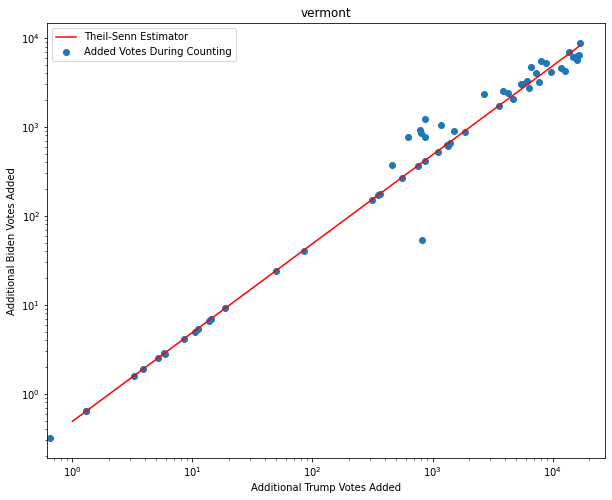

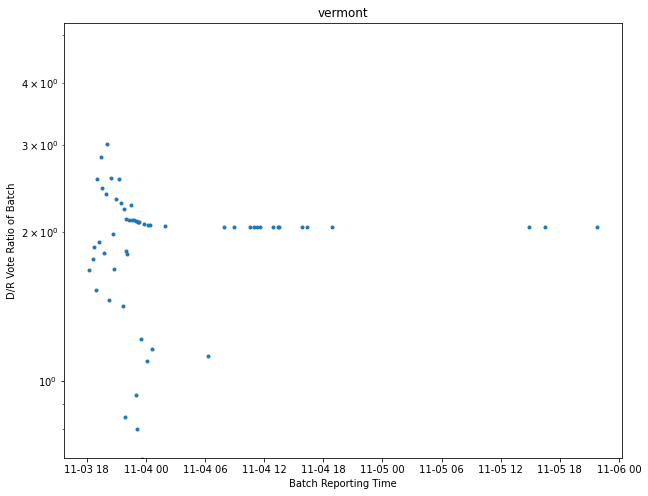

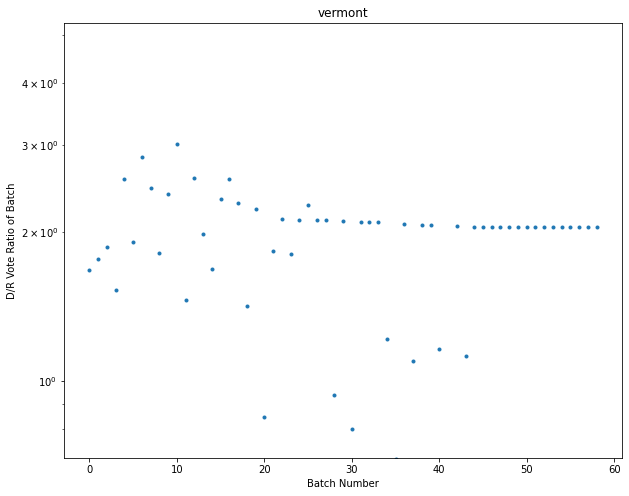

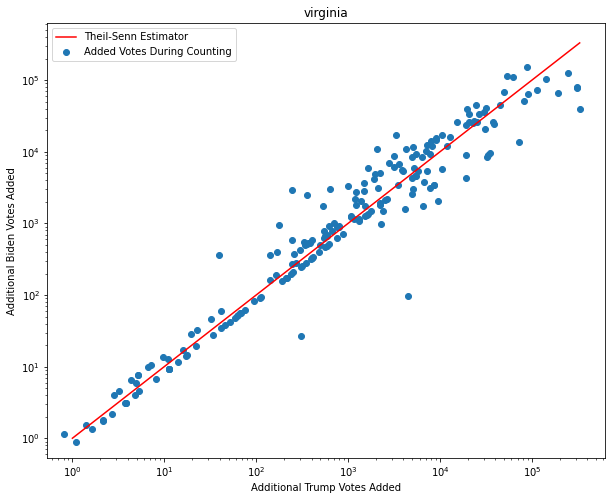

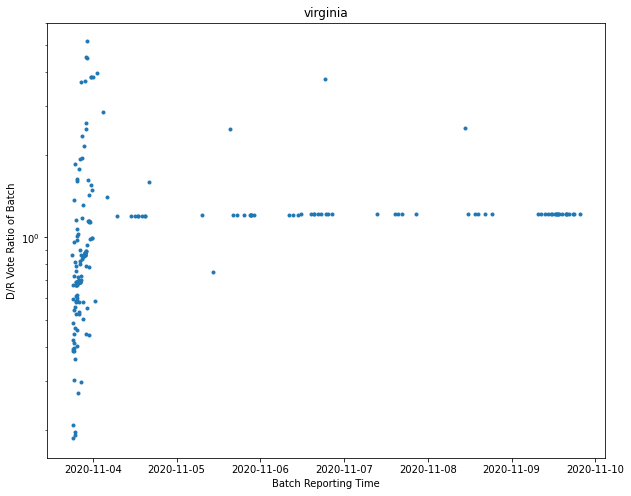

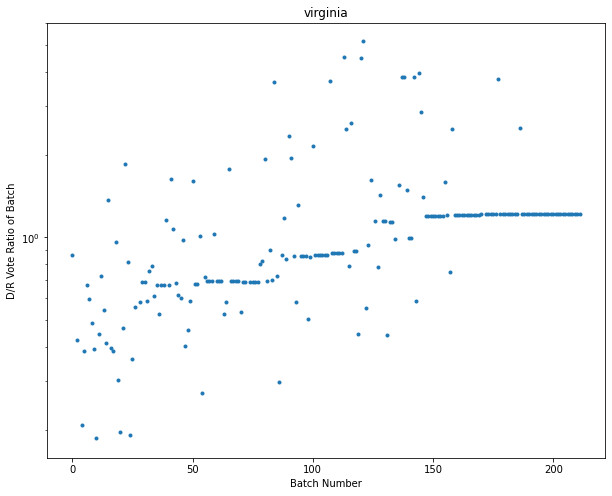

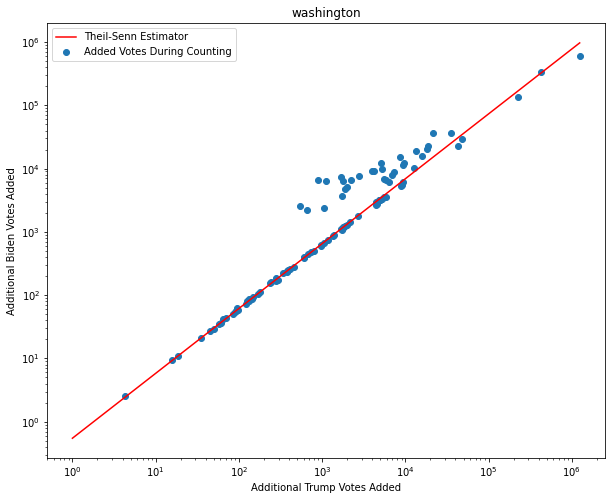

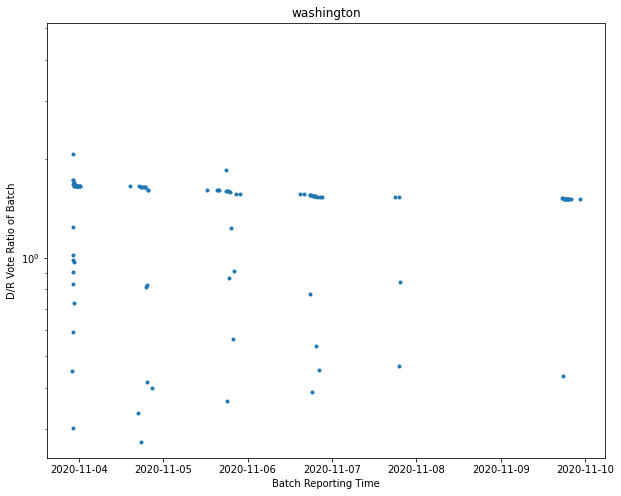

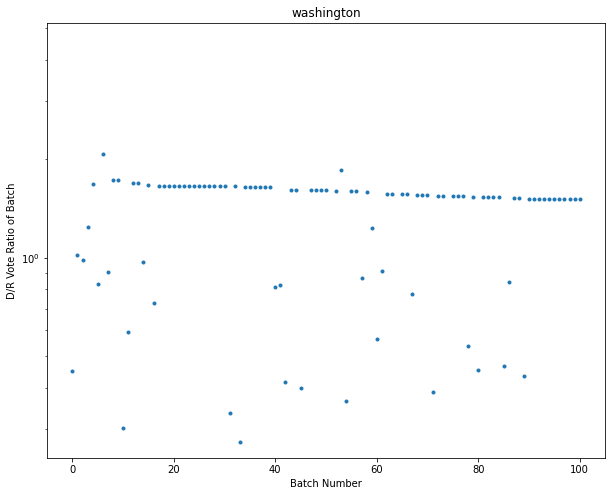

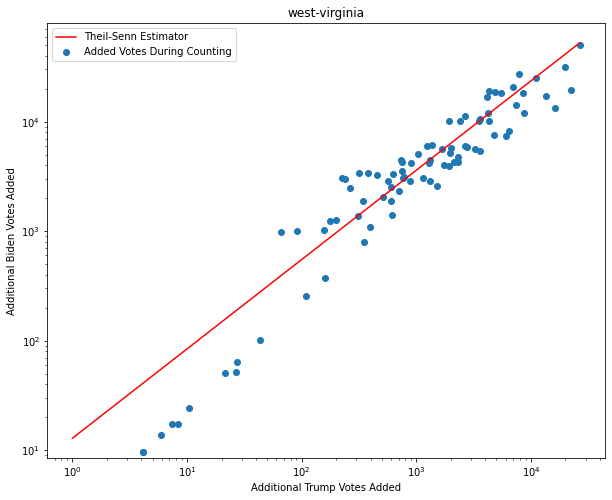

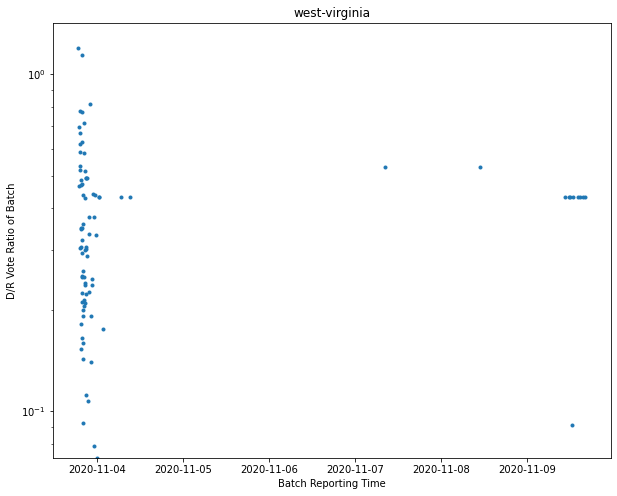

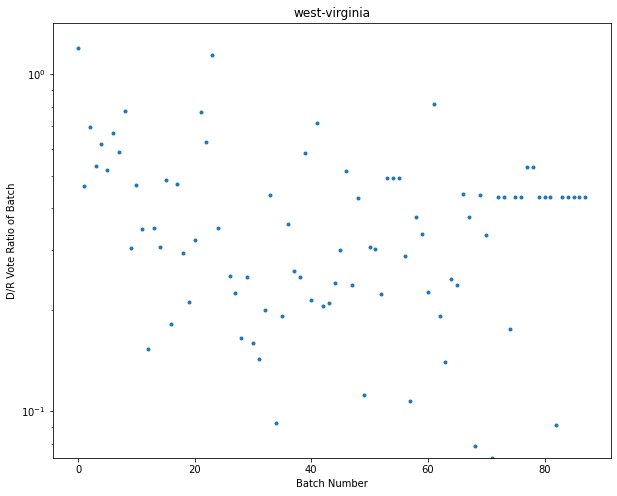

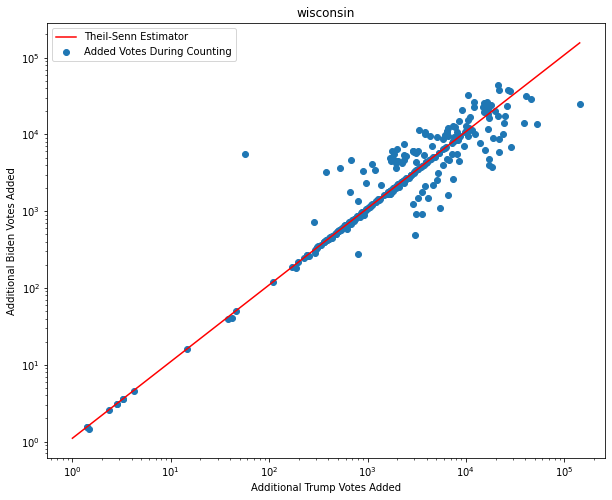

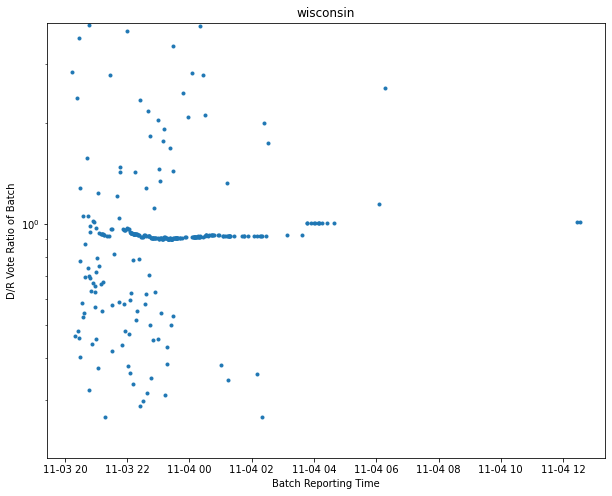

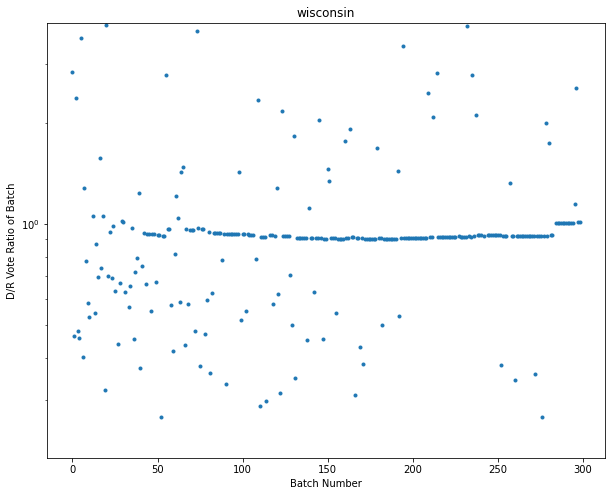

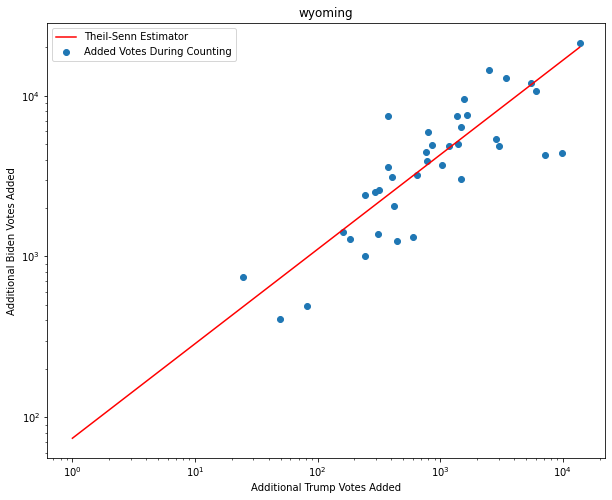

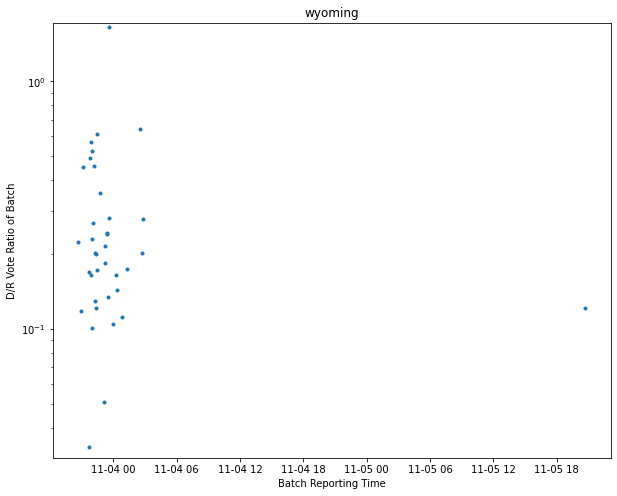

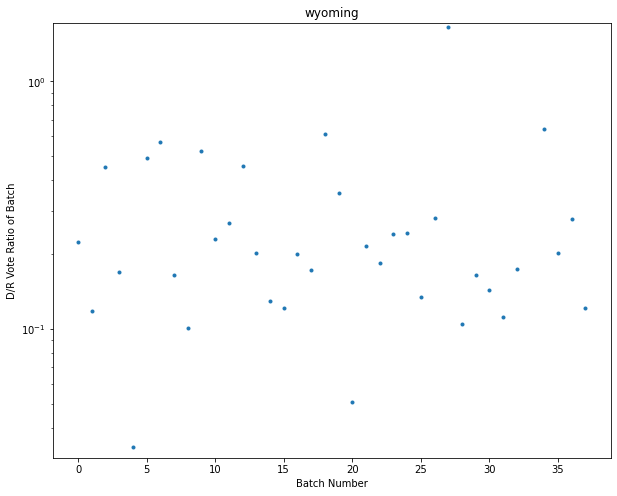

In [ ]:
from scipy.stats import pearsonr
from sklearn.linear_model import TheilSenRegressor as Model

import matplotlib
matplotlib.rcParams['timezone'] = 'US/Central'

rep = data.vote_share_rep.values * data.votes.values
dem = data.vote_share_dem.values * data.votes.values
timestamp = pd.to_datetime(data.timestamp).values

signal = (data.vote_share_rep.values - data.vote_share_dem.values) # + 5000

PLOT = True
delay = 0

# added for clarity because there's a single datapoint several days later that
# makes the plot difficult to see
earlyStops = {
    'wisconsin': np.datetime64('2020-11-05')

}

for state in np.unique(data.state.values):
  mask = data.state.values == state
  if state in earlyStops:
    mask &= timestamp < earlyStops[state]

  time = timestamp[mask][1 + delay:]
  d = np.diff(dem[mask])[delay:]
  r = np.diff(rep[mask])[delay:]



  x = np.log(d)
  y = np.log(r)
  mask = np.isfinite(x) & np.isfinite(y)
  model = Model().fit(x[mask, None], y[mask])
  lineX = np.array([1, np.max(d)])
  lineY = np.exp(model.predict(np.log(lineX)[:, None]))

  plt.figure(figsize=(10, 8))
  plt.scatter(d, r, label='Added Votes During Counting')
  plt.plot(lineX, lineY, label='Theil-Senn Estimator', color='red')
  plt.yscale('log')
  plt.xscale('log')
  plt.ylabel('Additional Biden Votes Added')
  plt.xlabel('Additional Trump Votes Added')
  plt.legend()
  plt.title(state)


  ratio = d/r
  mask2 = np.isfinite(np.log(d/r))
  logTransformed = np.log(ratio[mask2])
  mean, std = np.mean(logTransformed), np.std(logTransformed)
  upper, lower = np.exp(mean + (2.5 * std)), np.exp(mean - (2.5 * std))

  plt.figure(figsize=(10, 8))
  plt.scatter(time[mask2], ratio[mask2], marker='.')
  plt.ylabel('D/R Vote Ratio of Batch')
  plt.xlabel('Batch Reporting Time')
  plt.yscale('log')
  plt.ylim(lower, upper)
  plt.title(state)

  
  plt.figure(figsize=(10, 8))
  plt.scatter(np.arange(np.sum(mask2)), ratio[mask2], marker='.')
  plt.ylabel('D/R Vote Ratio of Batch')
  plt.xlabel('Batch Number')
  plt.yscale('log')
  plt.ylim(lower, upper)
  plt.title(state)
